# Vegetable Disease Detection

Dataset : [Drive LInk](https://drive.google.com/drive/folders/1MbATgbXK93jbH2MdULSAmO5Re2-zyf5J?usp=sharing)
<br>
Save a copy in your drive<br>
Make a folder named "Image Classification" <br>
Move the dataset to it.

## Setting Up Environment


Mounting Google Drive for accessing files

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


Unzipping Dataset (zip file)

In [ ]:
!unzip "/content/drive/MyDrive/Image Classification/vegetable_disease_dataset_001.zip"

Importing Libraries needed

In [3]:
from PIL import Image
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import torch
import torch.onnx
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from sklearn.metrics import classification_report

from datetime import datetime

import os
import time
import json
import pickle
from tqdm import tqdm
from tqdm.notebook import trange
from google.colab.patches import cv2_imshow

Defining Paths and Version Display

In [4]:
DATA_DIR = "/content/vegetable_disease_dataset_001"
TRAINING_DATA_PATH = os.path.join(DATA_DIR,"train")   # Replace this string with the PATH to train directory in the dataset.
VALIDATION_DATA_PATH = os.path.join(DATA_DIR,"valid")   # Replace this string with the PATH to valid directory in the dataset.

In [5]:
print(torch.__version__)

1.13.1+cu116


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Creating Reference variables

In [7]:
# Creating a dictionary 
num_to_labels = {}
labels_to_num = {}
labels_name=[]
main_dir = os.listdir(TRAINING_DATA_PATH)
for i,dir in enumerate(main_dir):
    num_to_labels[i]= dir
    labels_to_num[dir] = i
    labels_name.append(dir)

with open("num_to_labels.json", "w") as outfile:
    json.dump(num_to_labels, outfile)

with open("labels_to_num.json", "w") as outfile:
    json.dump(labels_to_num, outfile)

## Data Loading and Pre Processing

Defining Train Dataset Class in PyTorch

In [8]:
class TrainDataset():                                                      
    def __init__(self):
        self.root = TRAINING_DATA_PATH
        self.img_count = 1600
        self.dataset = self.load_data()


    def load_data(self):
        data_list=[]
        main_dir = os.listdir(self.root)
        for i,dir in enumerate(tqdm(main_dir)):
          images_list = os.listdir(os.path.join(self.root,dir))
          local_cnt = 0
          for img in images_list:
              if local_cnt<self.img_count:
                  data_list.append([dir,os.path.join(self.root,dir,img)])
                  local_cnt+=1

        df = pd.DataFrame(data_list, columns =['label', 'path'])
        return df

    # Returns the number of samples in the dataset.
    def __len__(self):
        return len(self.dataset)

    # To return x,y values in each iteration over dataloader as batches.
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.dataset.iloc[idx, 1])
        labels= self.dataset.iloc[idx, 0]
        image = Image.open(img_path)
        resize = transforms.Compose(
             [ transforms.Resize(224),
              transforms.ToTensor(),
              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) 
        
        
        image = resize(image)   # Resize the images.
        return (
            image,
            int(labels_to_num[labels]),
        )



Defining Validation Dataset Class through Inheritence

In [9]:
# Inheriting from above Dataset class
class ValDataset(TrainDataset):
    def __init__(self):
        self.root = VALIDATION_DATA_PATH
        self.img_count = 400
        self.dataset = self.load_data()

Loading Dataset using classes defined.

In [10]:
trainDataset = TrainDataset()
valDataset = ValDataset()

100%|██████████| 14/14 [00:00<00:00, 1065.10it/s]


In [11]:
trainDataset.dataset

label  \
0      Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...   
1      Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...   
2      Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...   
3      Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...   
4      Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...   
...                                                  ...   
22395                        Tomato___Septoria_leaf_spot   
22396                        Tomato___Septoria_leaf_spot   
22397                        Tomato___Septoria_leaf_spot   
22398                        Tomato___Septoria_leaf_spot   
22399                        Tomato___Septoria_leaf_spot   

                                                    path  
0      /content/vegetable_disease_dataset_001/train/C...  
1      /content/vegetable_disease_dataset_001/train/C...  
2      /content/vegetable_disease_dataset_001/train/C...  
3      /content/vegetable_disease_dataset_001/train/C...  
4      /content/vegetable_disease_dataset_001/train/C...  
...                                                  ...  
22395  /content/vegetable_disease_dataset_001/train/T...  
22396  /content/vegetable_disease_dataset_001/train/T...  
22397  /content/vegetable_disease_dataset_001/train/T...  
22398  /content/vegetable_disease_dataset_001/train/T...  
22399  /content/vegetable_disease_dataset_001/train/T...  

[22400 rows x 2 columns]

Loading Datasets using DataLoader in PyTorch

In [12]:
# Dataloader in pytorch to load train and validation dataset
trainDataloader = torch.utils.data.DataLoader(trainDataset, batch_size=64, shuffle=True)
print("Loaded Training data")
valDataloader = torch.utils.data.DataLoader(valDataset, batch_size=32, shuffle=True)
print("Loaded Validation data")

Loaded Training data
Loaded Validation data


## Training Scripts

Function to return number of correct predictions in a batch

In [13]:
def get_num_correct(preds, labels):
    return torch.round(preds).argmax(dim=1).eq(labels).sum().item()

Creating directories to store models, confusion matrices and the performance metrics

In [14]:
if not os.path.isdir("confusion_matrices"):
    os.mkdir("confusion_matrices")
cfm_dir = "confusion_matrices"

if not os.path.isdir("models"):
    os.mkdir("models")

model_dir = "models"

if not os.path.isdir("valid_metrics"):
    os.mkdir("valid_metrics")
json_dir = "valid_metrics"

Validation function

In [15]:
@torch.no_grad()
def valid(epoch,valdataloader,optimizer):
    model.eval()                                         # Sets the module in evaluation mode
    confusion_matrix = np.zeros((14, 14), dtype=int)
    tot_loss = 0
    y_true_total=[]
    y_pred_final=[]
    with torch.no_grad():
        for batch, (x, y) in enumerate(valdataloader):     
                x,y = x.to(device),y.to(device)          # Sets the tensors to device GPU if available             
                # Sets the gradients of all optimized tensors to zero
                optimizer.zero_grad()
                y_pred = model(x)
                # Compute loss (here CrossEntropyLoss)
                loss = F.cross_entropy(y_pred, y)
                print("Test batch: {}, epoch: {}".format(batch+1,epoch+1), end='\r')

                tot_loss += loss.item()
                y_true_total.extend(np.array(y.cpu()))
                y_pred_final.extend(np.array(y_pred.argmax(dim=1).cpu()))
                for y_pred_img, y_img in zip(y_pred.argmax(dim=1), y):
                    confusion_matrix[y_img.item()][y_pred_img.item()] += 1
                

    valid_matrices= classification_report(y_true_total, y_pred_final, target_names=labels_name,output_dict=True)
    return tot_loss, valid_matrices, confusion_matrix

Train Function

In [19]:
def train(model, optimizer_choice = "sgdm", num_of_epochs = 25):
    try:

        # Defining the Optimizer
        # optimizer = optim.Adam(model.parameters(), lr=0.0001)  
        if optimizer_choice=="sgdm":
            optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
        elif optimizer_choice=="adam":
            optimizer = optim.Adam(model.parameters(), lr=0.0001)

        epochs = []
        losses = []
            
        matrices = pd.DataFrame(columns = ['epoch','accuracy','tot_loss','Macro Avg f1','Weighted Avg f1'])
        
        for epoch in range(num_of_epochs):
            tot_loss = 0        
            # Sets the Module in training mode
            model.train()
            for batch, (x, y) in enumerate(tqdm(trainDataloader)):
                x, y = x.to(device), y.to(device)
                # Sets the gradients of all optimized tensors to zero
                optimizer.zero_grad()
                y_pred = model(x)
                # Compute loss (here CrossEntropyLoss)
                loss = F.cross_entropy(y_pred, y)
                loss.backward()
                optimizer.step()
                # print("Train batch: {}, epoch: {}".format(batch+1, epoch+1), end='\r')
            
            tot_loss, valid_matrices, confusion_matrix = valid(epoch,valDataloader, optimizer)
            torch.save(model.state_dict(), model_dir+"/model_ep_"+str(epoch+1)+".pth")
            epochs.append(epoch)
            losses.append(tot_loss)
            print("Epoch {}, Val Accuracy : {}, Val loss: {}, Val Macro Avg f1 {}, Val Weighted Avg f1 {}".format(epoch+1,
                valid_matrices["accuracy"],(tot_loss),valid_matrices["macro avg"]["f1-score"],
                valid_matrices["weighted avg"]["f1-score"]))        
            
            matrices = matrices.append({'epoch':epoch+1, 'accuracy' : valid_matrices["accuracy"], 'tot_loss' : tot_loss,
                                        'Macro Avg f1' : valid_matrices["macro avg"]["f1-score"],
                                        'Weighted Avg f1':valid_matrices["weighted avg"]["f1-score"]}, ignore_index = True)
            out_file = open(json_dir+"/ep_"+str(epoch+1)+".json", "w") 
            json.dump(valid_matrices, out_file, indent = 2) 
            out_file.close() 
            
            df_cm = pd.DataFrame(confusion_matrix, index = [str(num_to_labels[i]) for i in range(0,14)],
                                columns = [str(num_to_labels[i]) for i in range(0,14)])
            fig=plt.figure()
            plt.figure(figsize = (20,20))
            sn.heatmap(df_cm, annot=True, fmt = 'g')
            plt.xlabel('Predicted Values-->', fontsize=10)
            plt.ylabel('True Values------->', fontsize=10)
            plt.close(fig)
            plt.savefig(cfm_dir+"/cfsn_mtrx_epoch_"+str(epoch+1)+".jpg")
            
        # Saving validation matrices for further analysis
        matrices.to_csv('valid_matrices.csv')
    except:
        matrices.to_csv('valid_matrices.csv')
    analyse_df = pd.read_csv("valid_matrices.csv")
    analyse_df = analyse_df.assign(accuracy = lambda x: (x['accuracy']* 100))


    plt.figure()
    ax = analyse_df[['accuracy','tot_loss']].plot(secondary_y=['tot_loss'])
    ax.set_ylabel('Val Accuracy')
    ax.set_xlabel("Epochs")
    ax.right_ax.set_ylabel('Val Loss')
    ax.legend(loc='right')
    ax.right_ax.legend(loc='center')

## Defining Model

In [20]:
model = torchvision.models.get_model('mobilenet_v2', weights='MobileNet_V2_Weights.IMAGENET1K_V1')
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=14)
model = model.to(device)

## Train

100%|██████████| 350/350 [01:53<00:00,  3.07it/s]


Epoch 1, Val Accuracy : 0.8432142857142857, Val loss: 176.07945877313614, Val Macro Avg f1 0.8417876186558049, Val Weighted Avg f1 0.8417876186558049


100%|██████████| 350/350 [01:50<00:00,  3.18it/s]


Epoch 2, Val Accuracy : 0.9048214285714286, Val loss: 89.02179443836212, Val Macro Avg f1 0.903792959535617, Val Weighted Avg f1 0.9037929595356169


100%|██████████| 350/350 [01:50<00:00,  3.16it/s]


Epoch 3, Val Accuracy : 0.9321428571428572, Val loss: 58.05656297504902, Val Macro Avg f1 0.9317743754112531, Val Weighted Avg f1 0.9317743754112532


100%|██████████| 350/350 [01:50<00:00,  3.17it/s]


Epoch 4, Val Accuracy : 0.9457142857142857, Val loss: 42.58199550956488, Val Macro Avg f1 0.9454301177280587, Val Weighted Avg f1 0.945430117728059


100%|██████████| 350/350 [01:52<00:00,  3.11it/s]


Epoch 5, Val Accuracy : 0.9542857142857143, Val loss: 33.9186328984797, Val Macro Avg f1 0.9541609493536596, Val Weighted Avg f1 0.9541609493536597


100%|██████████| 350/350 [01:51<00:00,  3.13it/s]


Epoch 6, Val Accuracy : 0.9605357142857143, Val loss: 28.624558325856924, Val Macro Avg f1 0.9604472676279728, Val Weighted Avg f1 0.9604472676279728


100%|██████████| 350/350 [01:48<00:00,  3.24it/s]


Epoch 7, Val Accuracy : 0.965, Val loss: 24.250780329108238, Val Macro Avg f1 0.9649769018573361, Val Weighted Avg f1 0.9649769018573359


100%|██████████| 350/350 [01:48<00:00,  3.22it/s]


Epoch 8, Val Accuracy : 0.96875, Val loss: 21.35249402374029, Val Macro Avg f1 0.9687259260914258, Val Weighted Avg f1 0.9687259260914259


100%|██████████| 350/350 [01:50<00:00,  3.18it/s]


Epoch 9, Val Accuracy : 0.9714285714285714, Val loss: 19.071385523304343, Val Macro Avg f1 0.9714217696822199, Val Weighted Avg f1 0.97142176968222


100%|██████████| 350/350 [01:48<00:00,  3.21it/s]


Epoch 10, Val Accuracy : 0.9732142857142857, Val loss: 17.590547086670995, Val Macro Avg f1 0.9731677708531175, Val Weighted Avg f1 0.9731677708531176


100%|██████████| 350/350 [01:48<00:00,  3.21it/s]


Epoch 11, Val Accuracy : 0.9741071428571428, Val loss: 16.16913860850036, Val Macro Avg f1 0.9740876635839585, Val Weighted Avg f1 0.9740876635839584


100%|██████████| 350/350 [01:48<00:00,  3.24it/s]


Epoch 12, Val Accuracy : 0.9751785714285715, Val loss: 15.104886518791318, Val Macro Avg f1 0.9751610176730122, Val Weighted Avg f1 0.9751610176730123


100%|██████████| 350/350 [01:48<00:00,  3.22it/s]


Epoch 13, Val Accuracy : 0.9767857142857143, Val loss: 13.971958334557712, Val Macro Avg f1 0.9767882877428377, Val Weighted Avg f1 0.9767882877428377


100%|██████████| 350/350 [01:48<00:00,  3.23it/s]


Epoch 14, Val Accuracy : 0.9782142857142857, Val loss: 13.093427903950214, Val Macro Avg f1 0.9782090331200084, Val Weighted Avg f1 0.9782090331200084


100%|██████████| 350/350 [01:48<00:00,  3.23it/s]


Epoch 15, Val Accuracy : 0.9783928571428572, Val loss: 12.508736082352698, Val Macro Avg f1 0.9783871231323579, Val Weighted Avg f1 0.9783871231323579


100%|██████████| 350/350 [01:50<00:00,  3.17it/s]


Epoch 16, Val Accuracy : 0.9796428571428571, Val loss: 11.817863335832953, Val Macro Avg f1 0.9796545700615651, Val Weighted Avg f1 0.9796545700615652


100%|██████████| 350/350 [01:51<00:00,  3.14it/s]


Epoch 17, Val Accuracy : 0.98, Val loss: 11.402026219293475, Val Macro Avg f1 0.9800072742910251, Val Weighted Avg f1 0.9800072742910252


100%|██████████| 350/350 [01:48<00:00,  3.23it/s]


Epoch 18, Val Accuracy : 0.98125, Val loss: 10.801175653003156, Val Macro Avg f1 0.9812508354232227, Val Weighted Avg f1 0.9812508354232226


100%|██████████| 350/350 [01:51<00:00,  3.15it/s]


Epoch 19, Val Accuracy : 0.9817857142857143, Val loss: 10.209884935989976, Val Macro Avg f1 0.9818033709186393, Val Weighted Avg f1 0.9818033709186395


100%|██████████| 350/350 [01:50<00:00,  3.16it/s]


Epoch 20, Val Accuracy : 0.9826785714285714, Val loss: 9.771427654661238, Val Macro Avg f1 0.9826916028407525, Val Weighted Avg f1 0.9826916028407527


<ipython-input-19-e21d788aeb63>:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (20,20))
100%|██████████| 350/350 [01:50<00:00,  3.16it/s]


Epoch 21, Val Accuracy : 0.9833928571428572, Val loss: 9.665303562302142, Val Macro Avg f1 0.9834017430370812, Val Weighted Avg f1 0.9834017430370812


<ipython-input-19-e21d788aeb63>:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure()
100%|██████████| 350/350 [01:48<00:00,  3.24it/s]


Epoch 22, Val Accuracy : 0.9826785714285714, Val loss: 9.303660605568439, Val Macro Avg f1 0.9826815370773365, Val Weighted Avg f1 0.9826815370773365


100%|██████████| 350/350 [01:49<00:00,  3.19it/s]


Epoch 23, Val Accuracy : 0.9844642857142857, Val loss: 8.762669652700424, Val Macro Avg f1 0.9844614383261644, Val Weighted Avg f1 0.9844614383261644


100%|██████████| 350/350 [01:48<00:00,  3.23it/s]


Epoch 24, Val Accuracy : 0.9841071428571428, Val loss: 8.628626955440268, Val Macro Avg f1 0.984113346505498, Val Weighted Avg f1 0.9841133465054981


100%|██████████| 350/350 [01:47<00:00,  3.25it/s]


Epoch 25, Val Accuracy : 0.9853571428571428, Val loss: 8.346326168160886, Val Macro Avg f1 0.9853719861907962, Val Weighted Avg f1 0.9853719861907961


100%|██████████| 350/350 [01:48<00:00,  3.24it/s]


Epoch 26, Val Accuracy : 0.9853571428571428, Val loss: 8.094309354899451, Val Macro Avg f1 0.9853634586394753, Val Weighted Avg f1 0.9853634586394753


100%|██████████| 350/350 [01:52<00:00,  3.12it/s]


Epoch 27, Val Accuracy : 0.9855357142857143, Val loss: 7.775858893059194, Val Macro Avg f1 0.9855440958160627, Val Weighted Avg f1 0.9855440958160625


100%|██████████| 350/350 [01:48<00:00,  3.23it/s]


Epoch 28, Val Accuracy : 0.9853571428571428, Val loss: 7.788703183177859, Val Macro Avg f1 0.9853539112190468, Val Weighted Avg f1 0.9853539112190468


100%|██████████| 350/350 [01:51<00:00,  3.14it/s]


Epoch 29, Val Accuracy : 0.9855357142857143, Val loss: 7.408251559128985, Val Macro Avg f1 0.985547194003623, Val Weighted Avg f1 0.985547194003623


100%|██████████| 350/350 [01:48<00:00,  3.24it/s]


Epoch 30, Val Accuracy : 0.9871428571428571, Val loss: 7.3551948859822005, Val Macro Avg f1 0.9871464566096063, Val Weighted Avg f1 0.9871464566096063


100%|██████████| 350/350 [01:51<00:00,  3.14it/s]


Epoch 31, Val Accuracy : 0.98625, Val loss: 7.142925233929418, Val Macro Avg f1 0.9862558123722127, Val Weighted Avg f1 0.9862558123722126


100%|██████████| 350/350 [01:48<00:00,  3.22it/s]


Epoch 32, Val Accuracy : 0.9878571428571429, Val loss: 6.969464074587449, Val Macro Avg f1 0.9878657280305416, Val Weighted Avg f1 0.9878657280305416


100%|██████████| 350/350 [01:48<00:00,  3.23it/s]


Epoch 33, Val Accuracy : 0.9866071428571429, Val loss: 6.915821347851306, Val Macro Avg f1 0.9866147849684426, Val Weighted Avg f1 0.9866147849684425


100%|██████████| 350/350 [01:51<00:00,  3.13it/s]


Epoch 34, Val Accuracy : 0.9880357142857142, Val loss: 6.7746250841300935, Val Macro Avg f1 0.9880459474179187, Val Weighted Avg f1 0.9880459474179188


100%|██████████| 350/350 [01:49<00:00,  3.21it/s]


Epoch 35, Val Accuracy : 0.9871428571428571, Val loss: 6.690861601033248, Val Macro Avg f1 0.9871448115696843, Val Weighted Avg f1 0.9871448115696841


100%|██████████| 350/350 [01:52<00:00,  3.12it/s]


Epoch 36, Val Accuracy : 0.9880357142857142, Val loss: 6.64012460259255, Val Macro Avg f1 0.9880428588023291, Val Weighted Avg f1 0.9880428588023293


100%|██████████| 350/350 [01:49<00:00,  3.21it/s]


Epoch 37, Val Accuracy : 0.9880357142857142, Val loss: 6.374911331338808, Val Macro Avg f1 0.9880356265708398, Val Weighted Avg f1 0.9880356265708398


100%|██████████| 350/350 [01:49<00:00,  3.21it/s]


Epoch 38, Val Accuracy : 0.9880357142857142, Val loss: 6.241102624218911, Val Macro Avg f1 0.9880375265228267, Val Weighted Avg f1 0.9880375265228268


100%|██████████| 350/350 [01:52<00:00,  3.12it/s]


Epoch 39, Val Accuracy : 0.9892857142857143, Val loss: 6.2202127617783844, Val Macro Avg f1 0.9892878960898817, Val Weighted Avg f1 0.9892878960898817


100%|██████████| 350/350 [01:49<00:00,  3.21it/s]


Epoch 40, Val Accuracy : 0.9878571428571429, Val loss: 6.29061443824321, Val Macro Avg f1 0.9878594879558307, Val Weighted Avg f1 0.9878594879558308


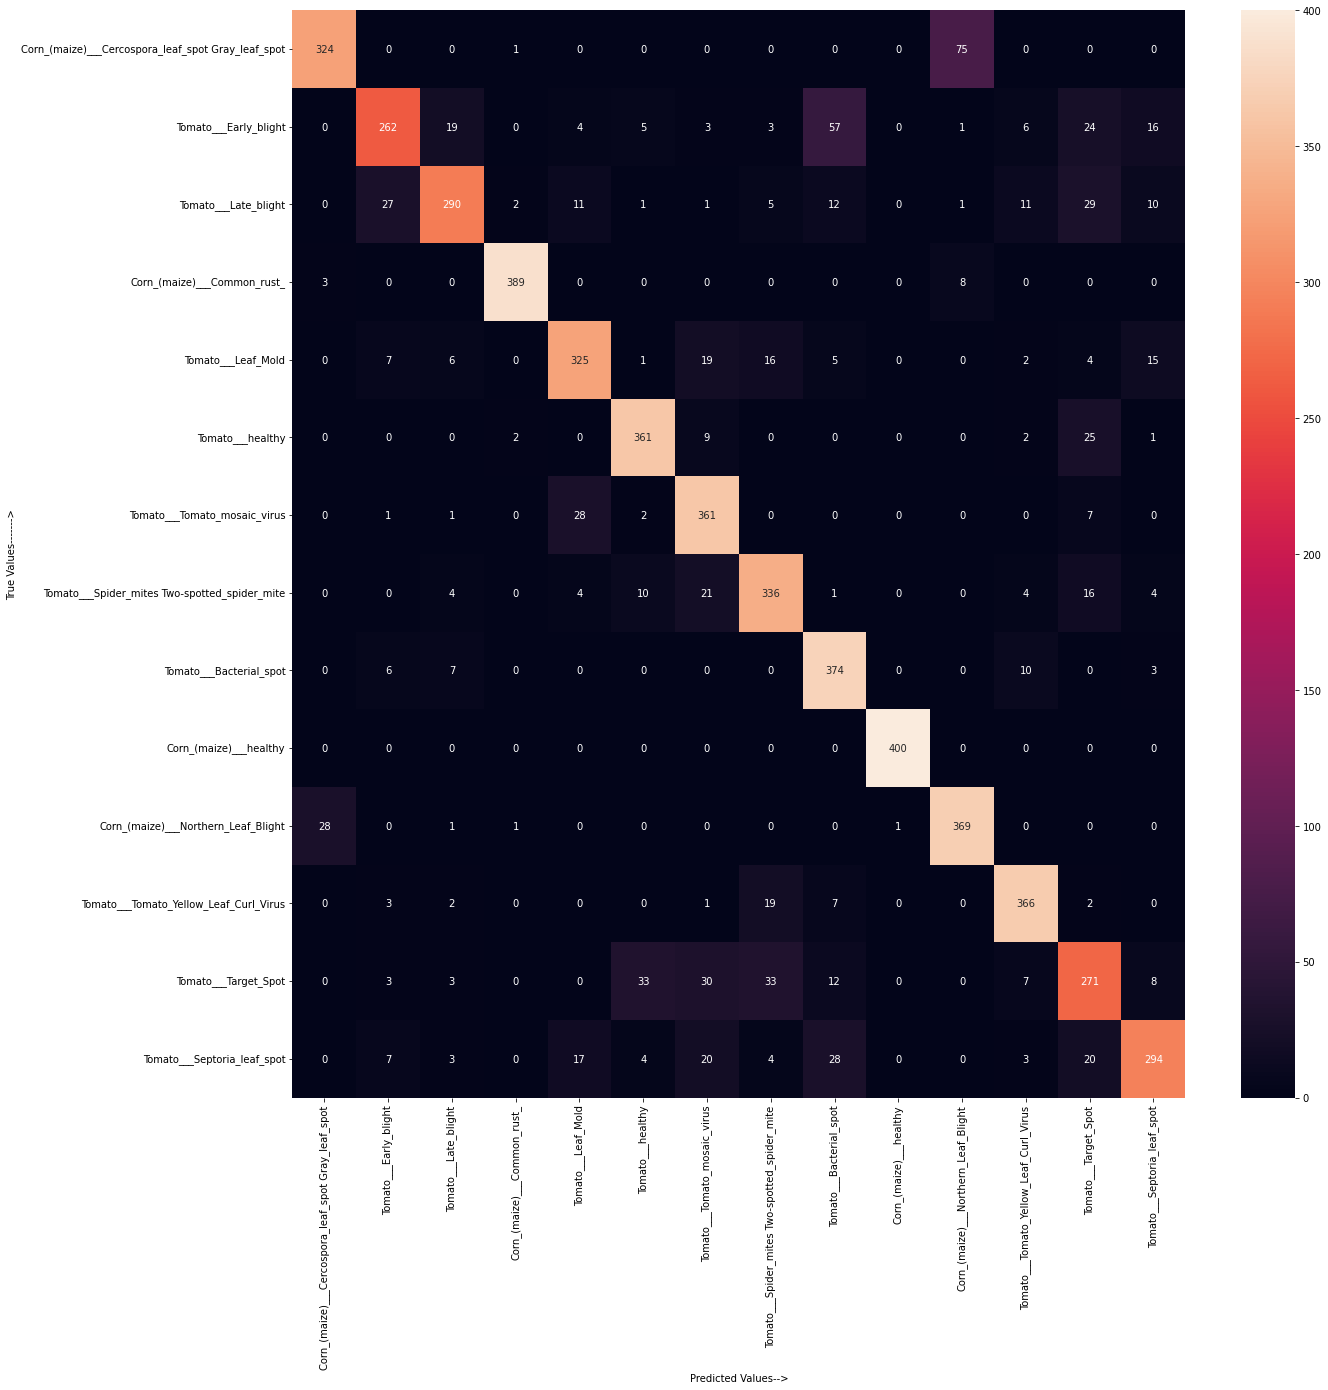

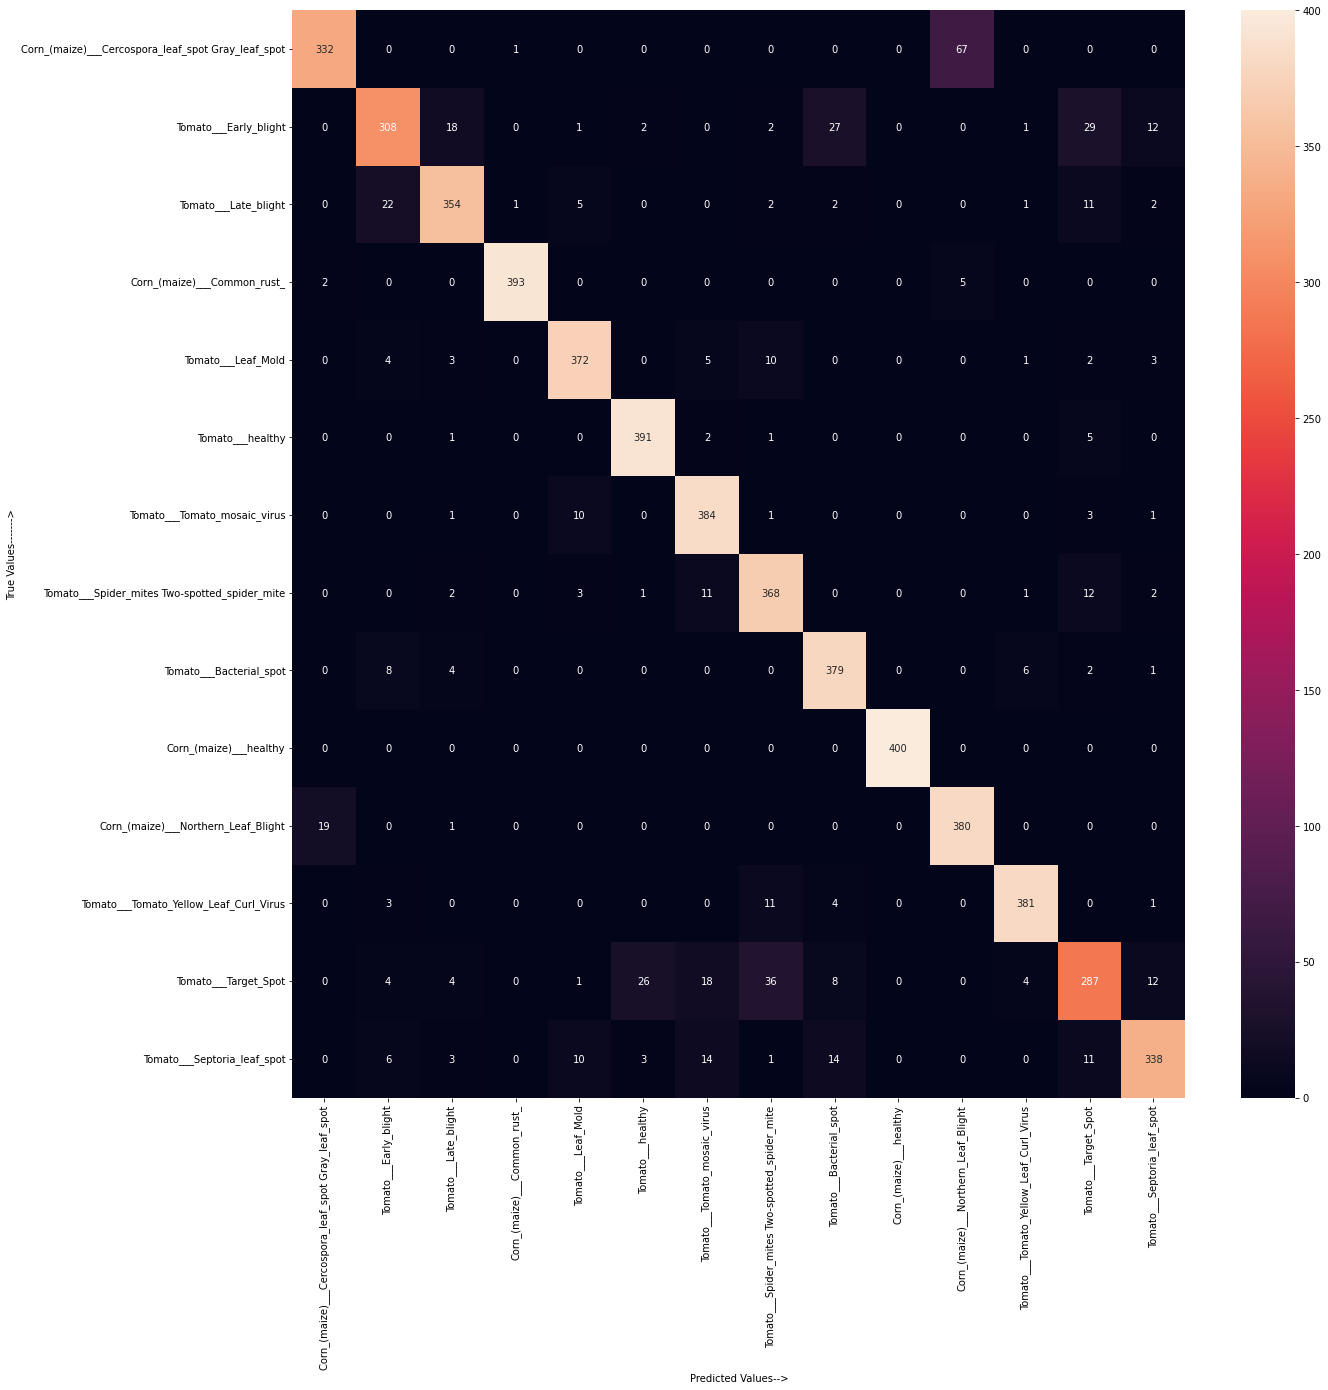

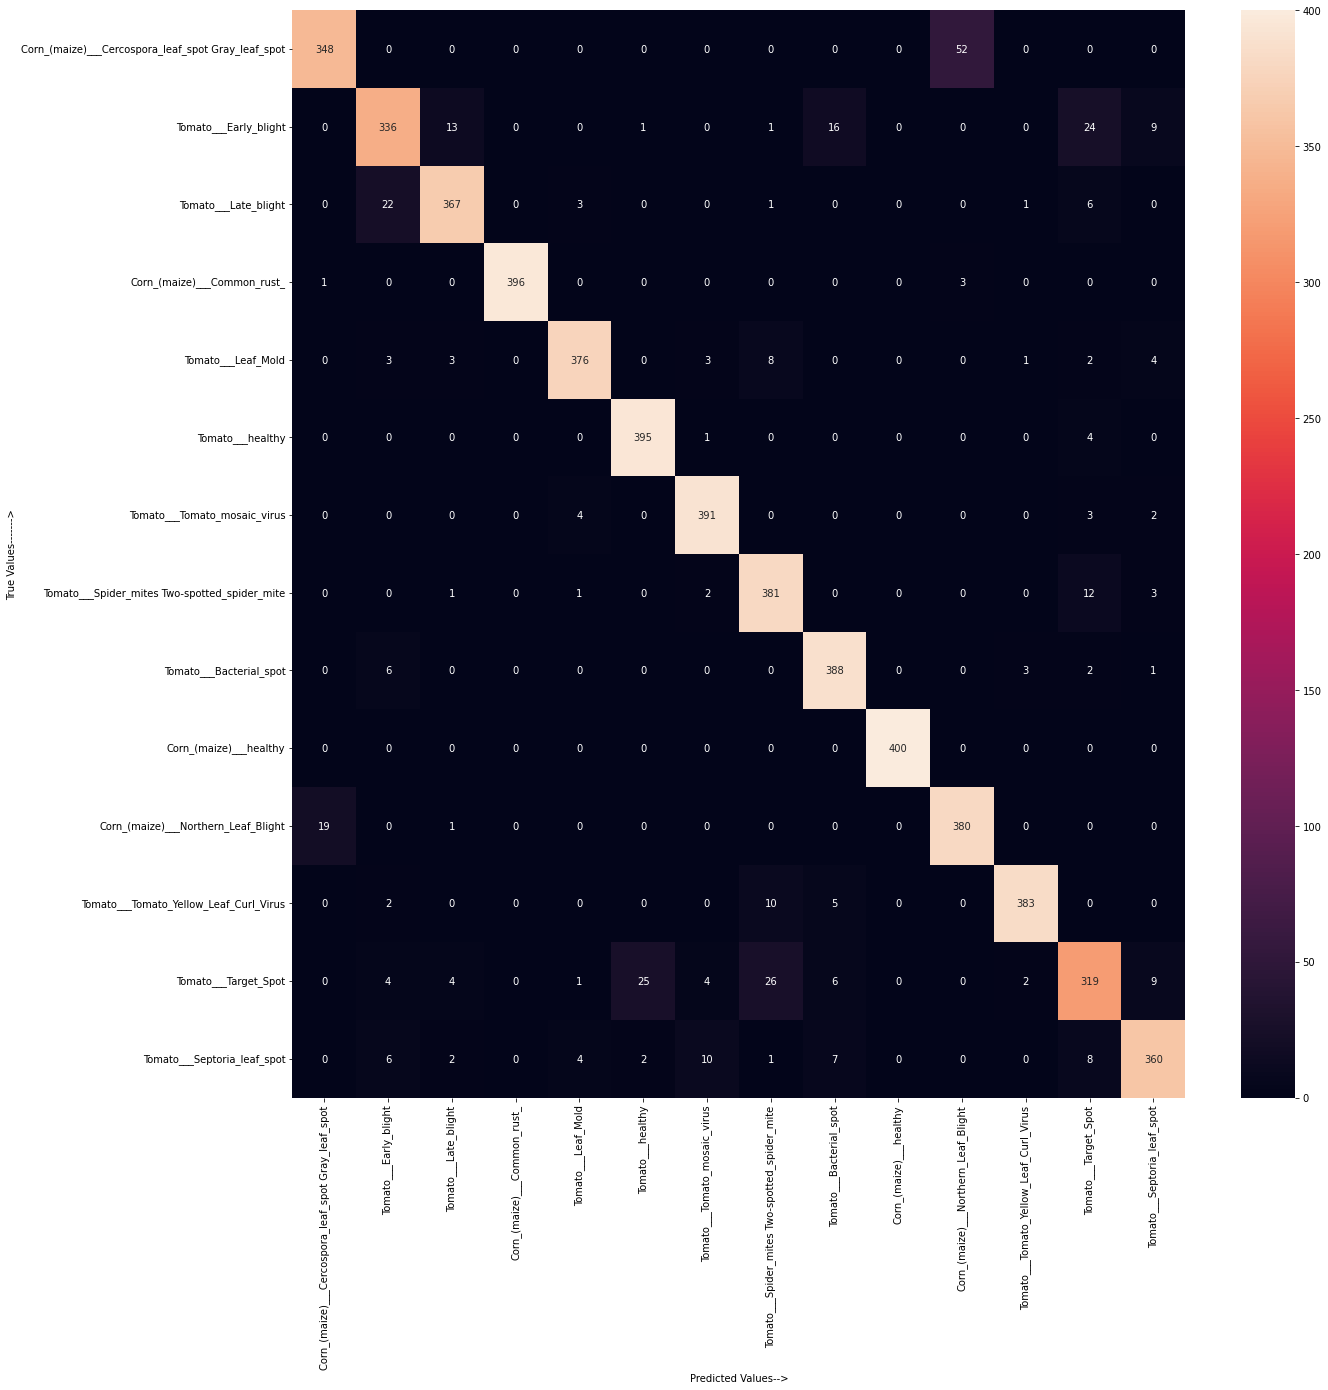

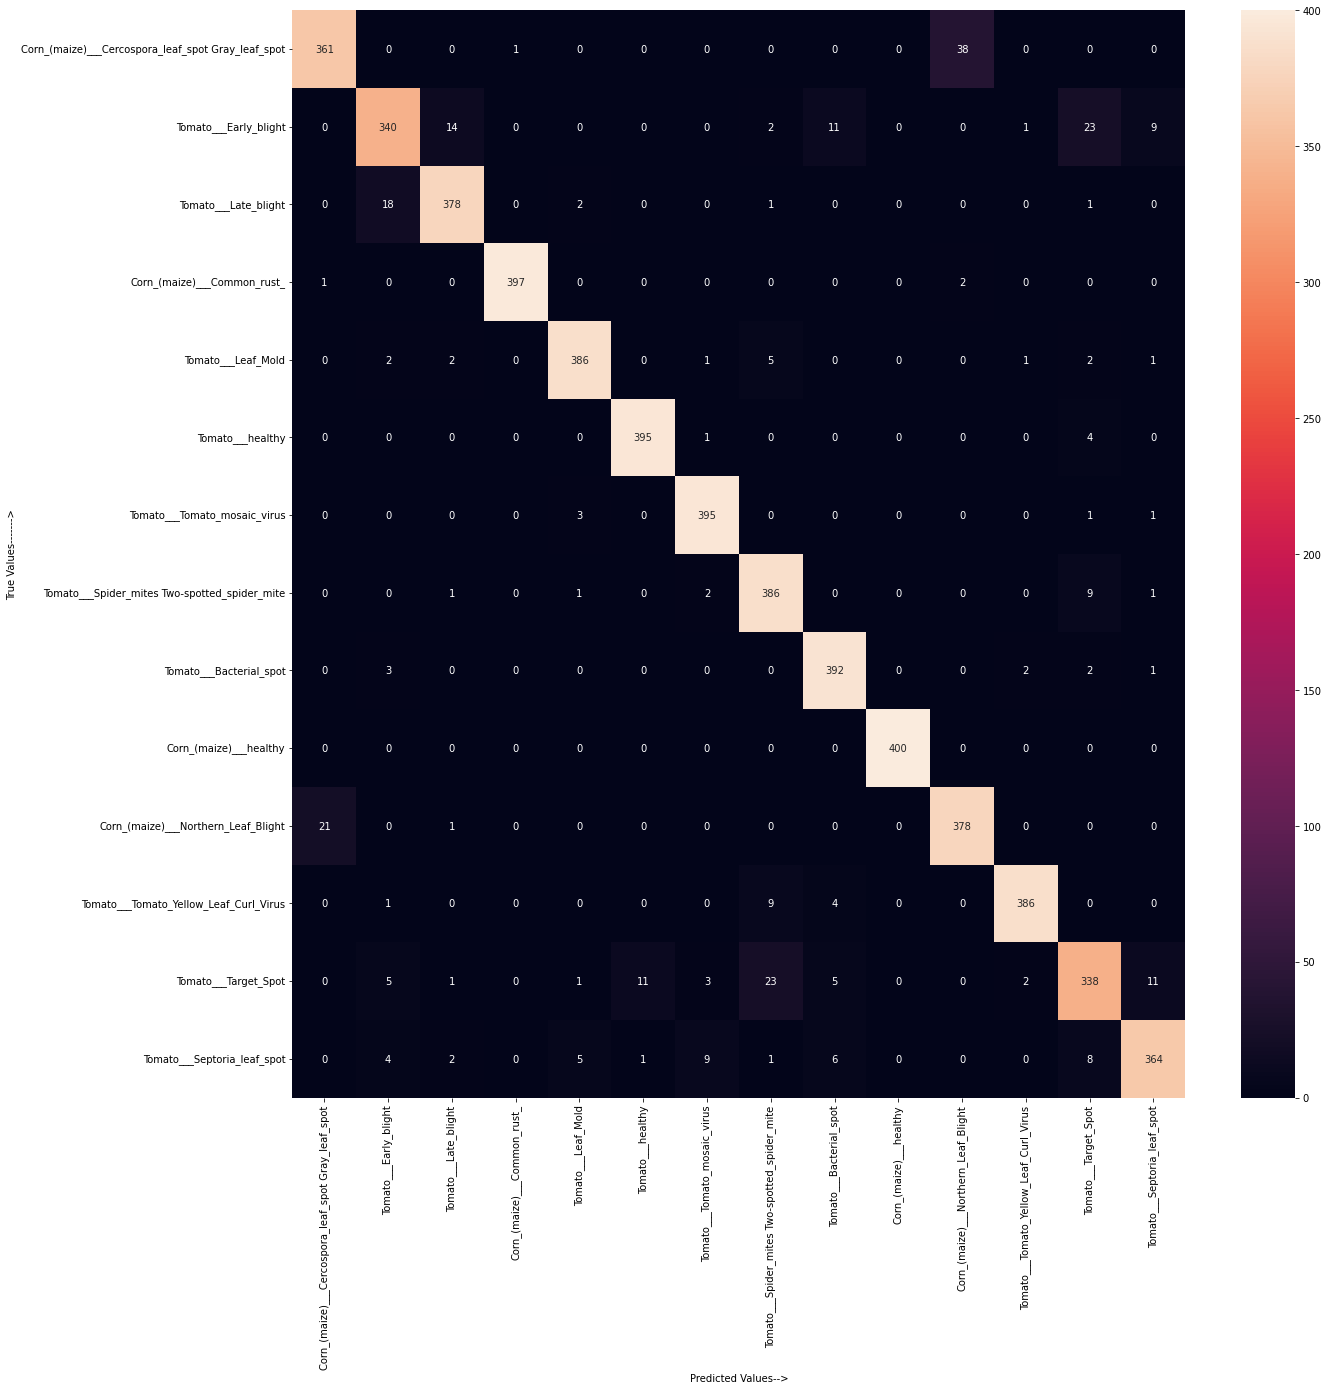

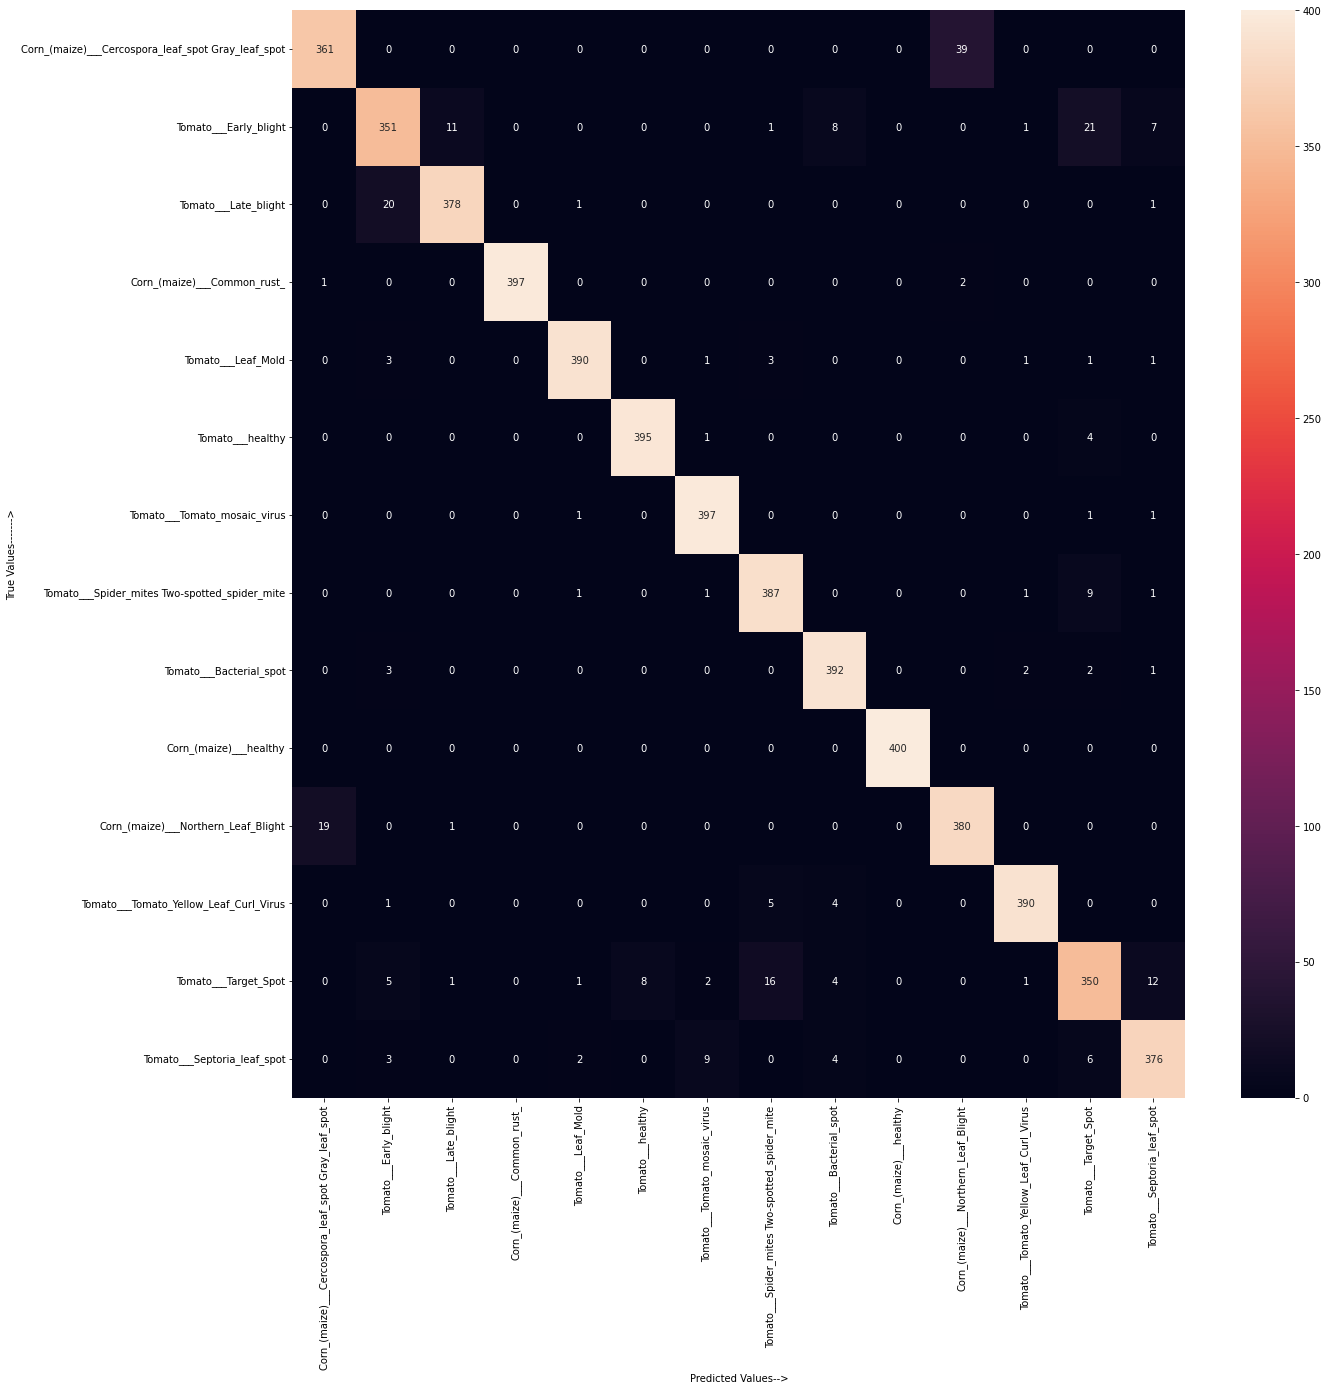

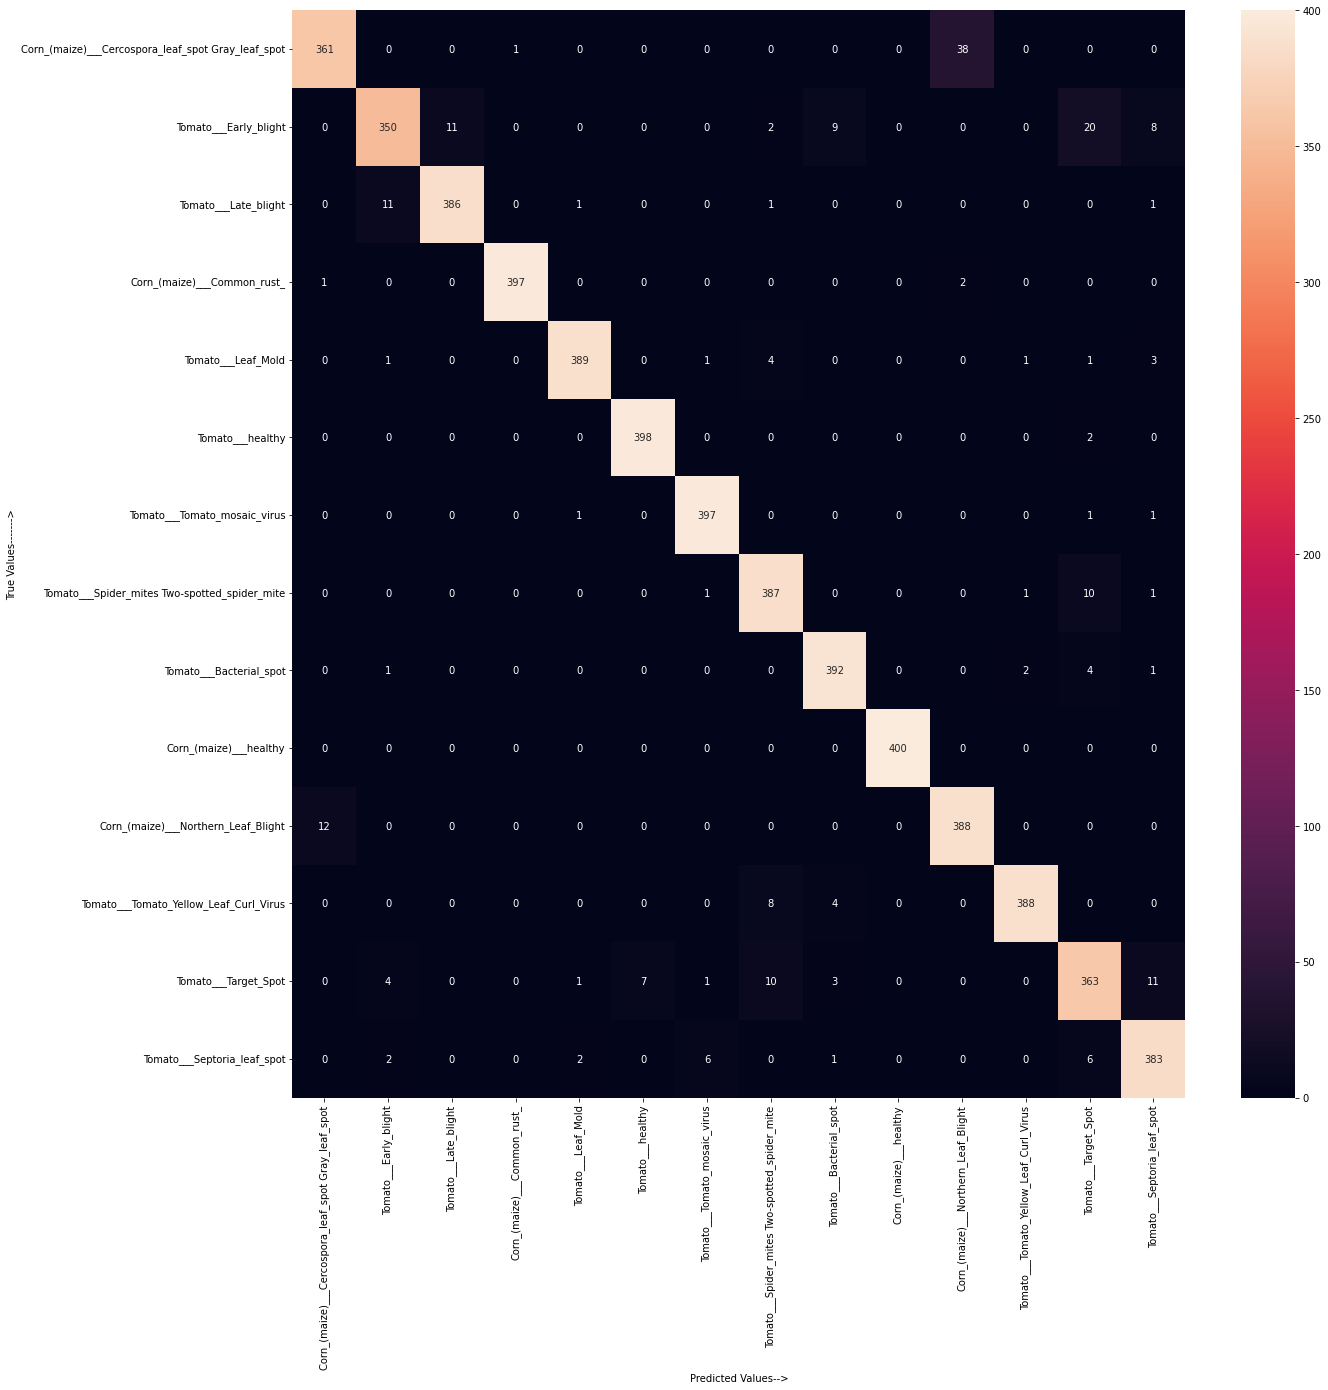

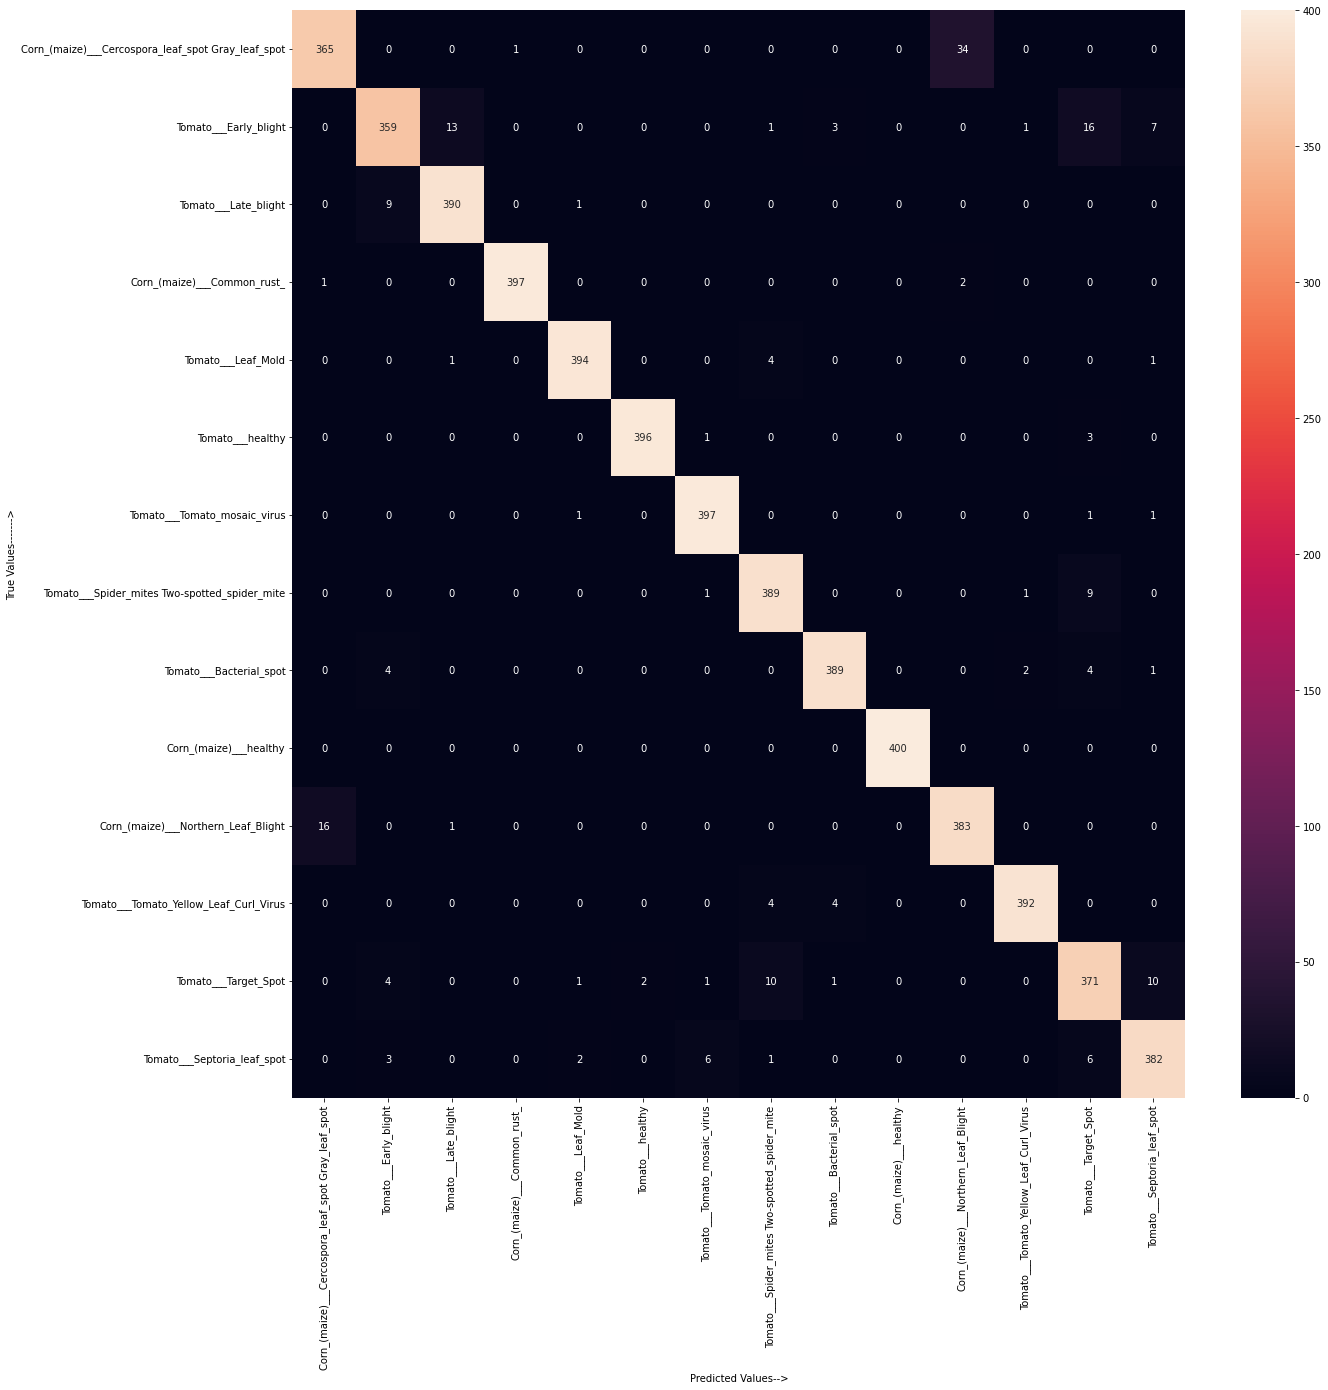

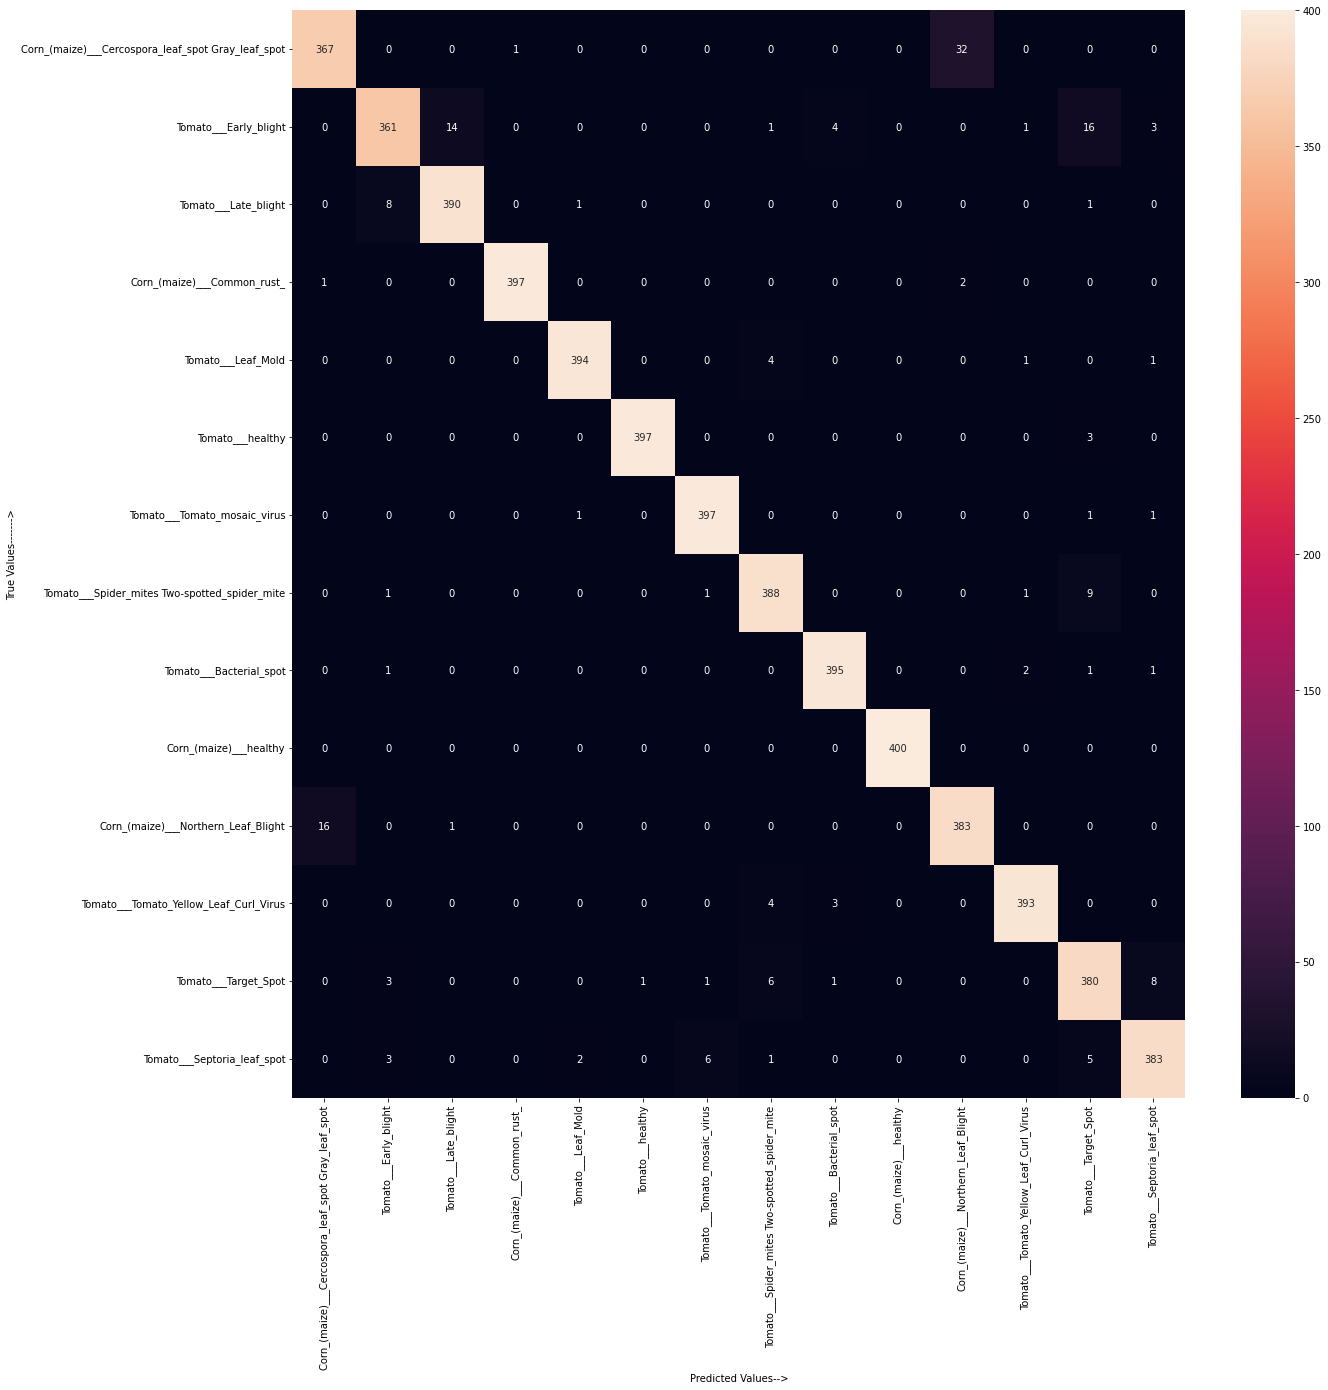

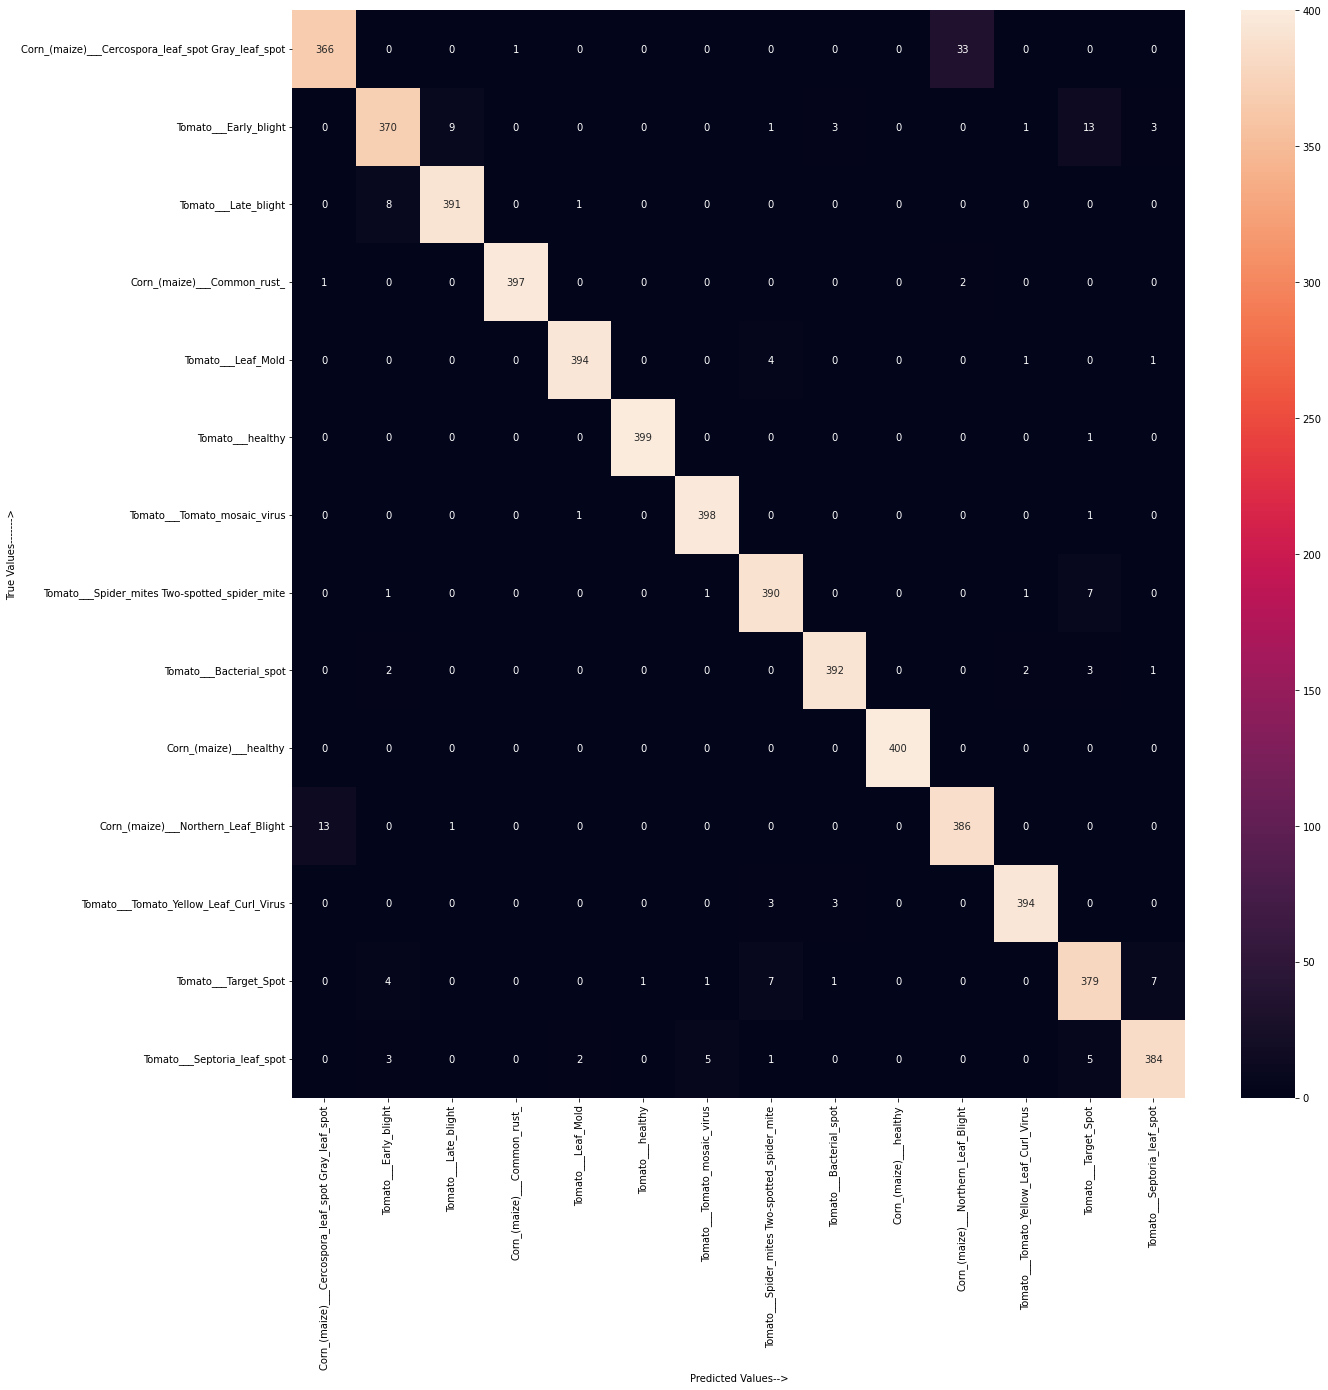

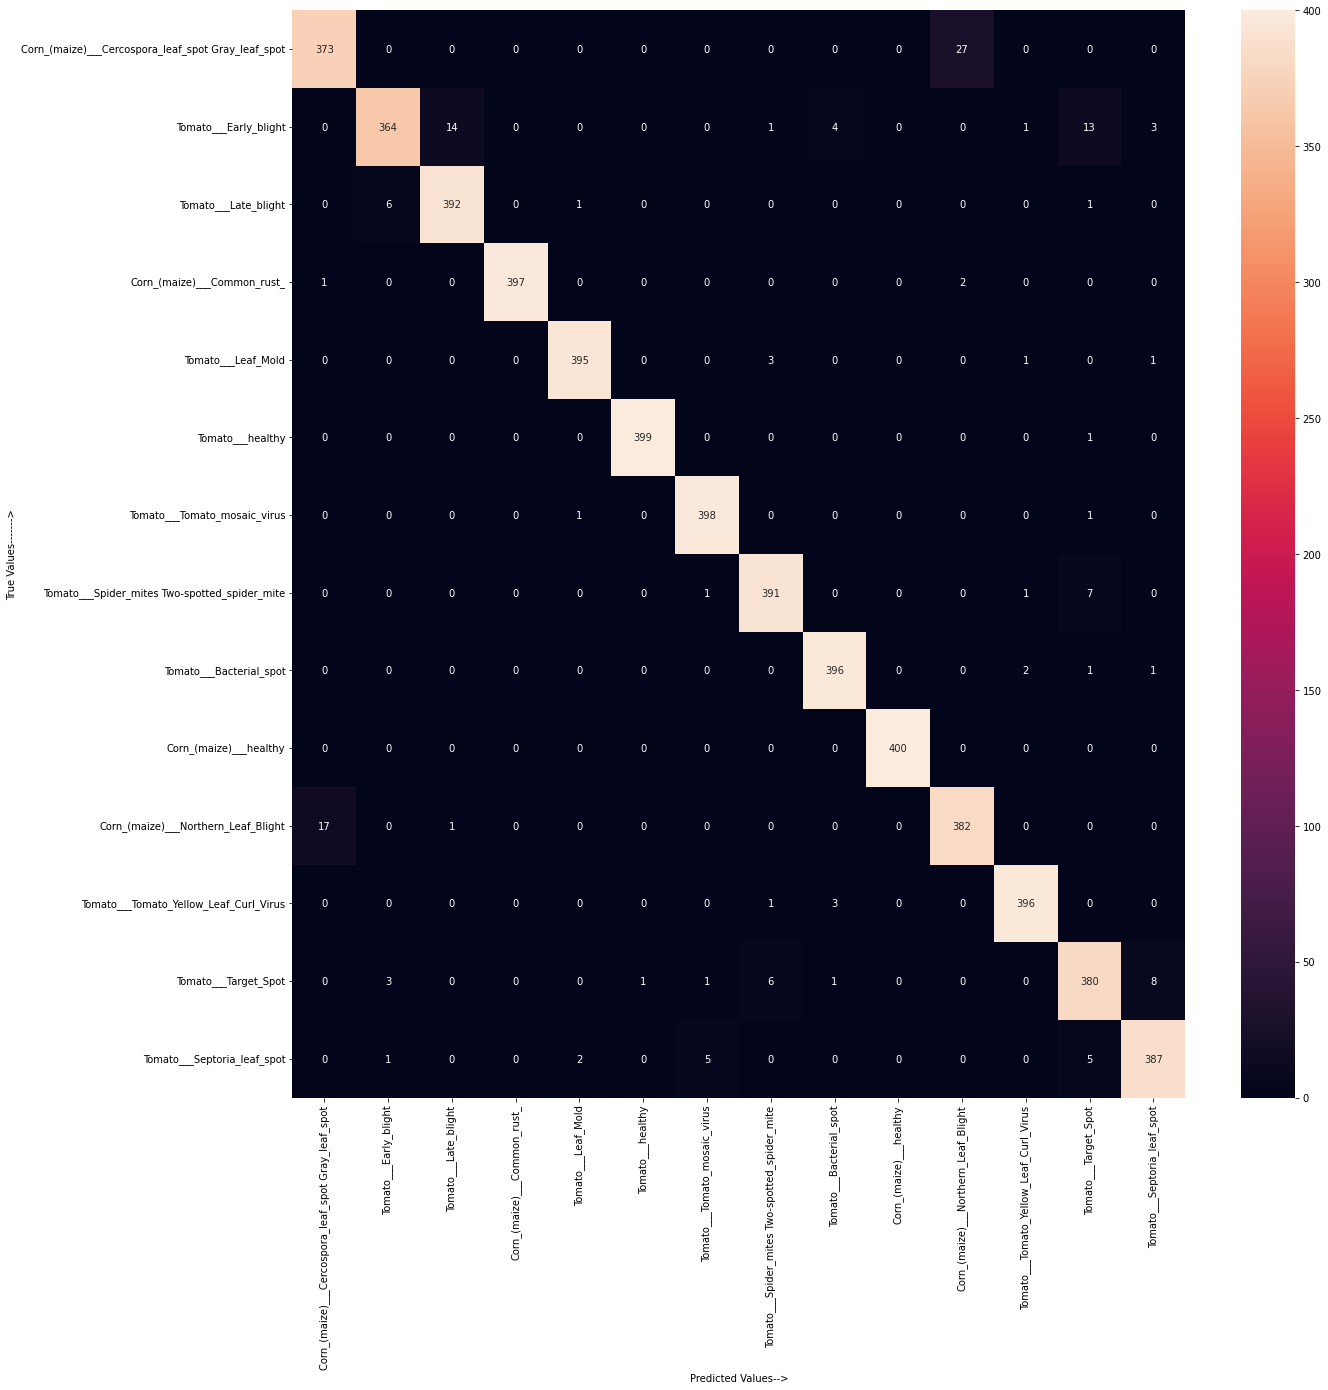

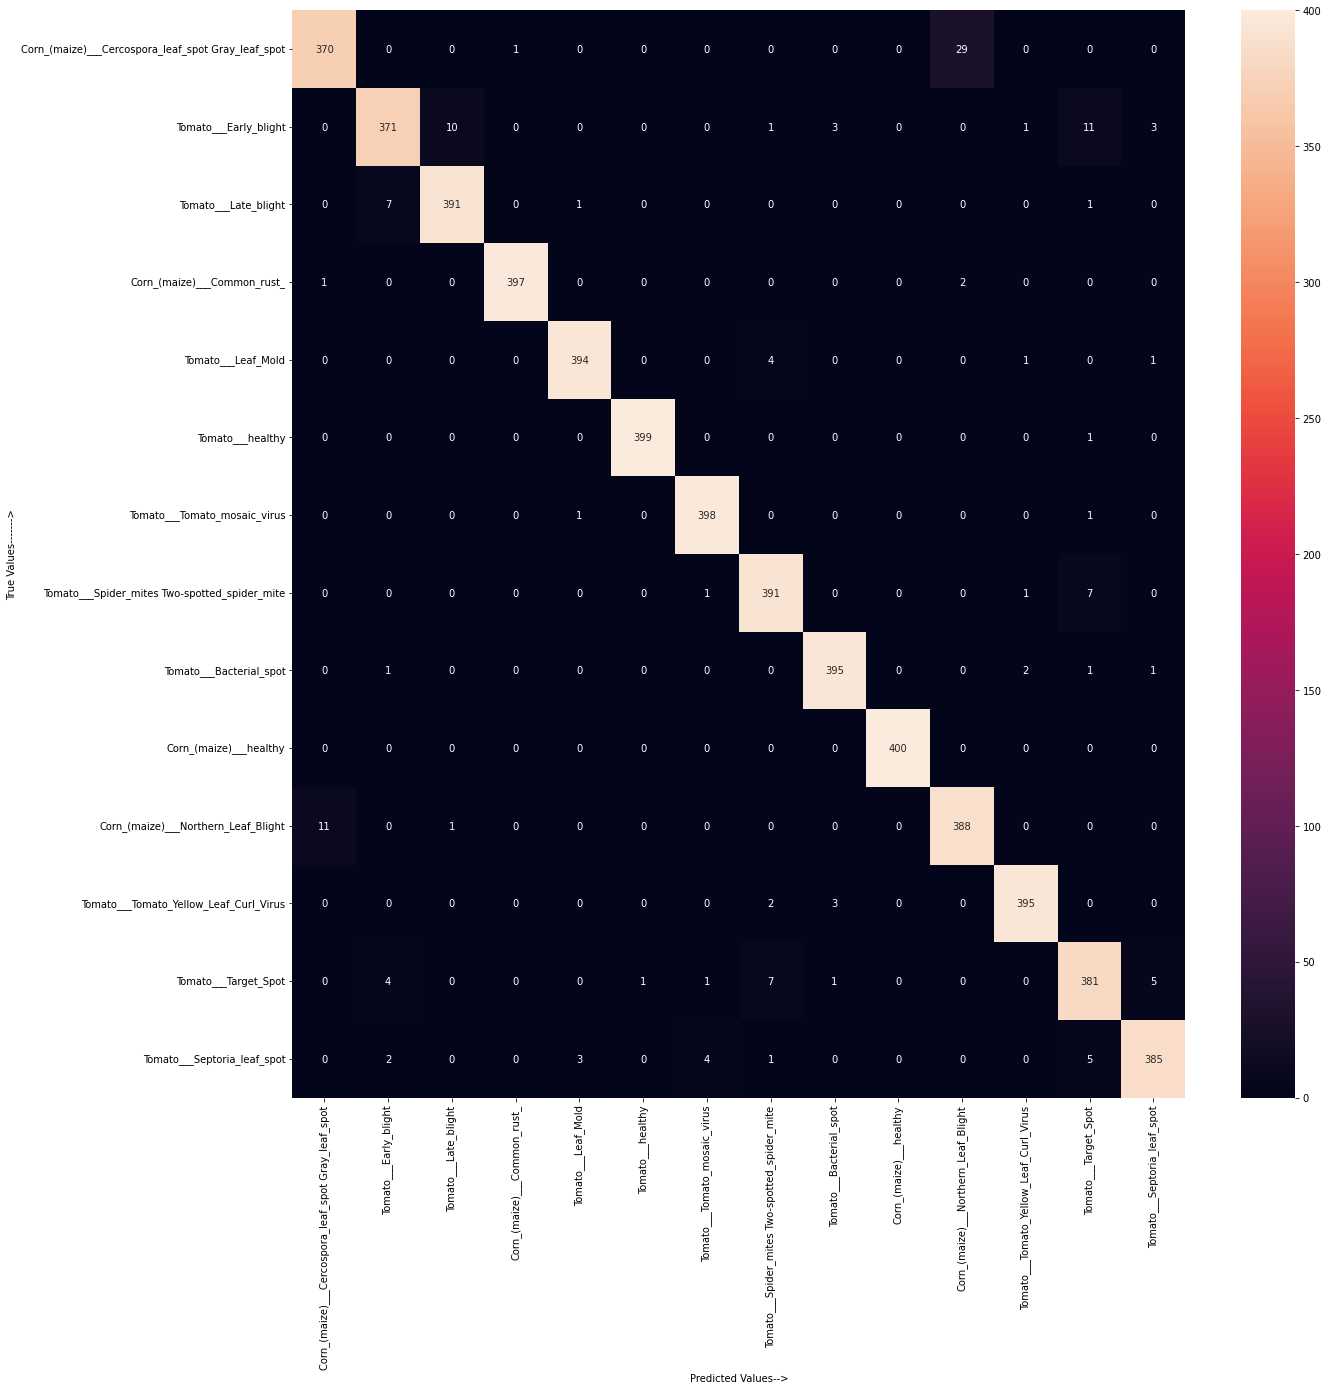

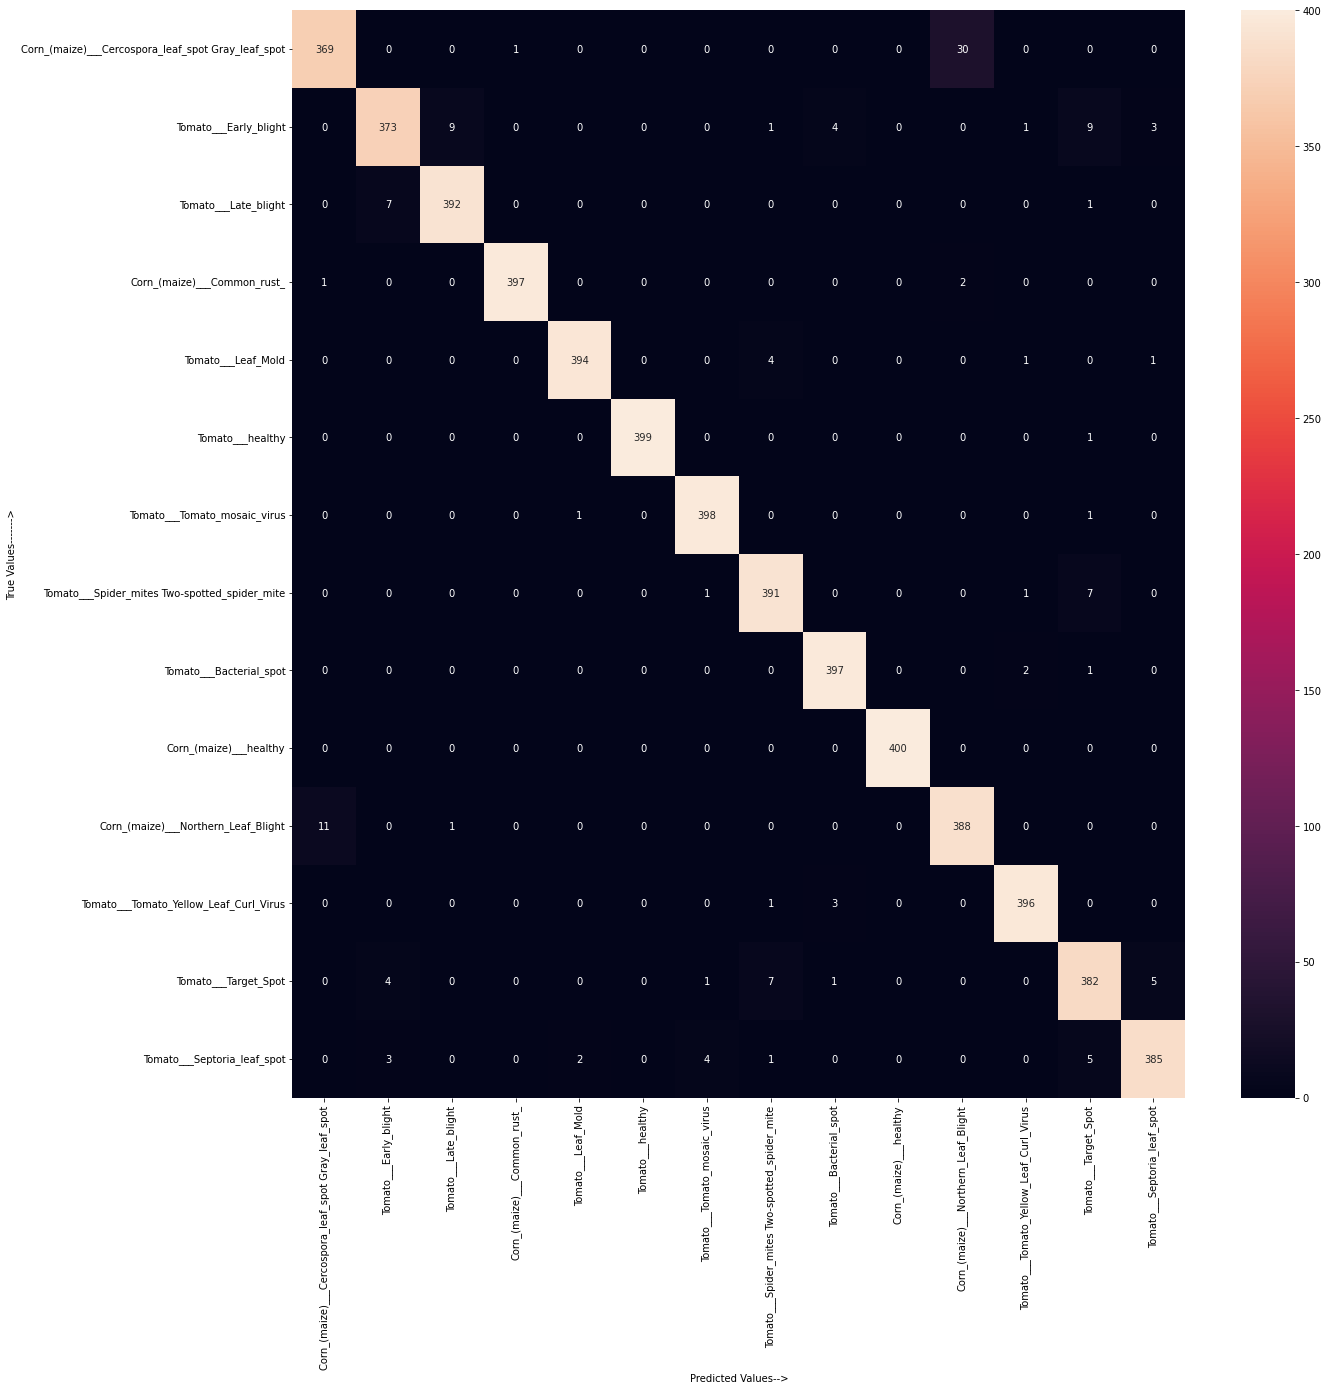

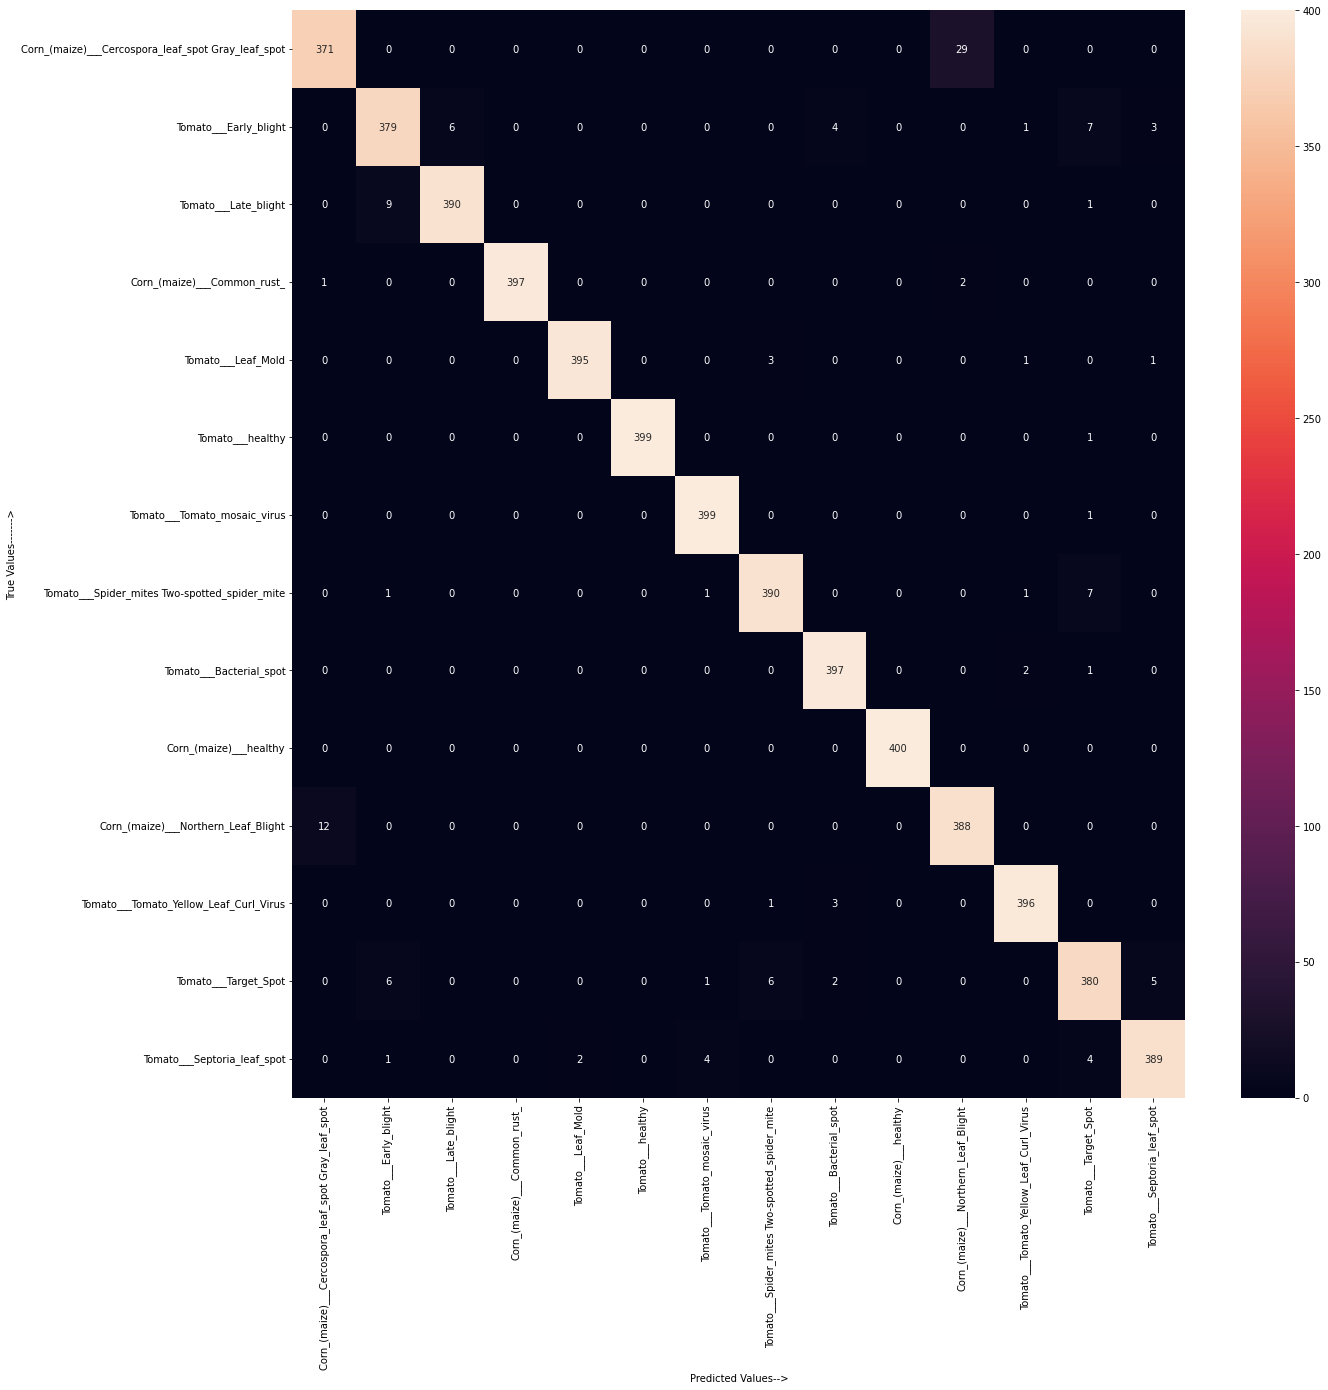

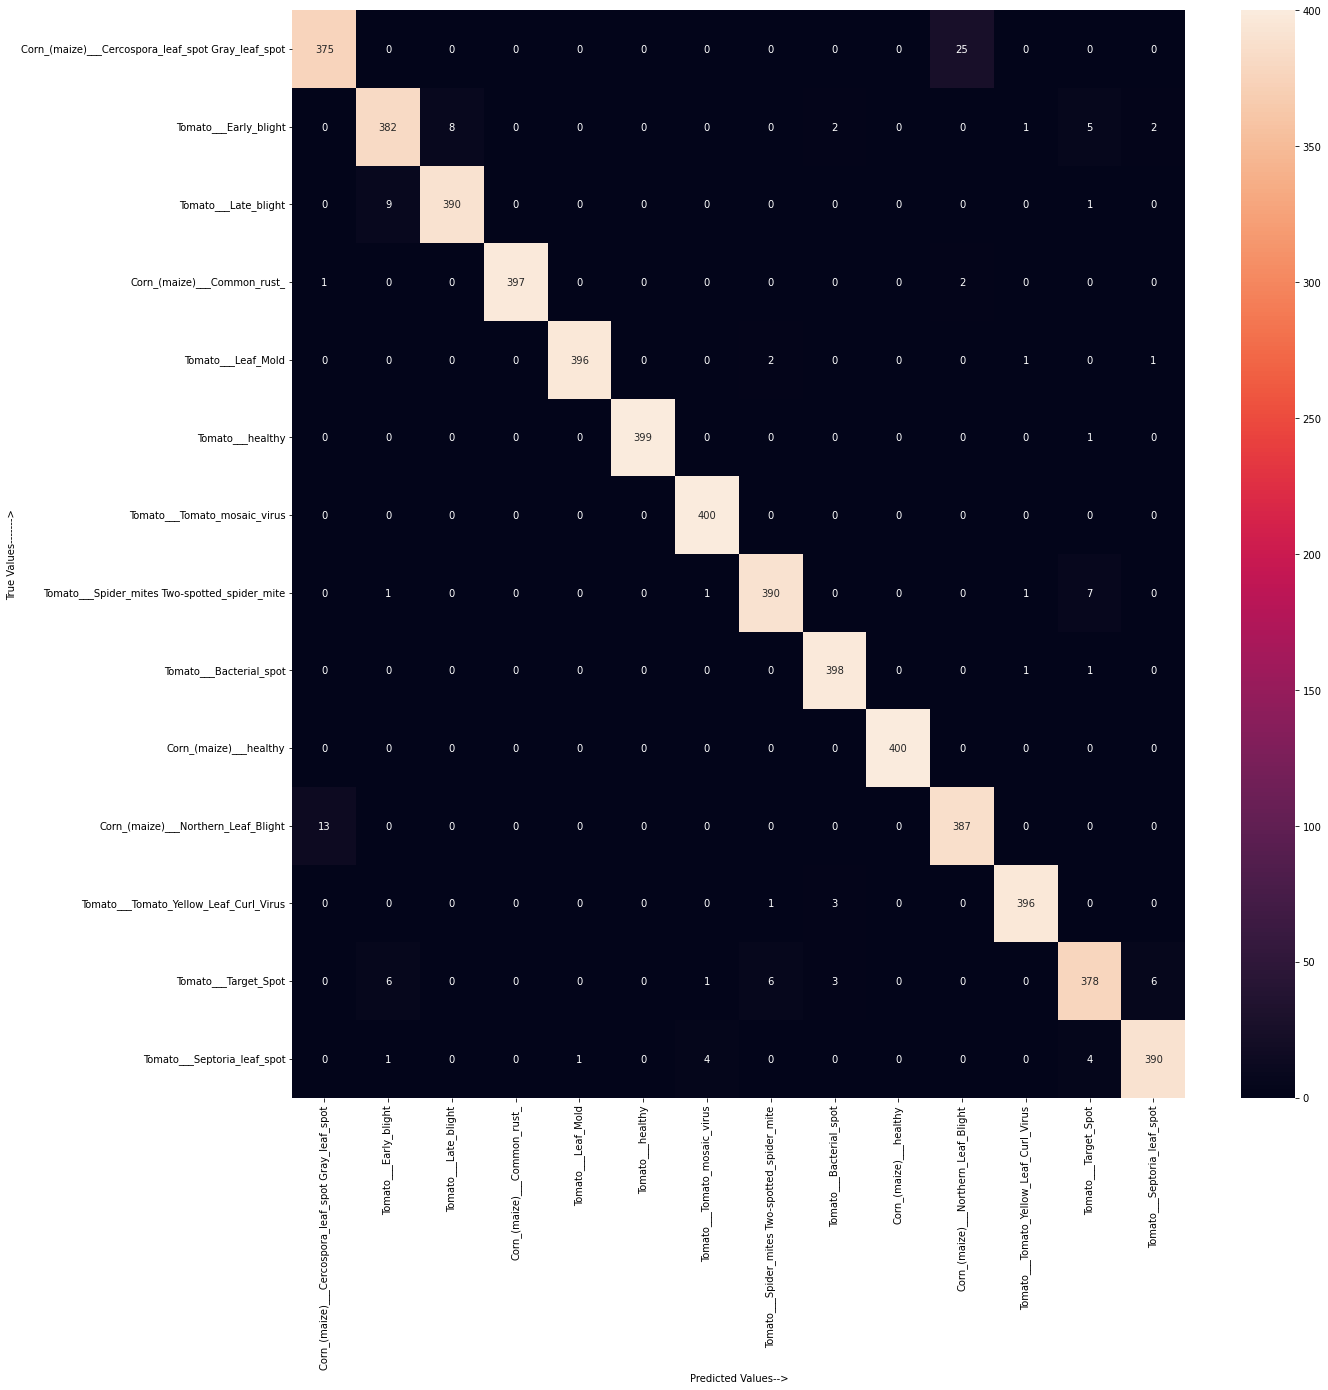

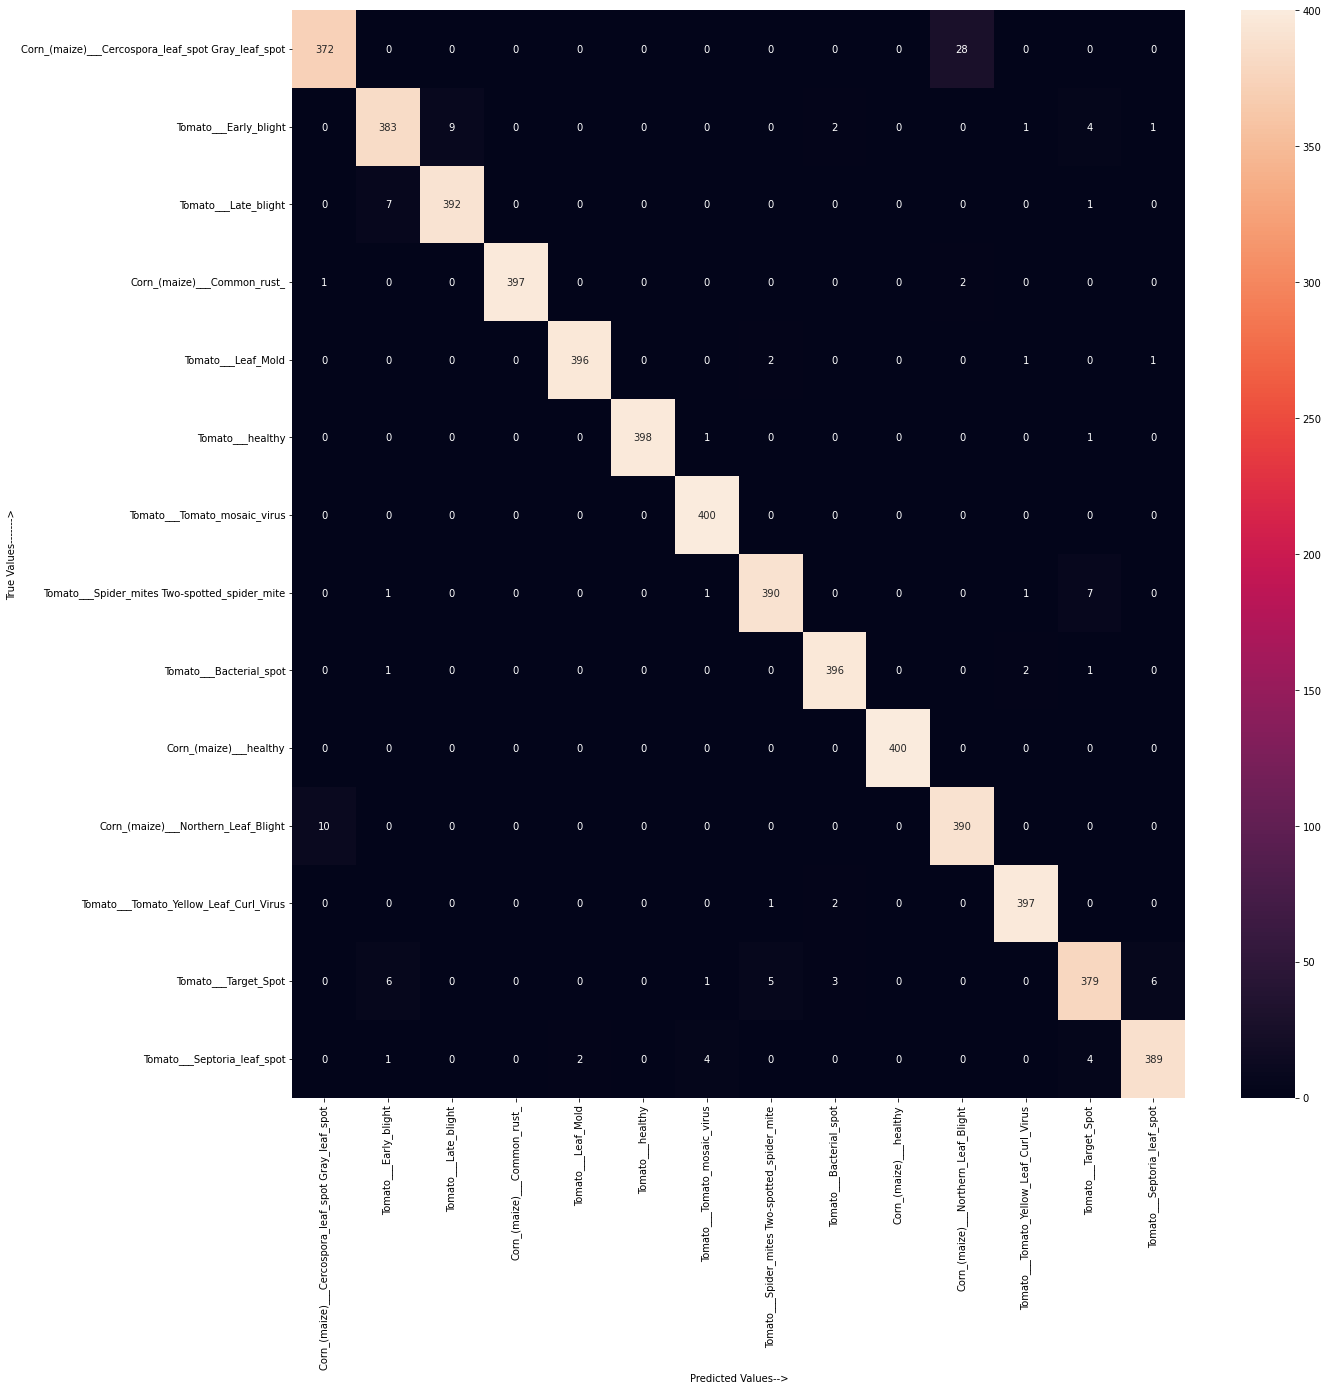

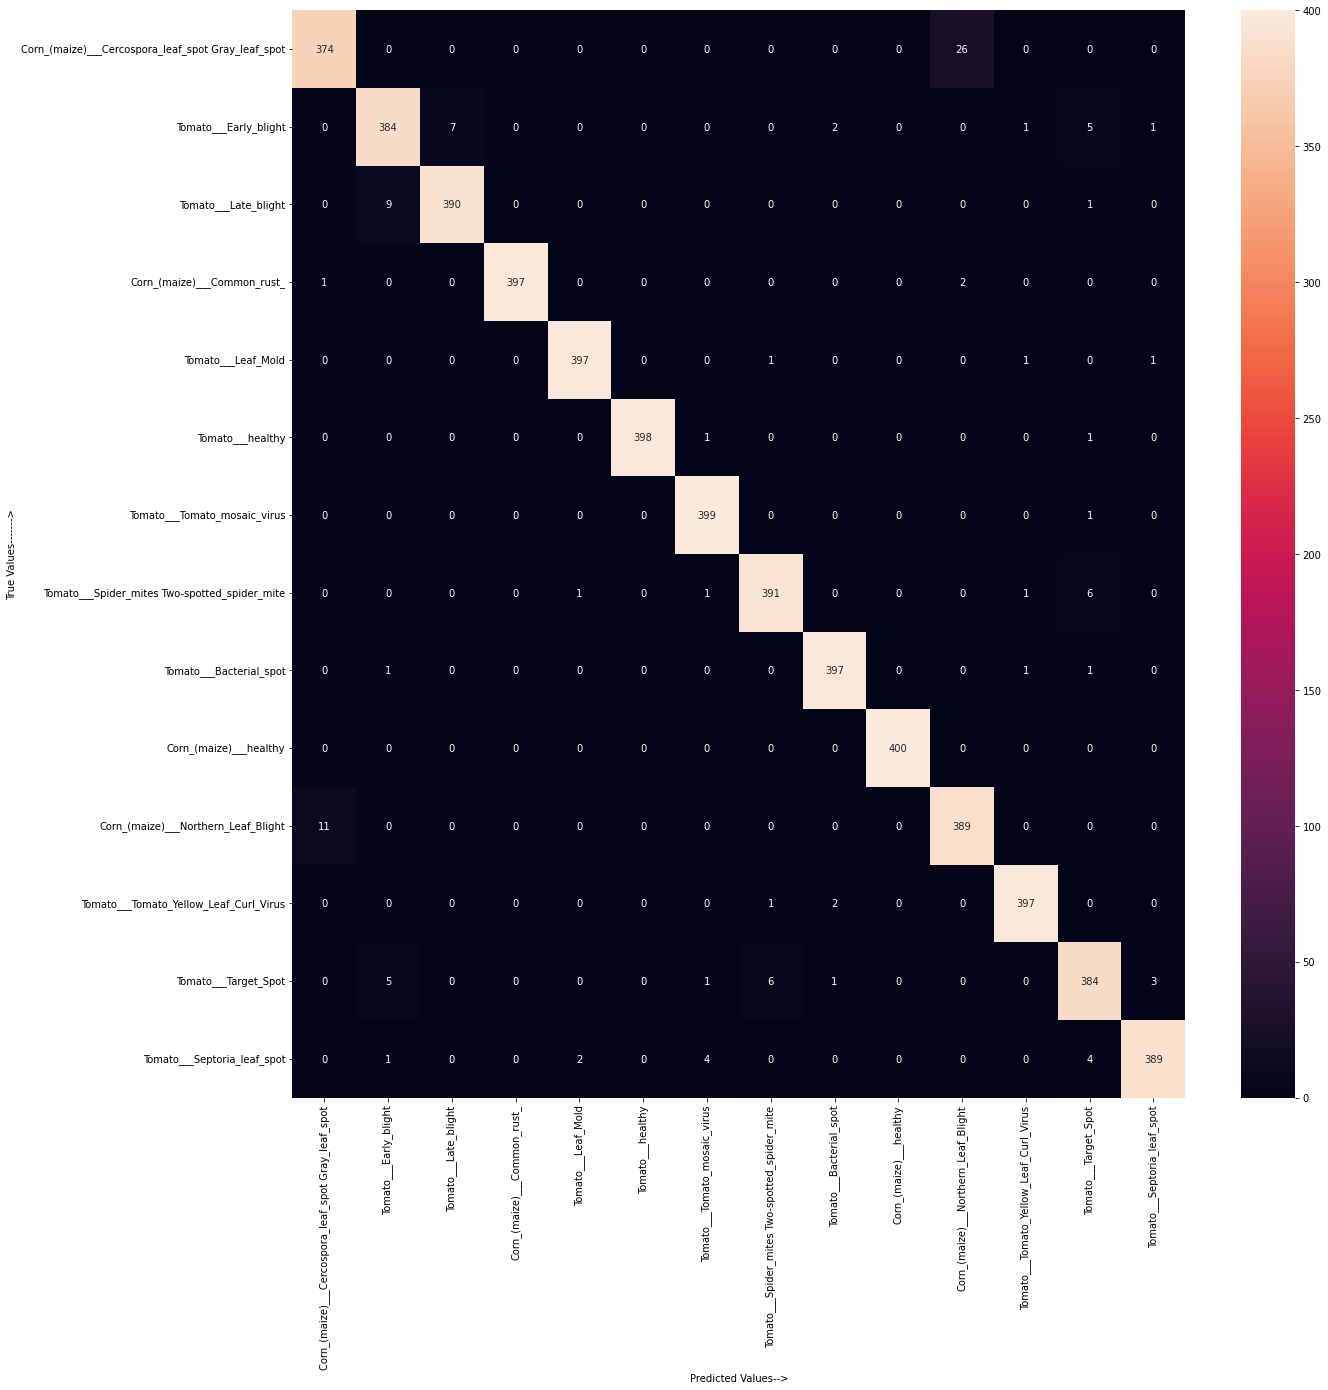

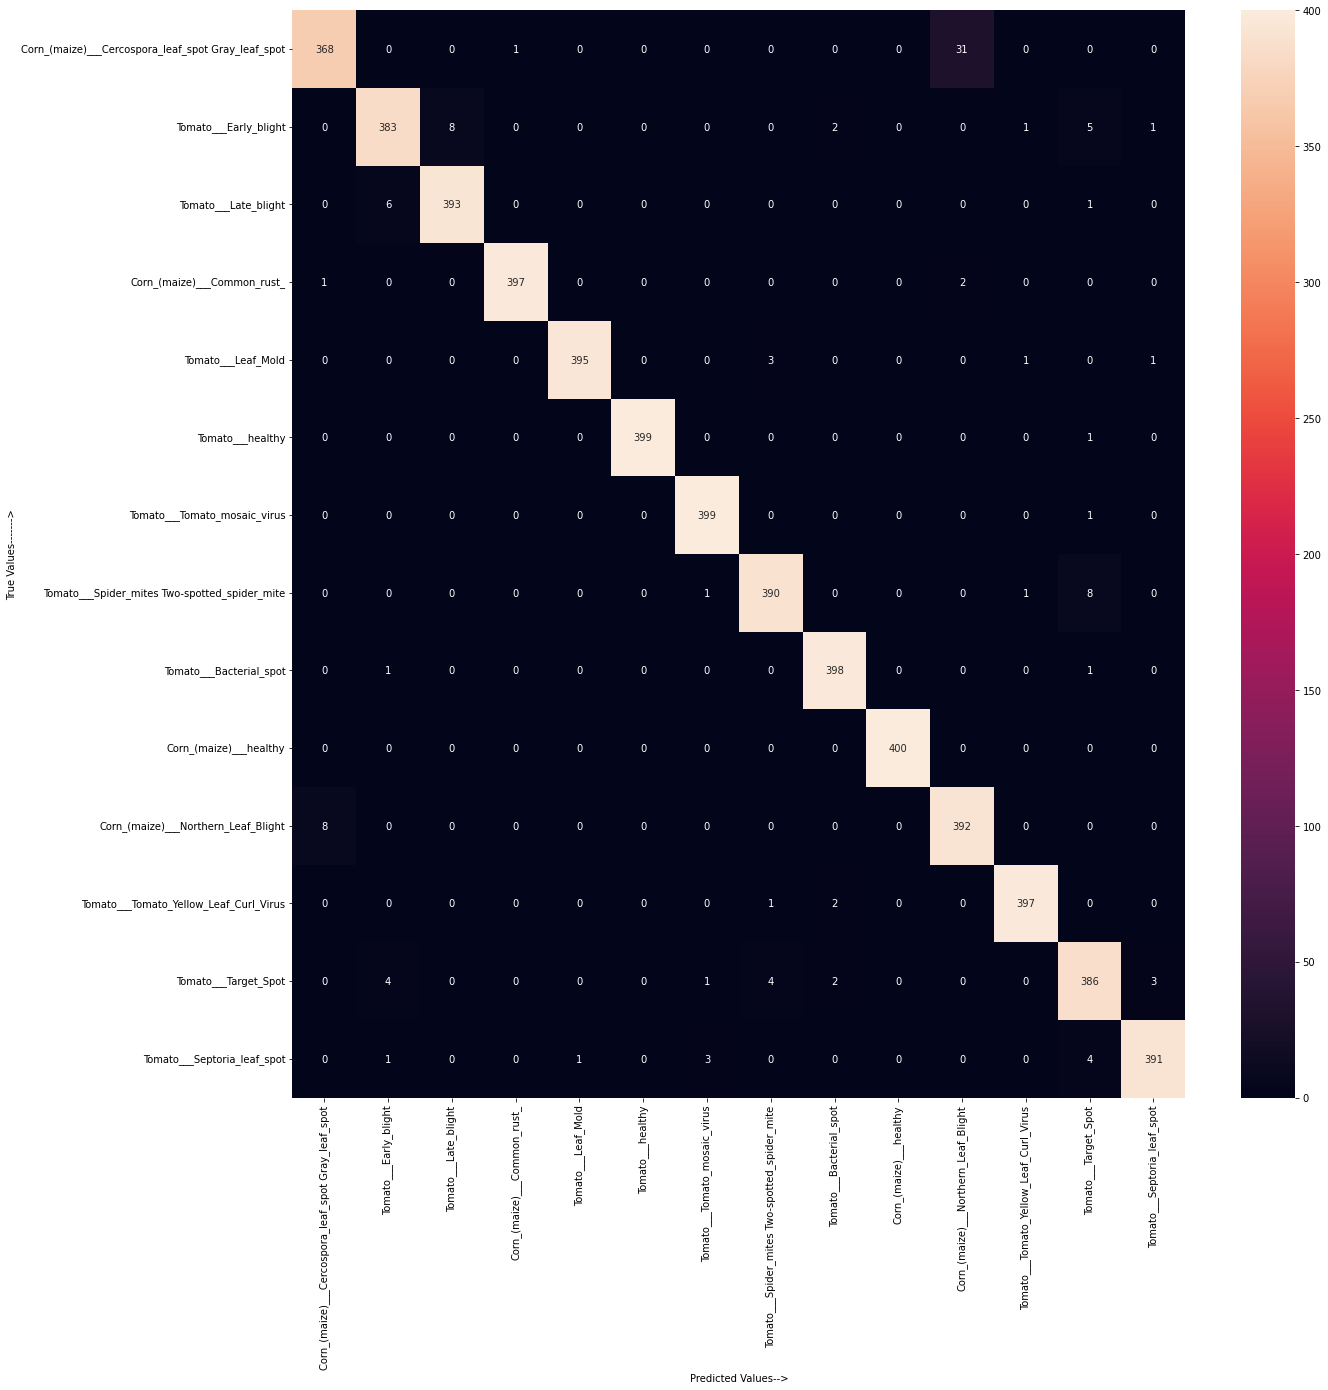

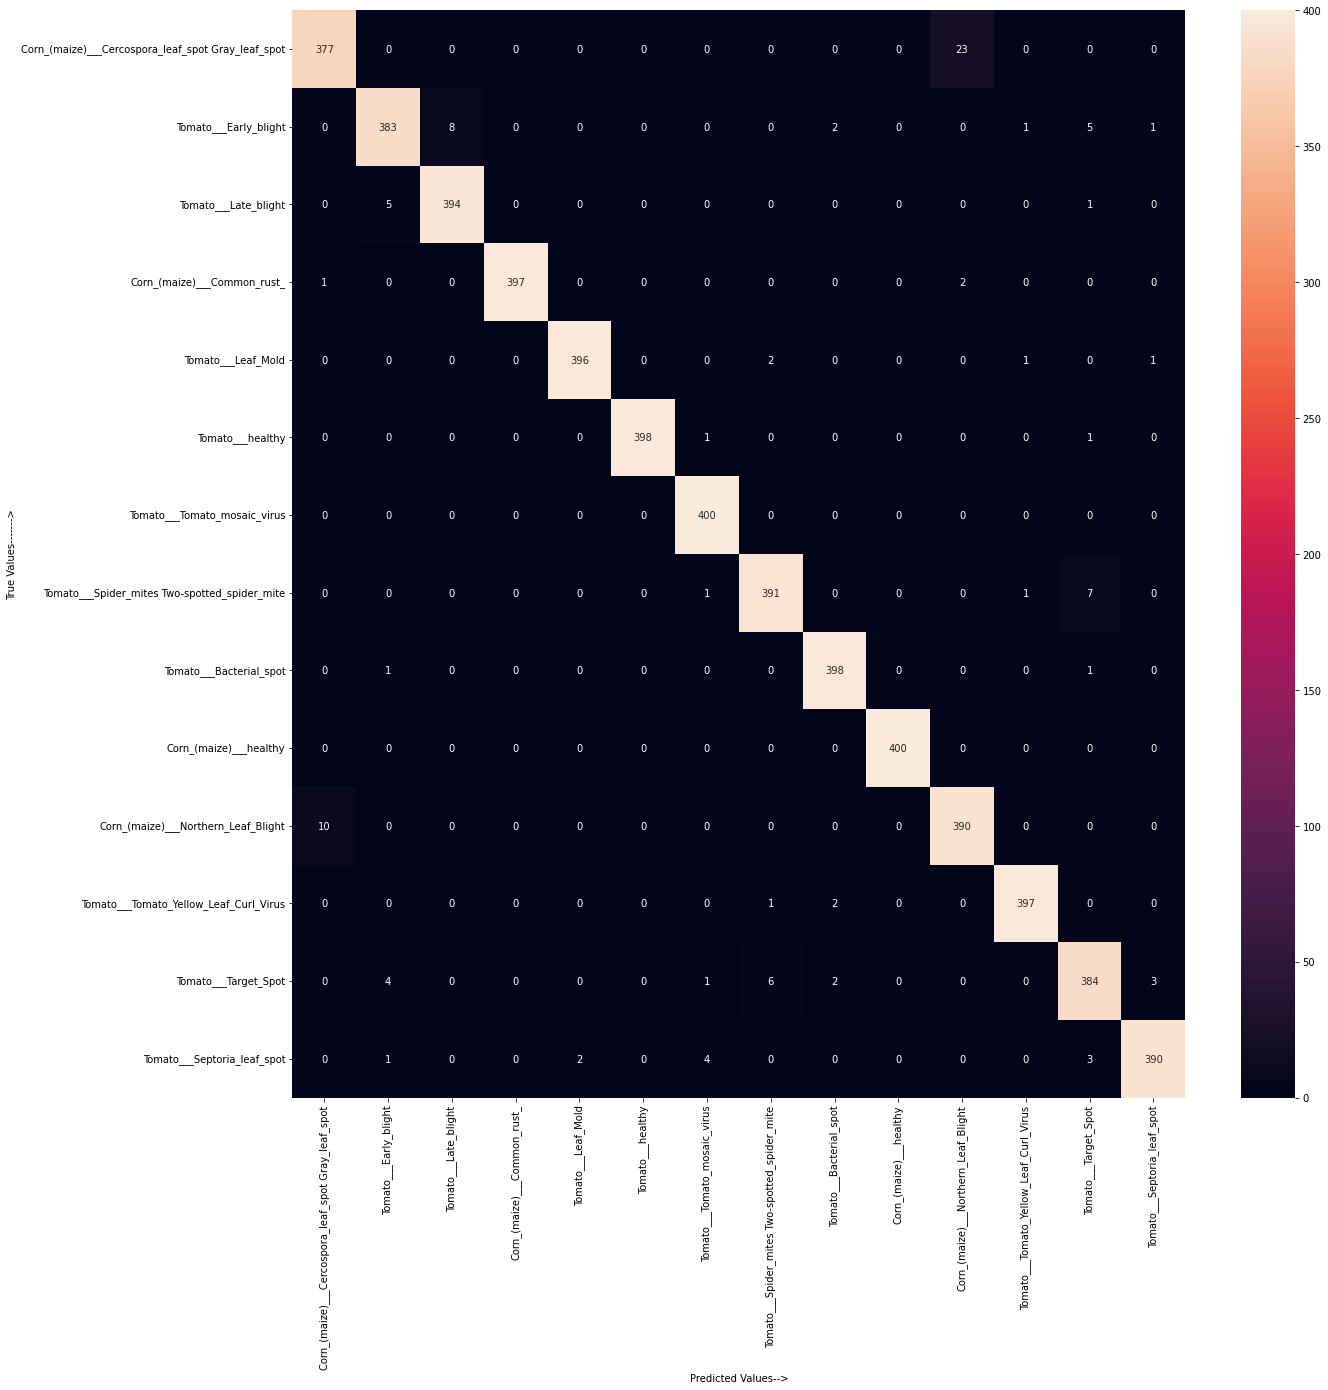

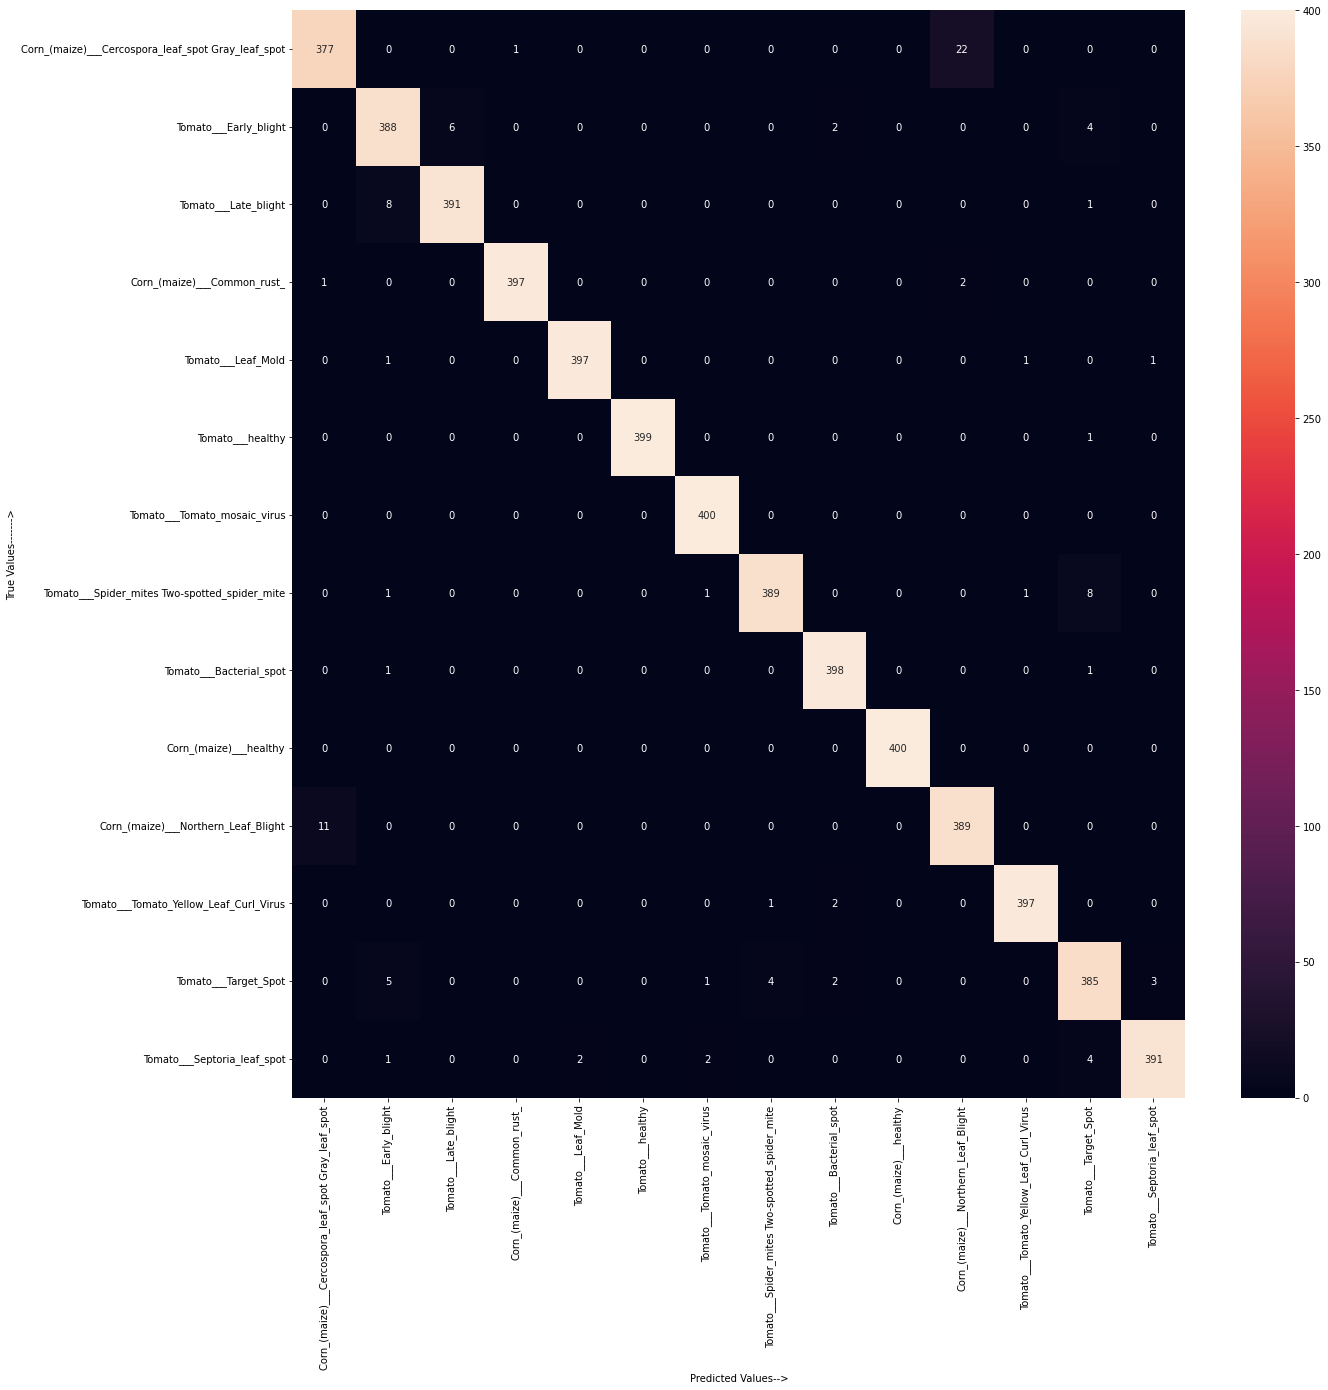

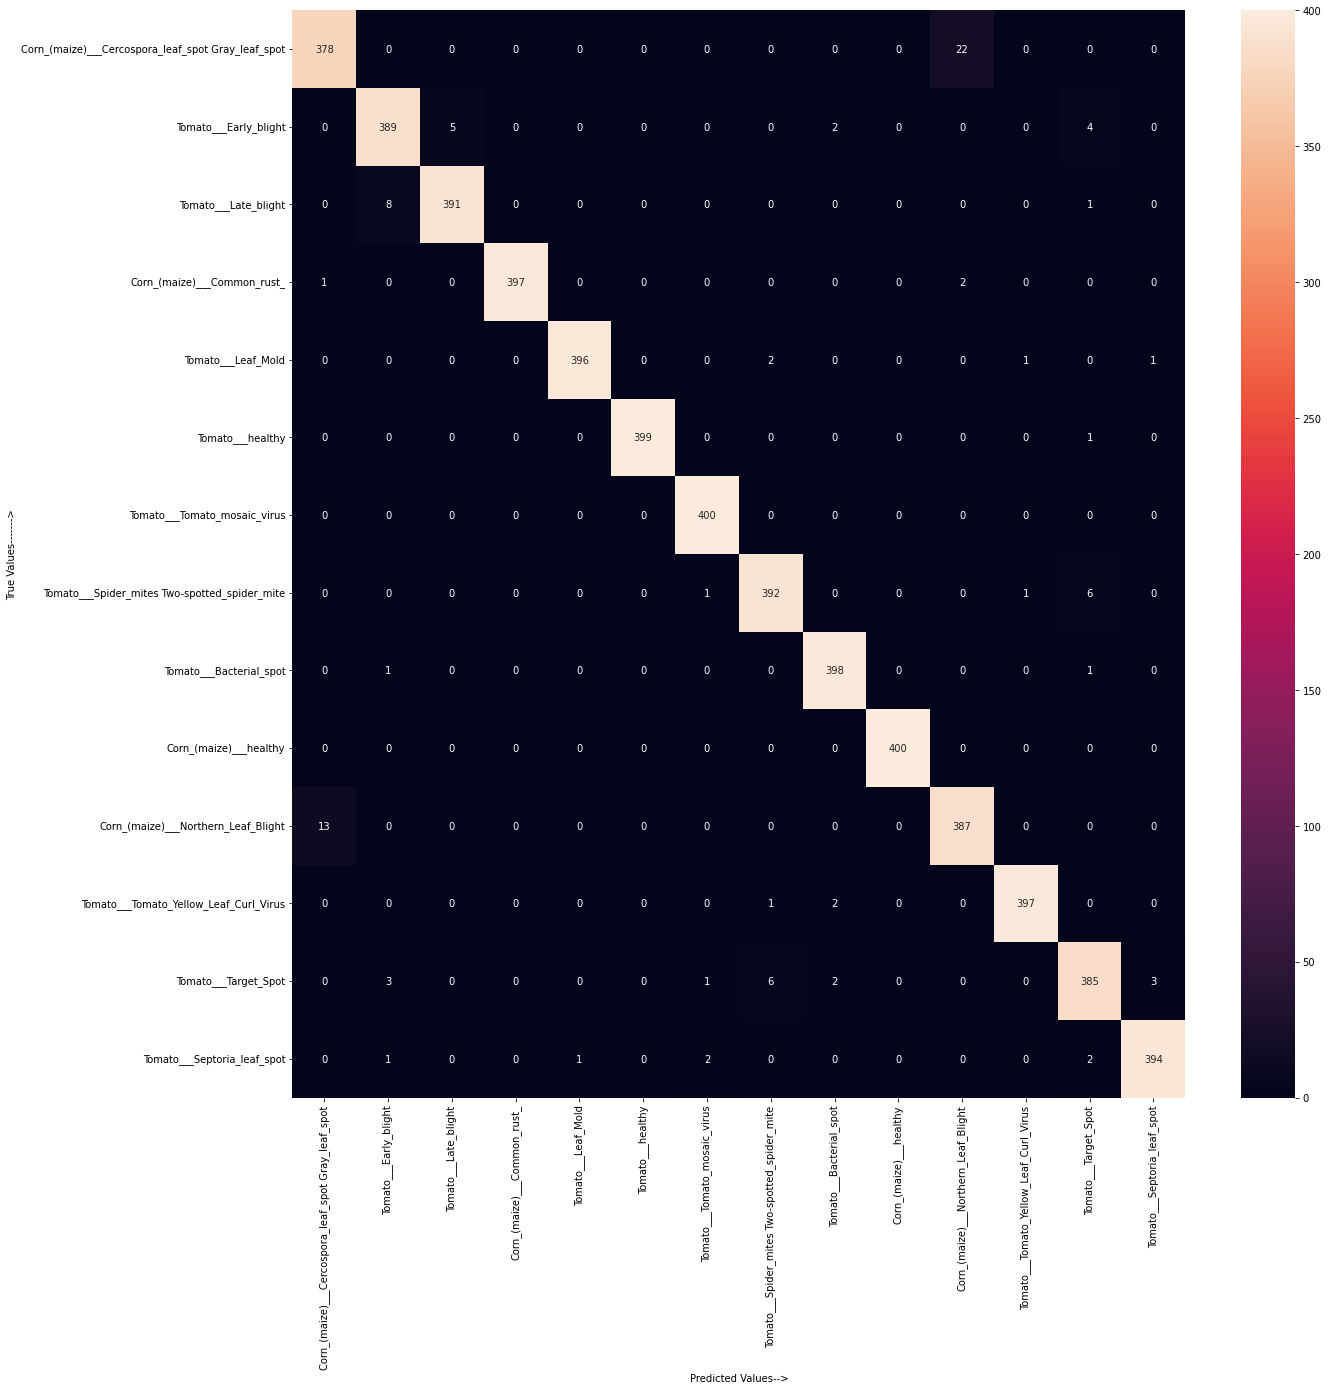

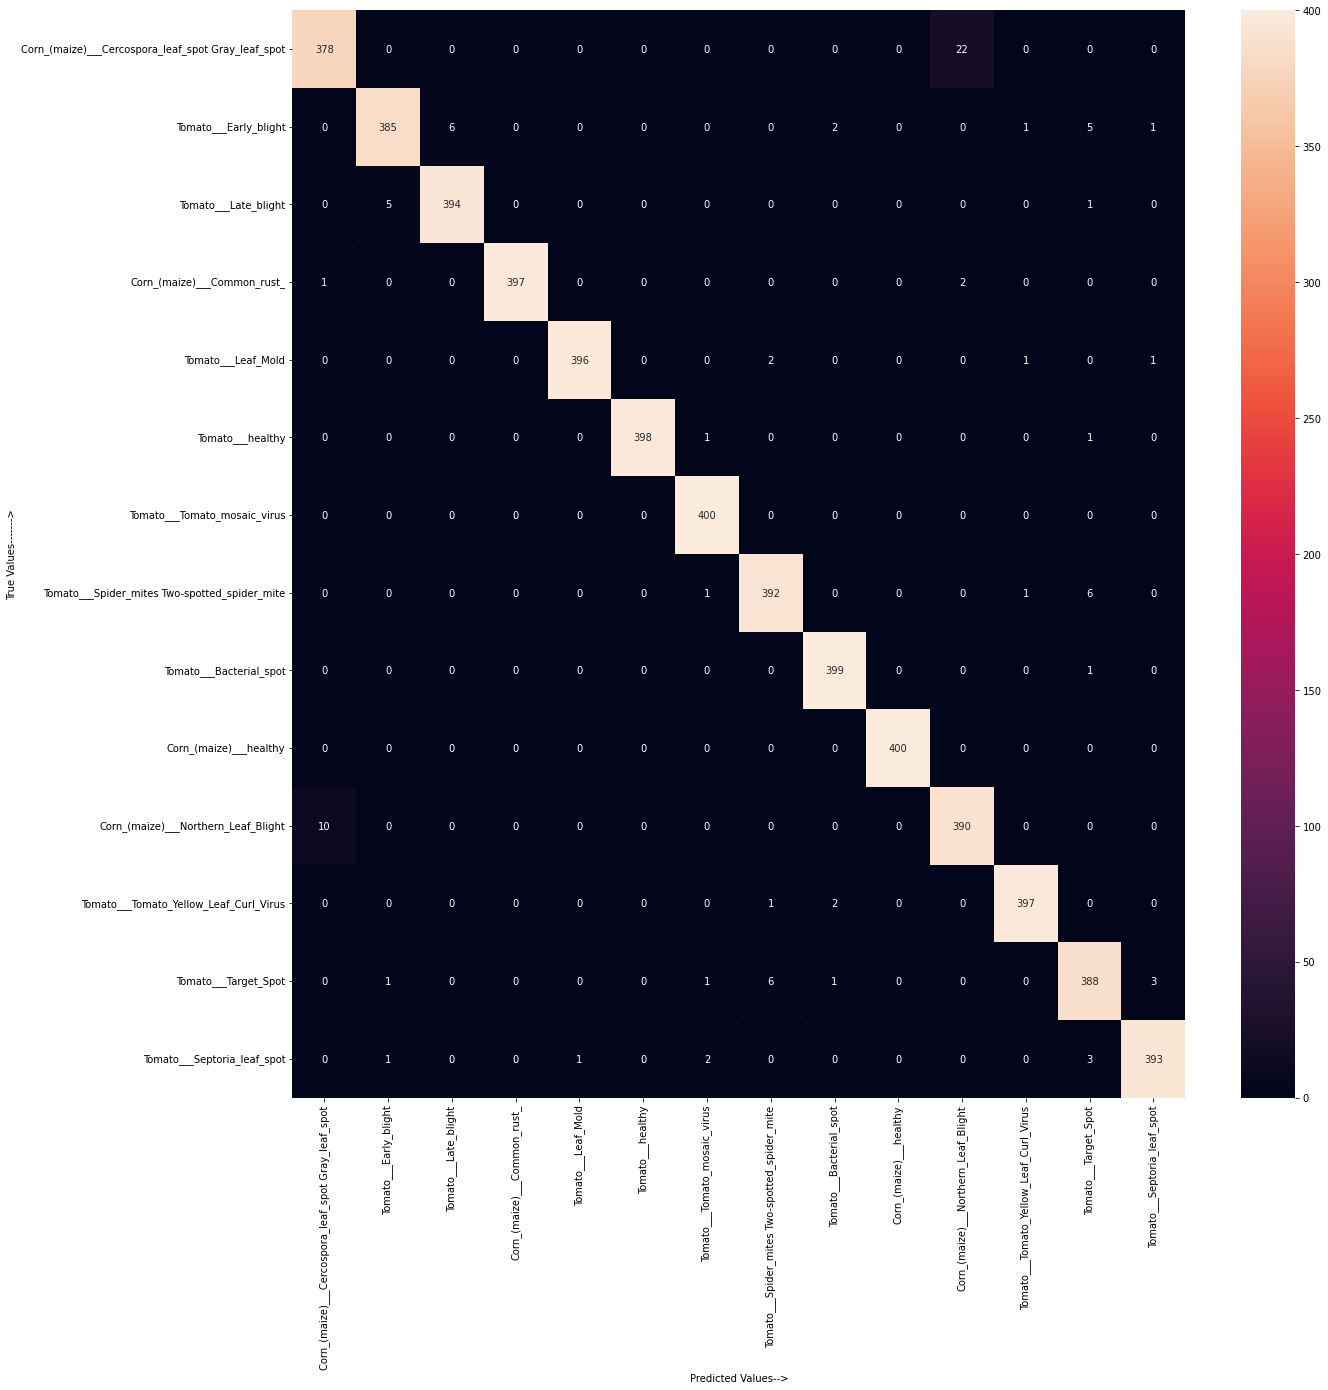

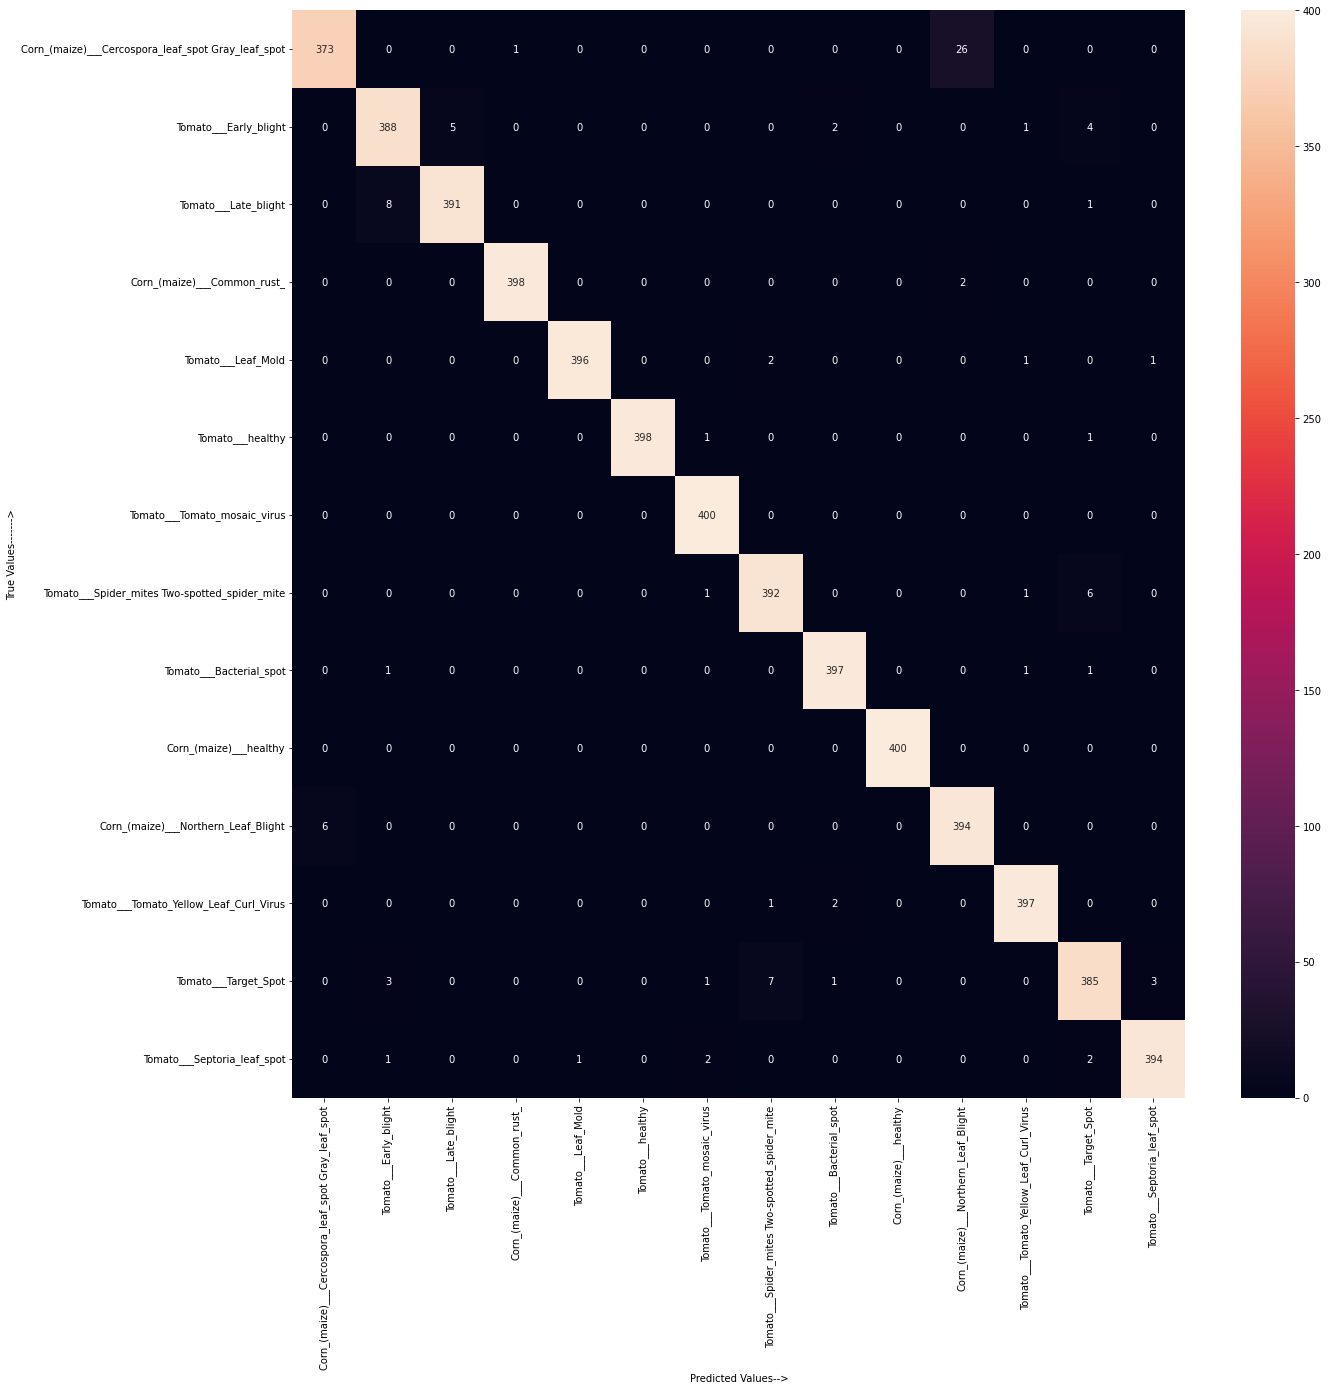

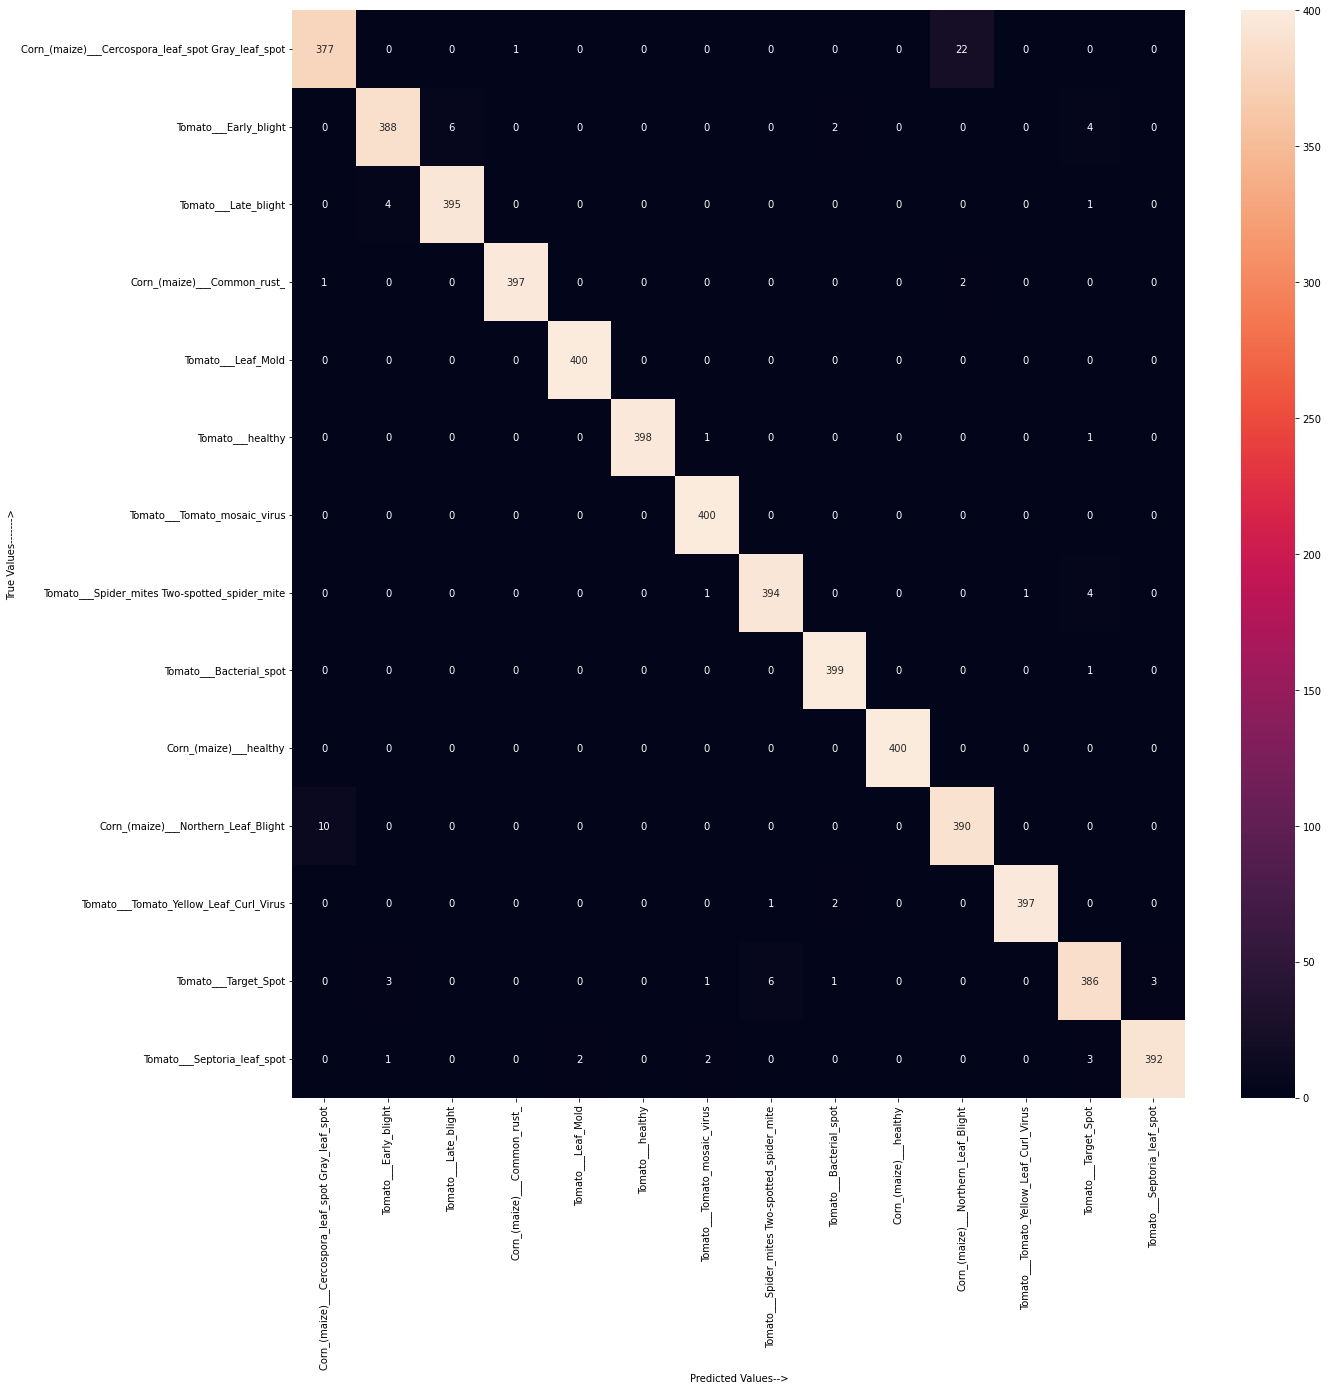

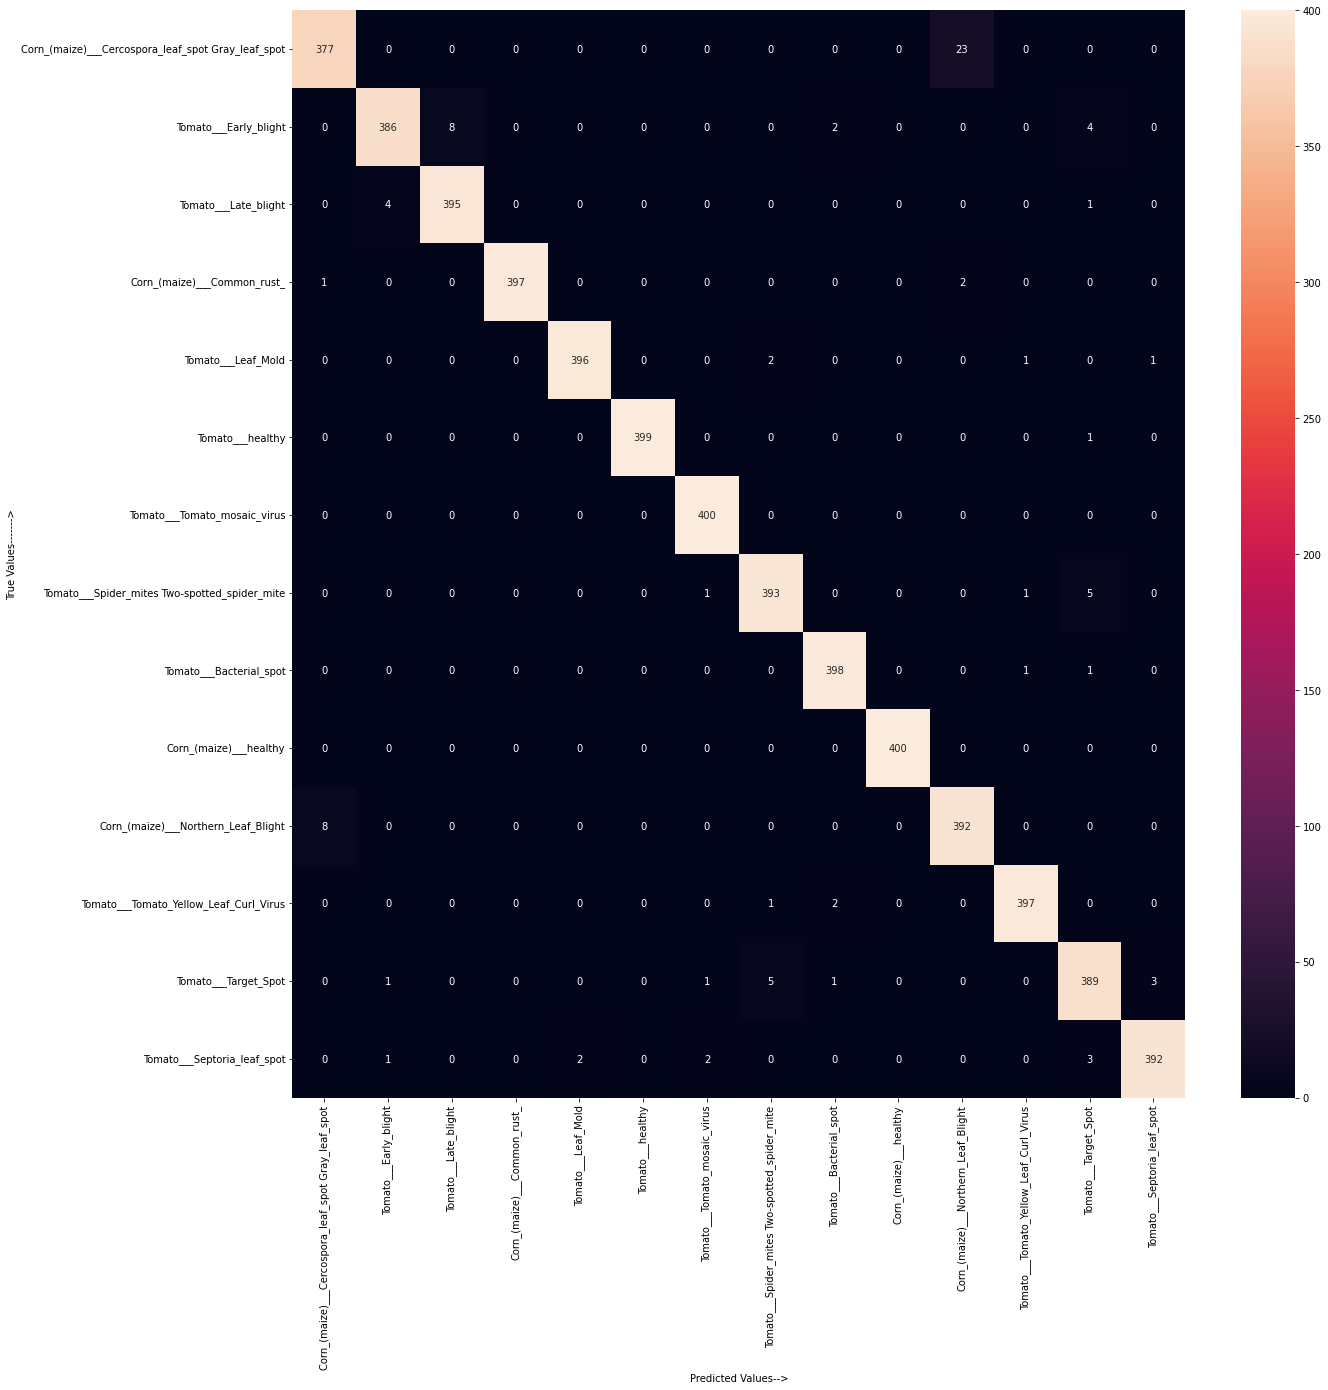

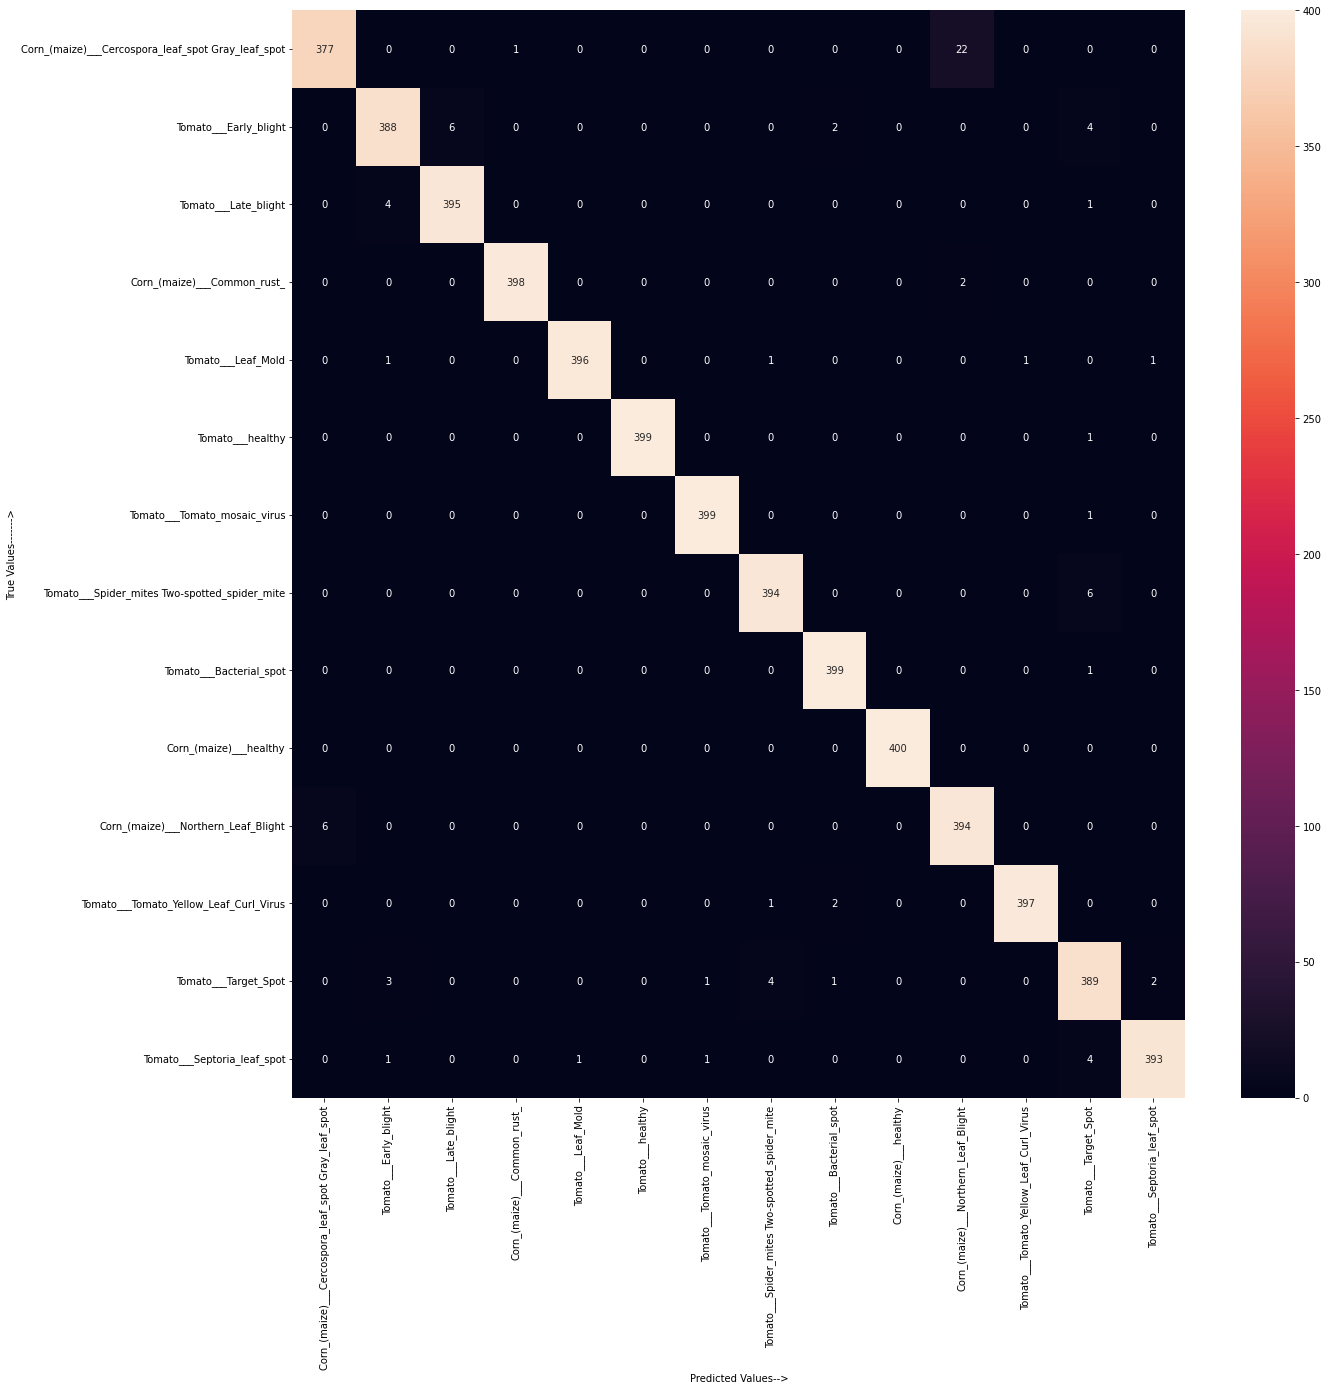

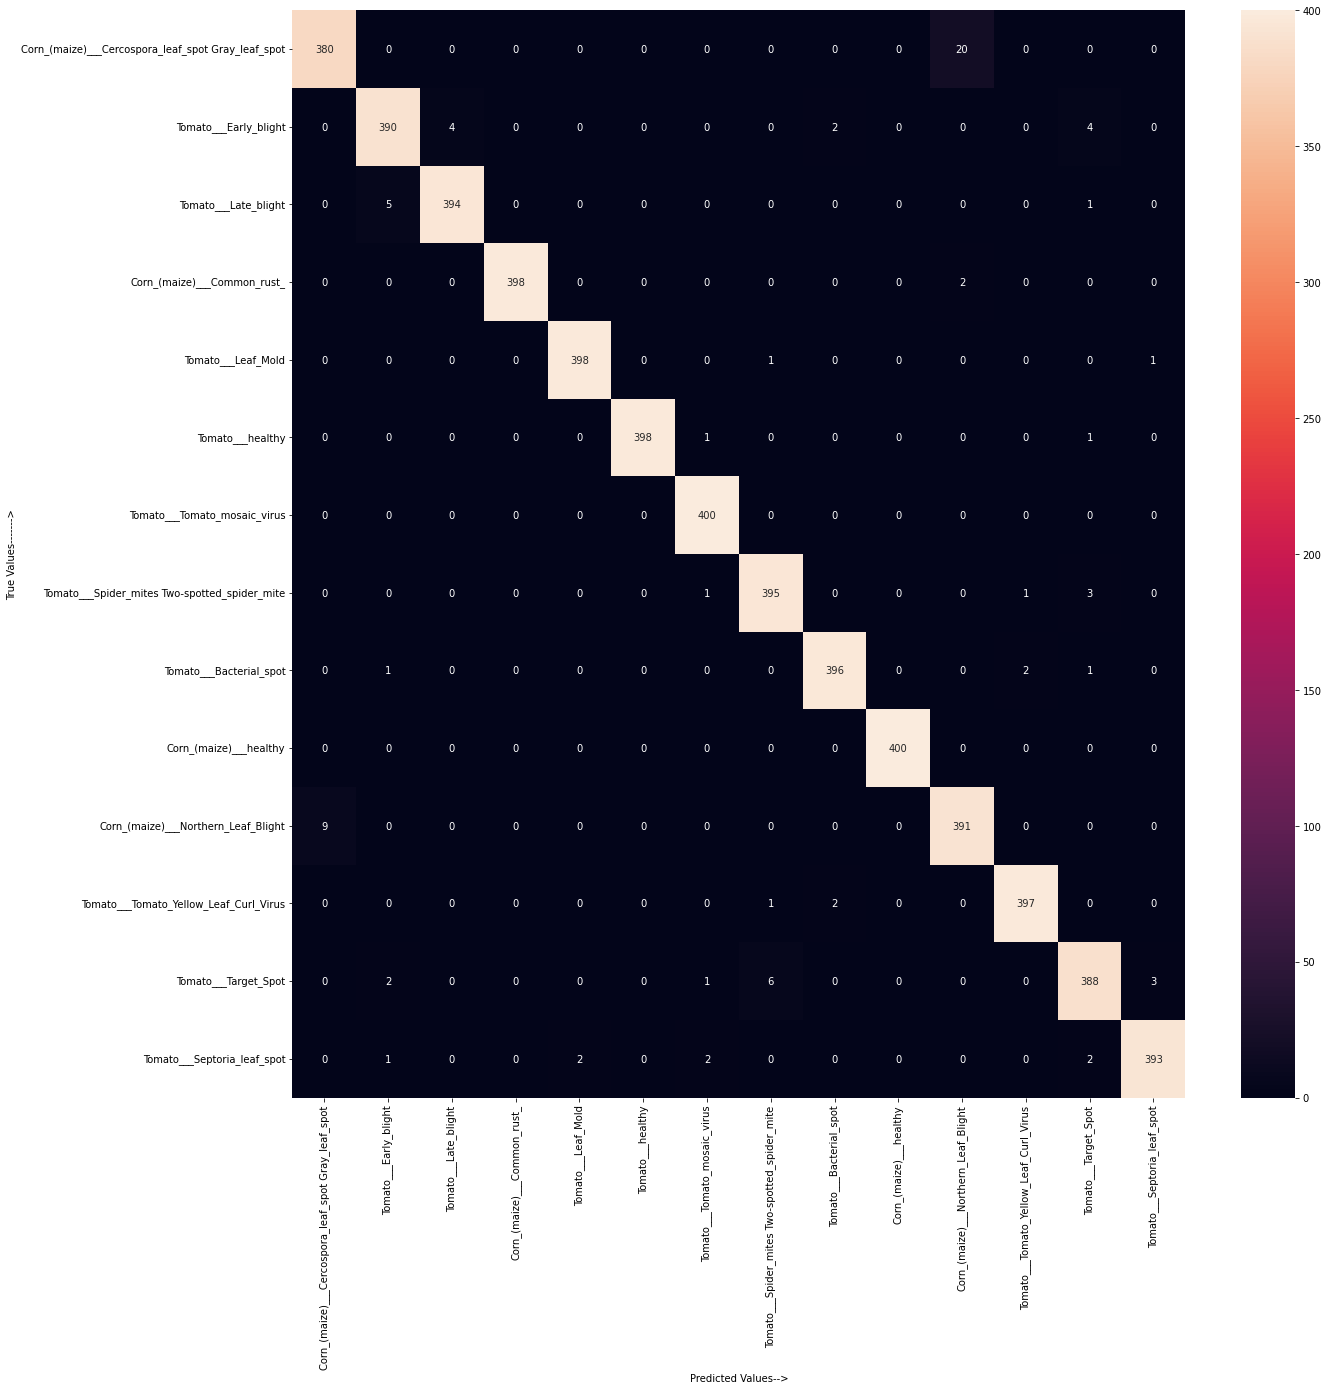

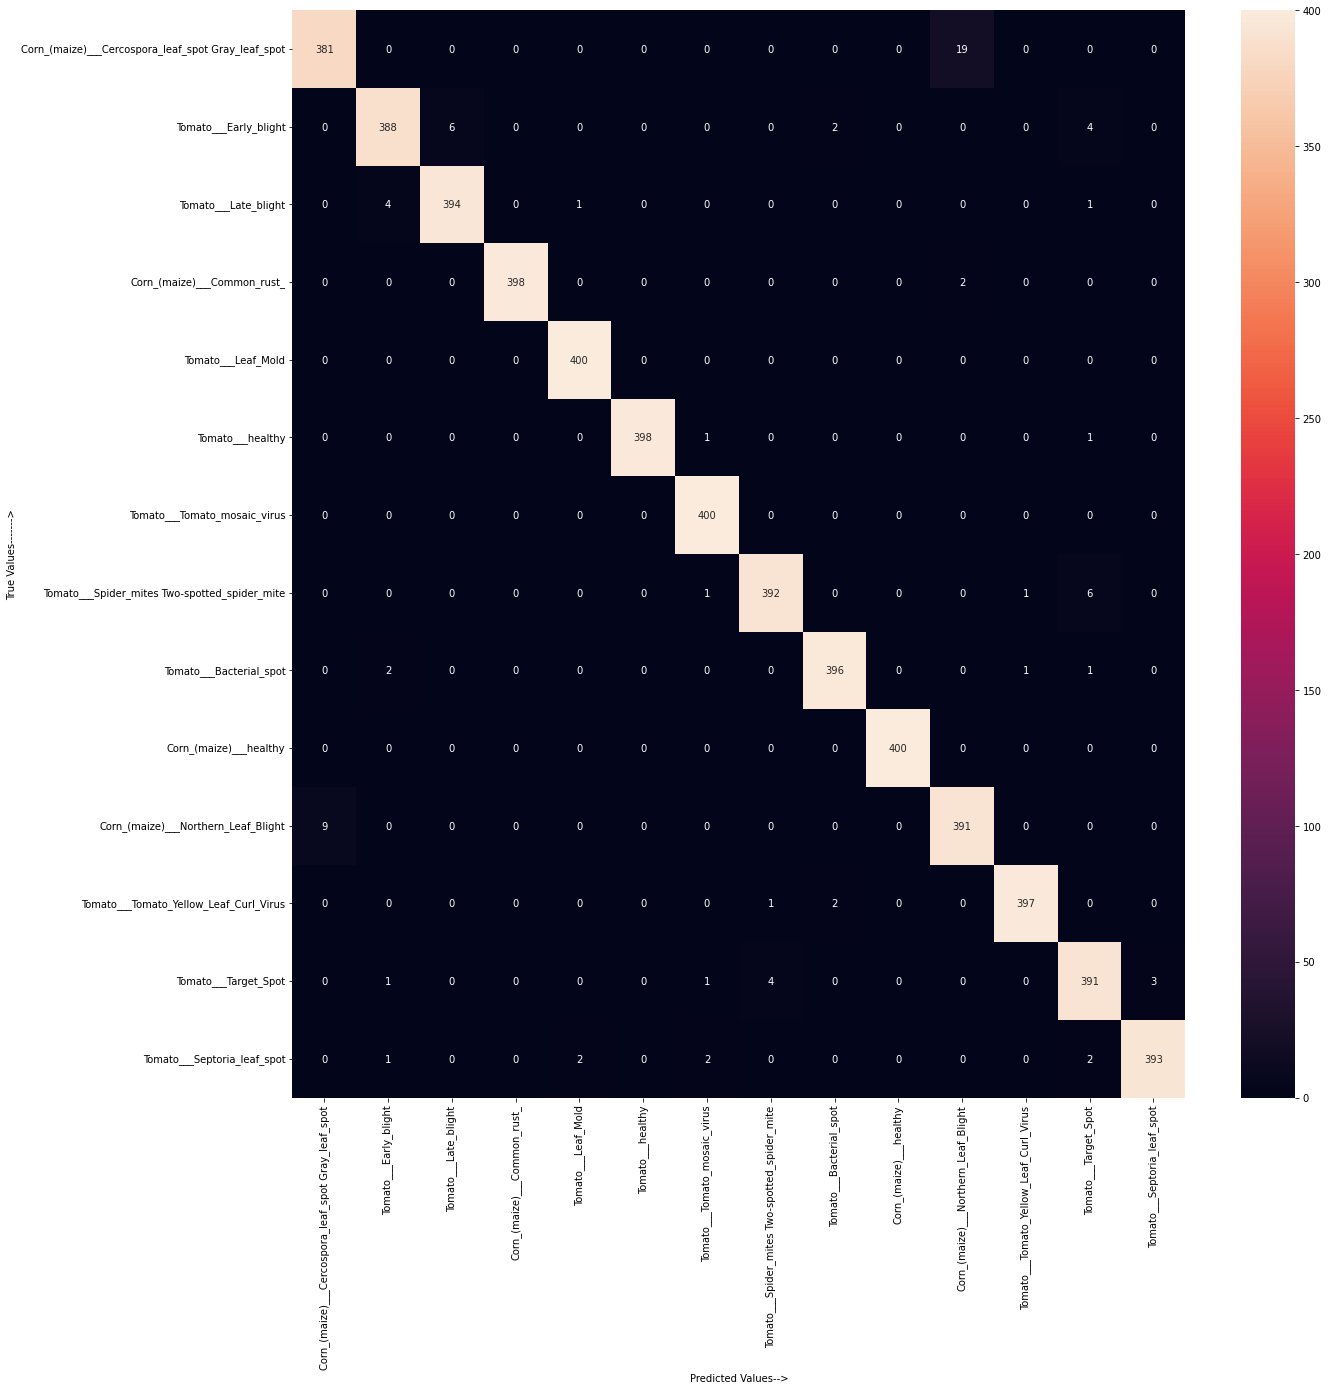

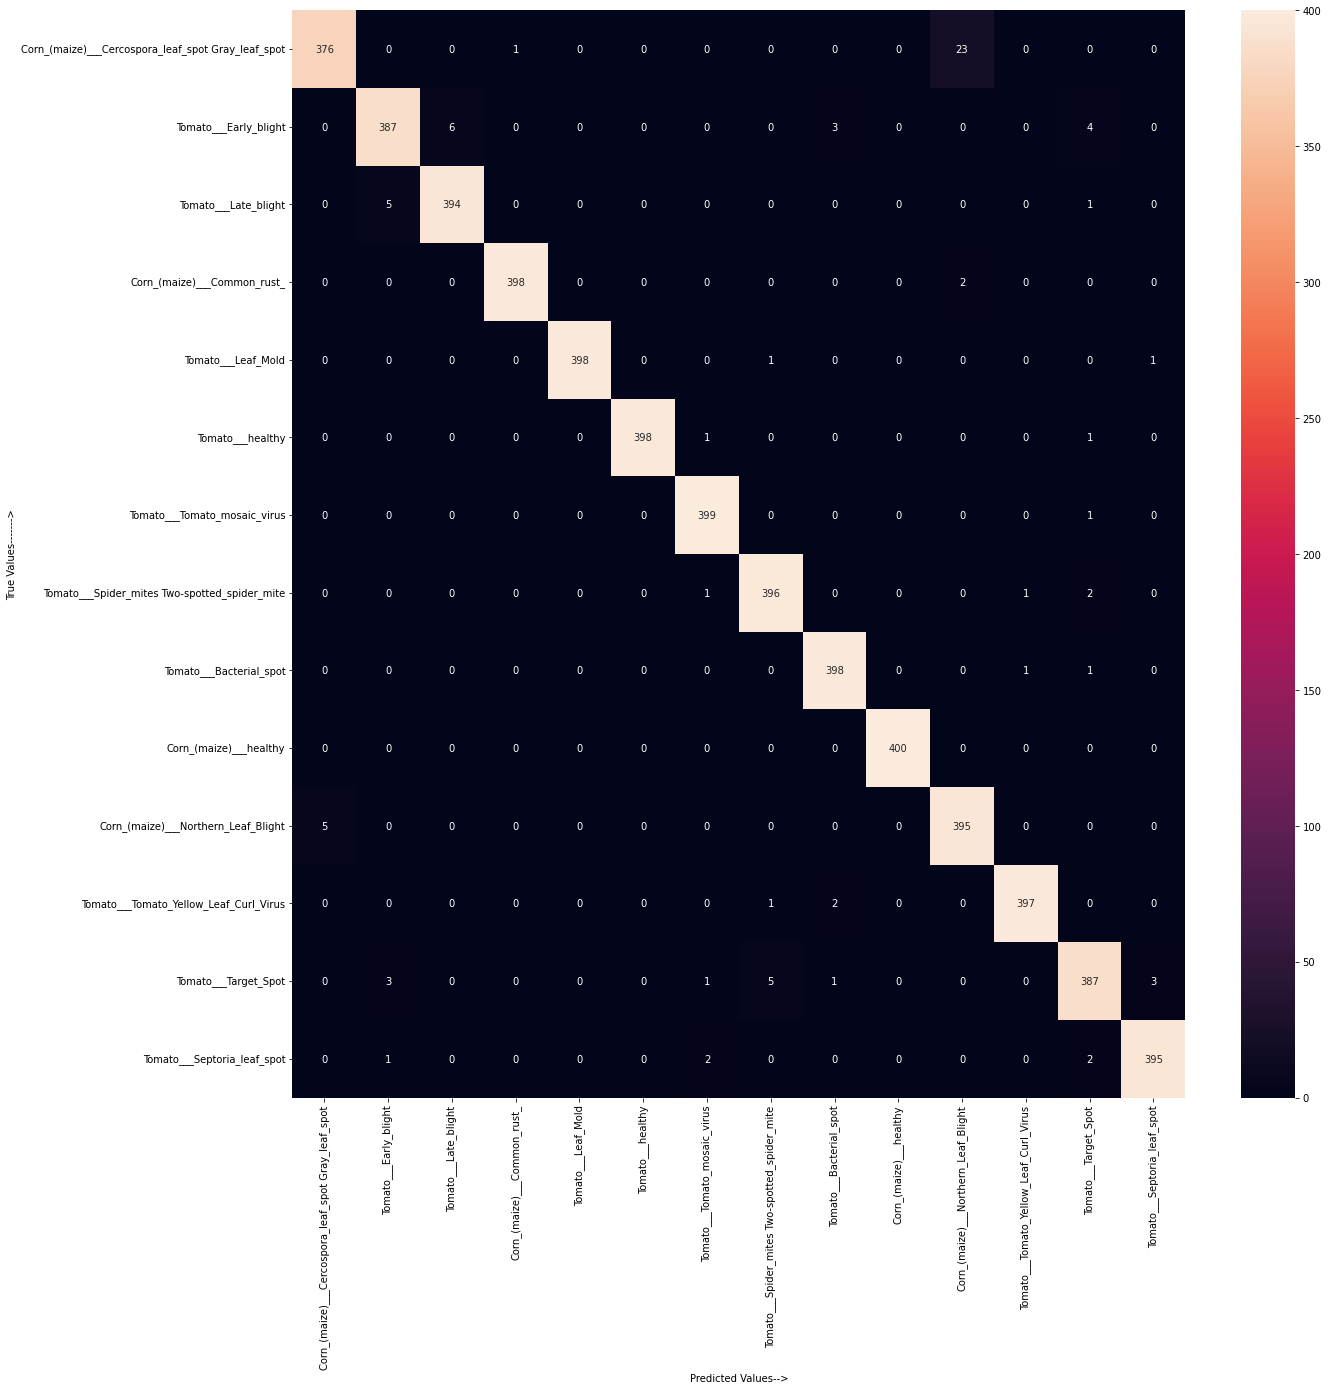

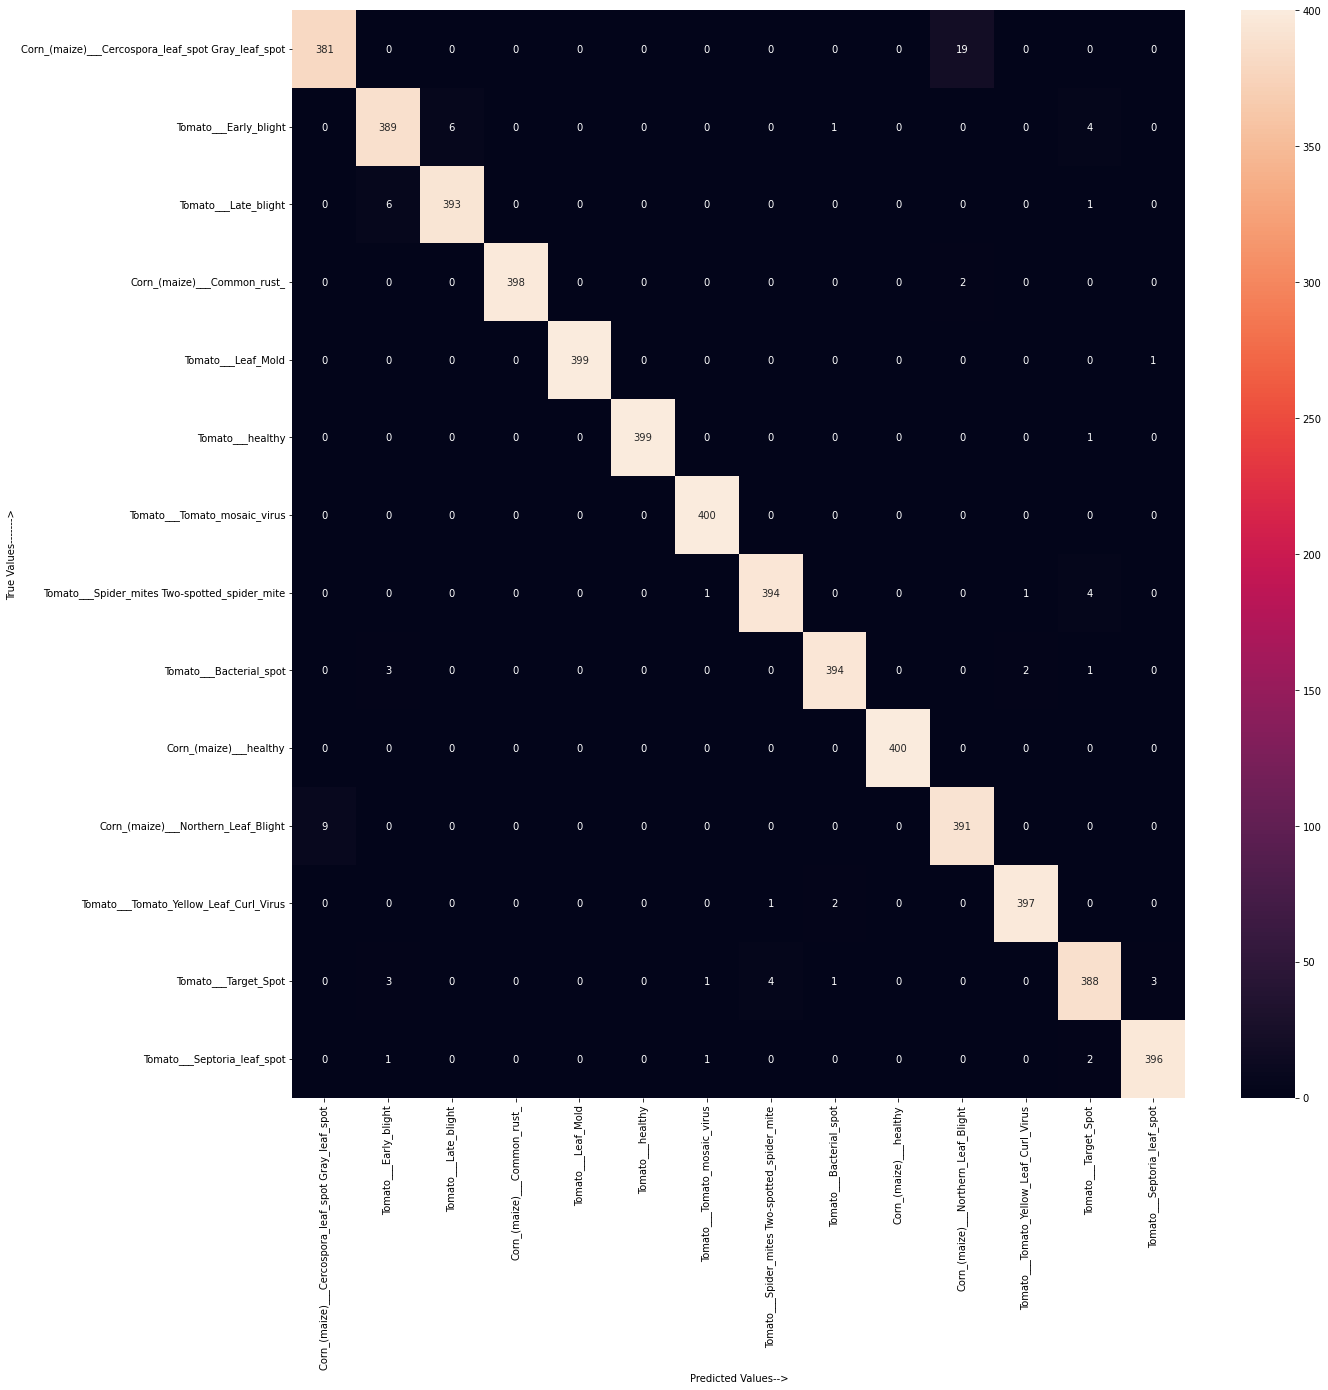

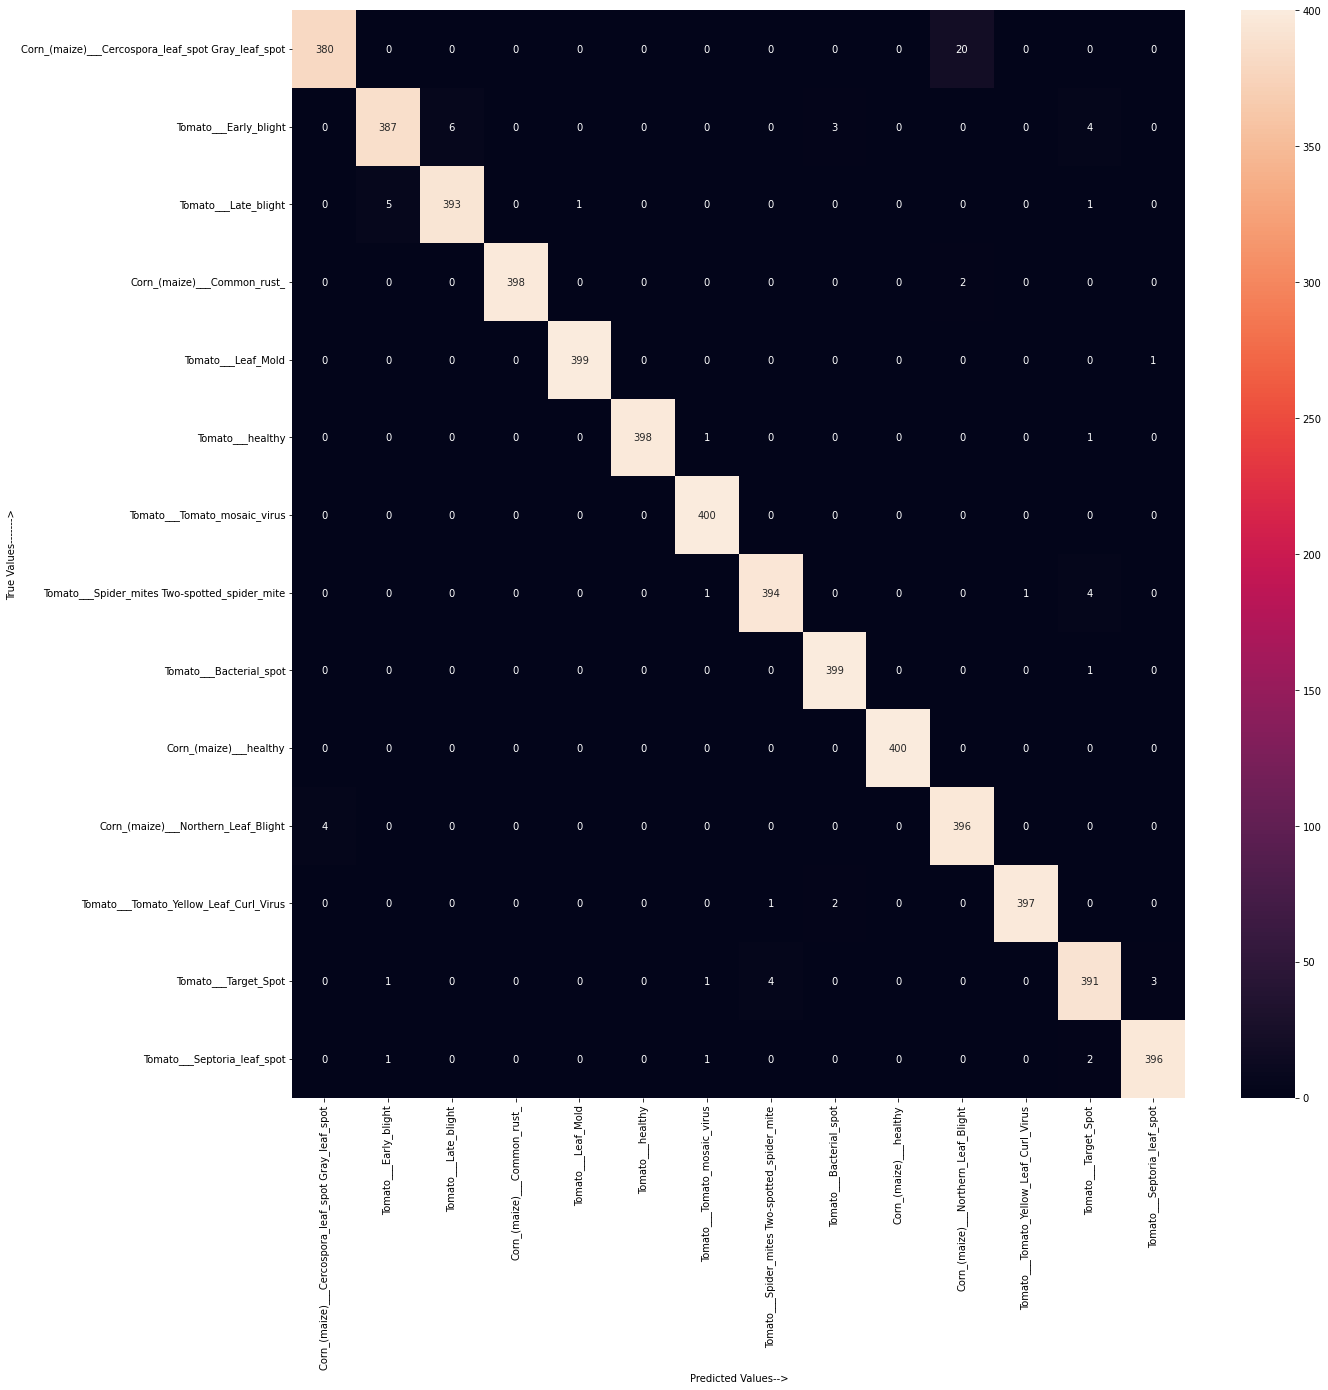

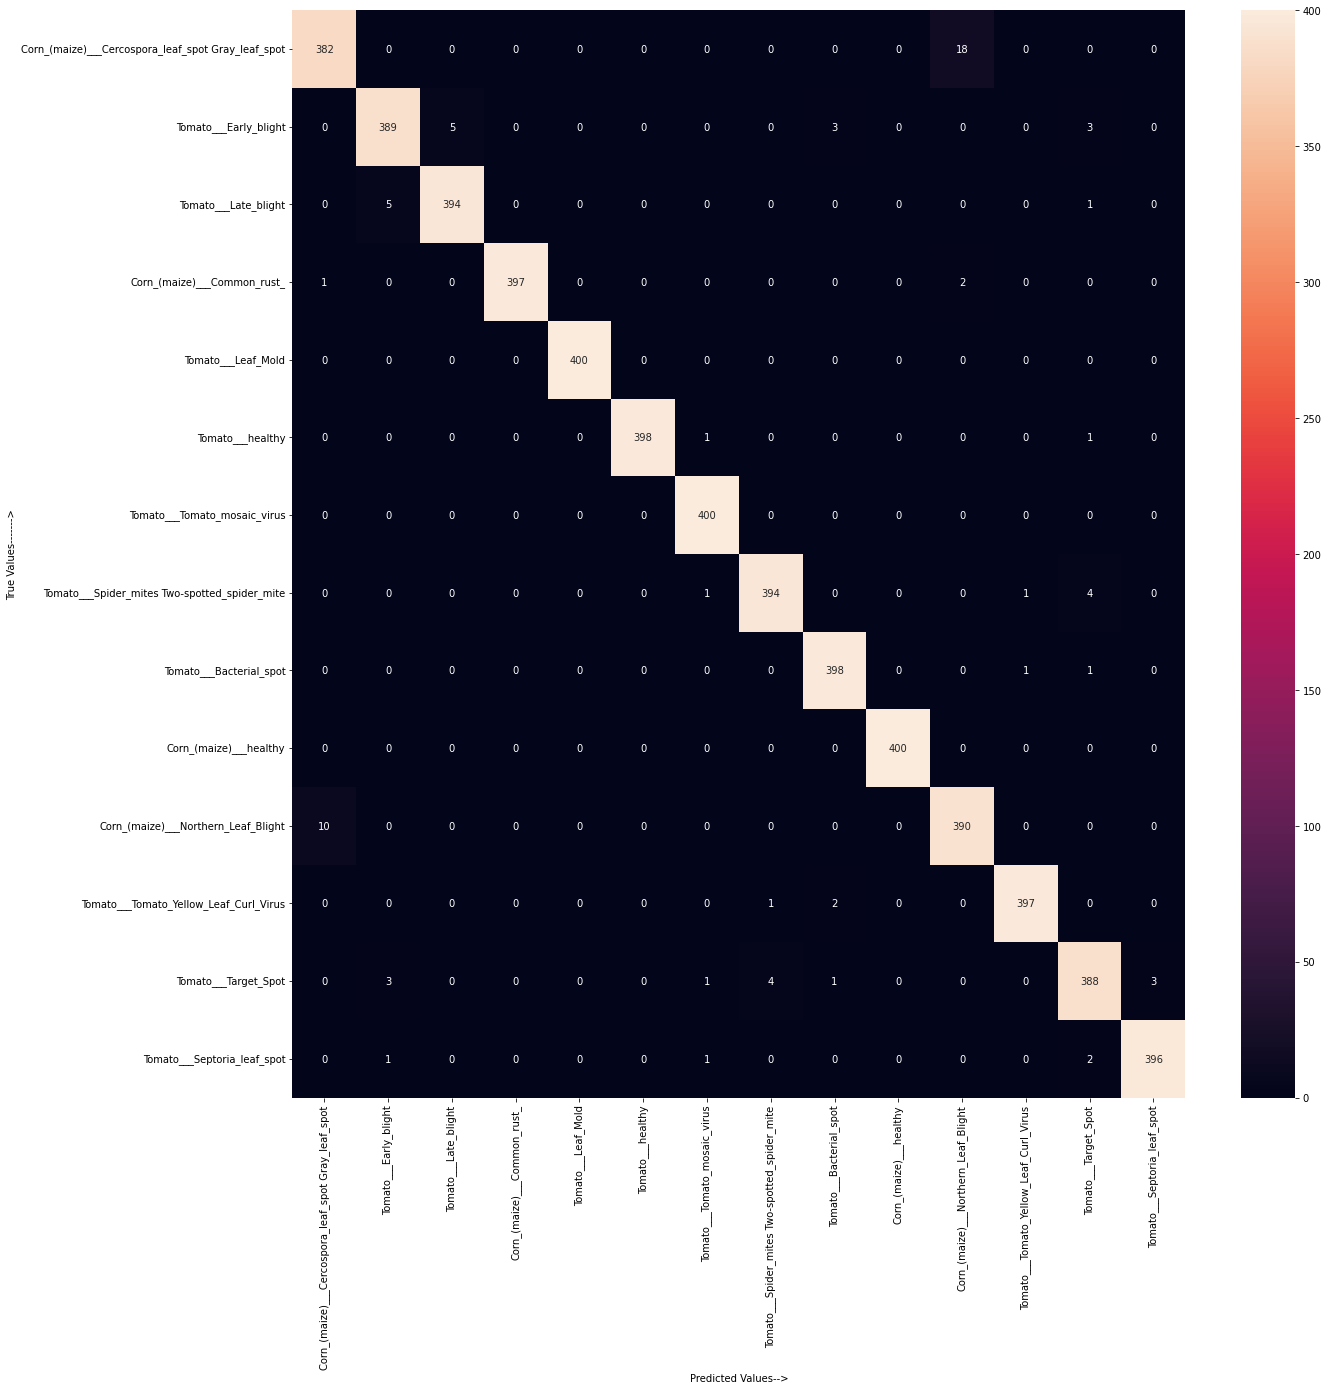

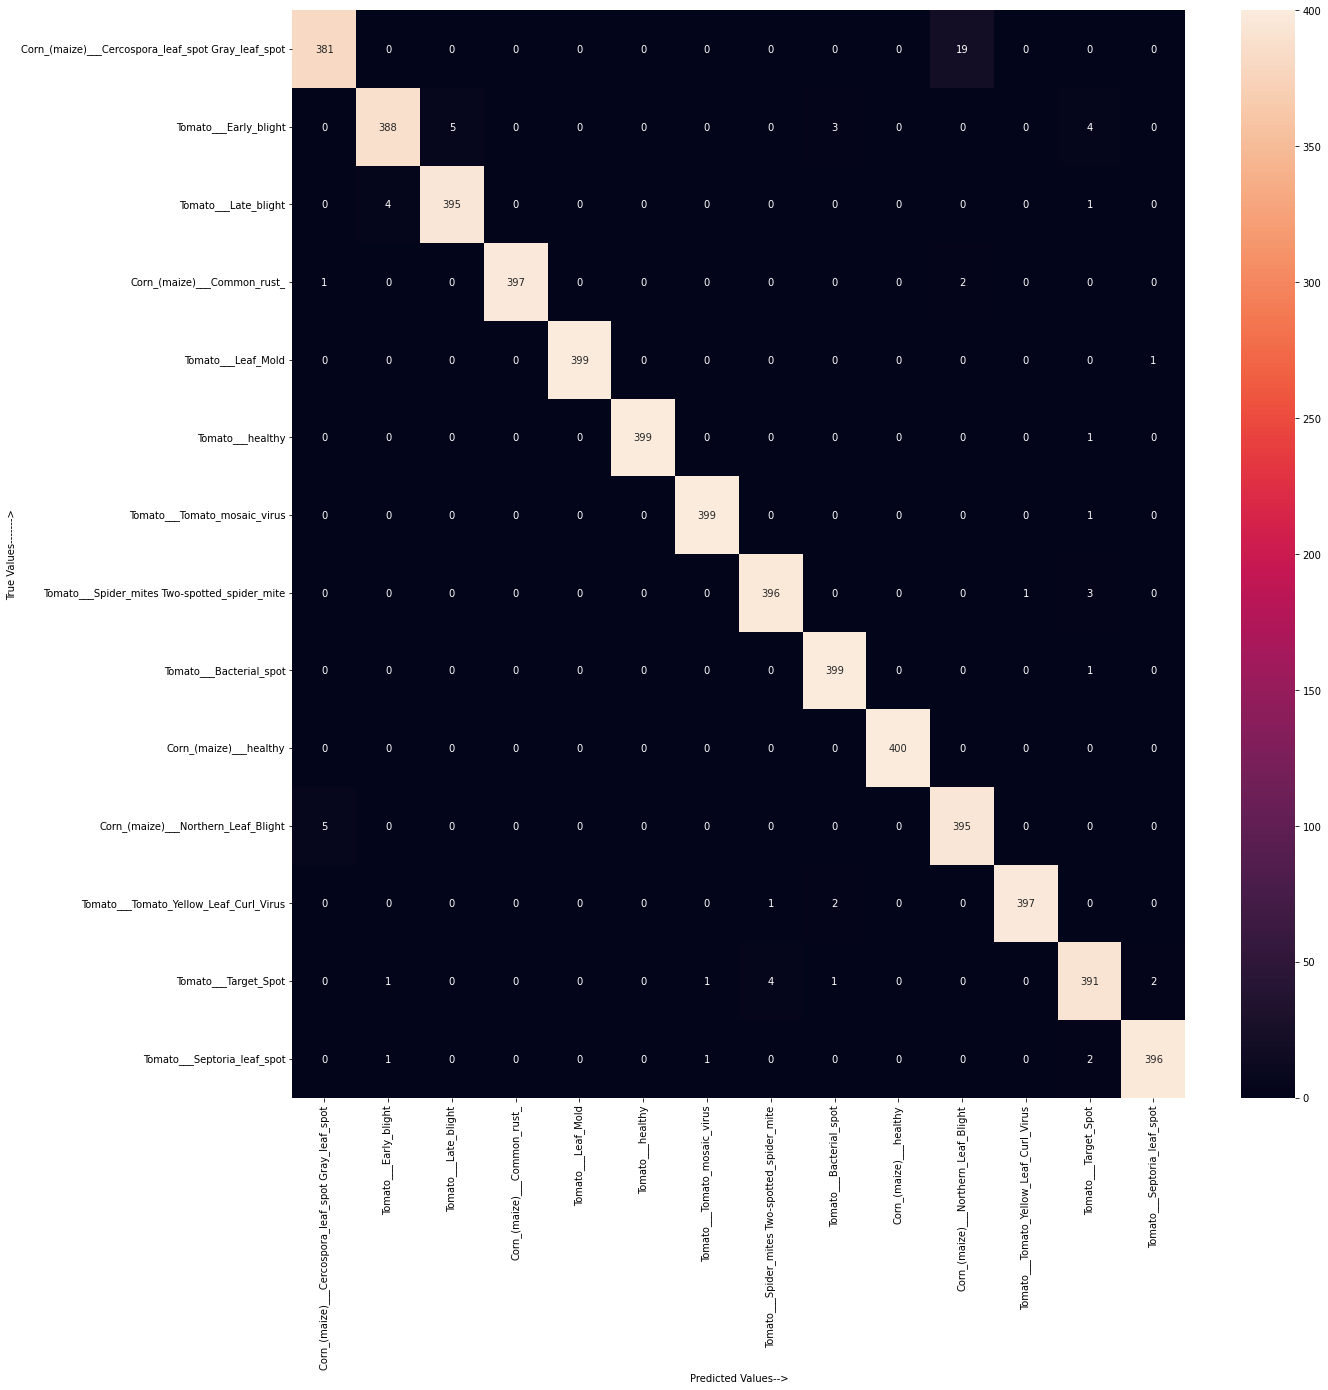

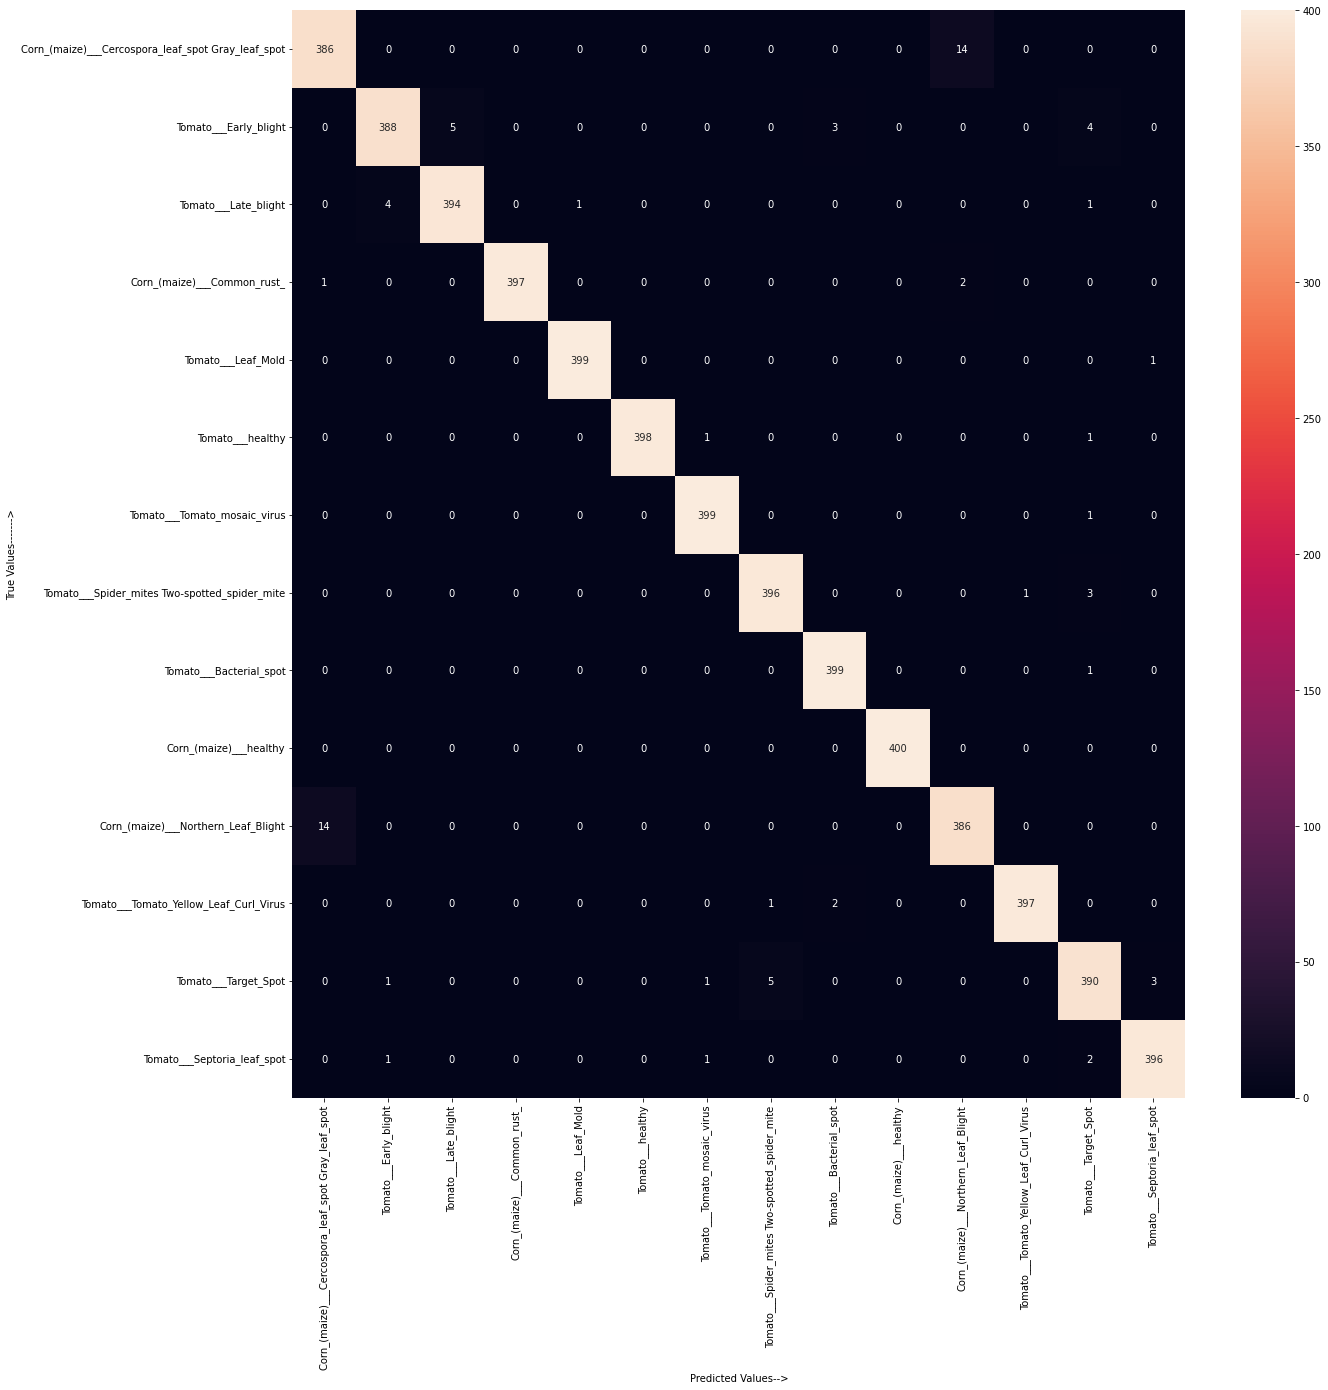

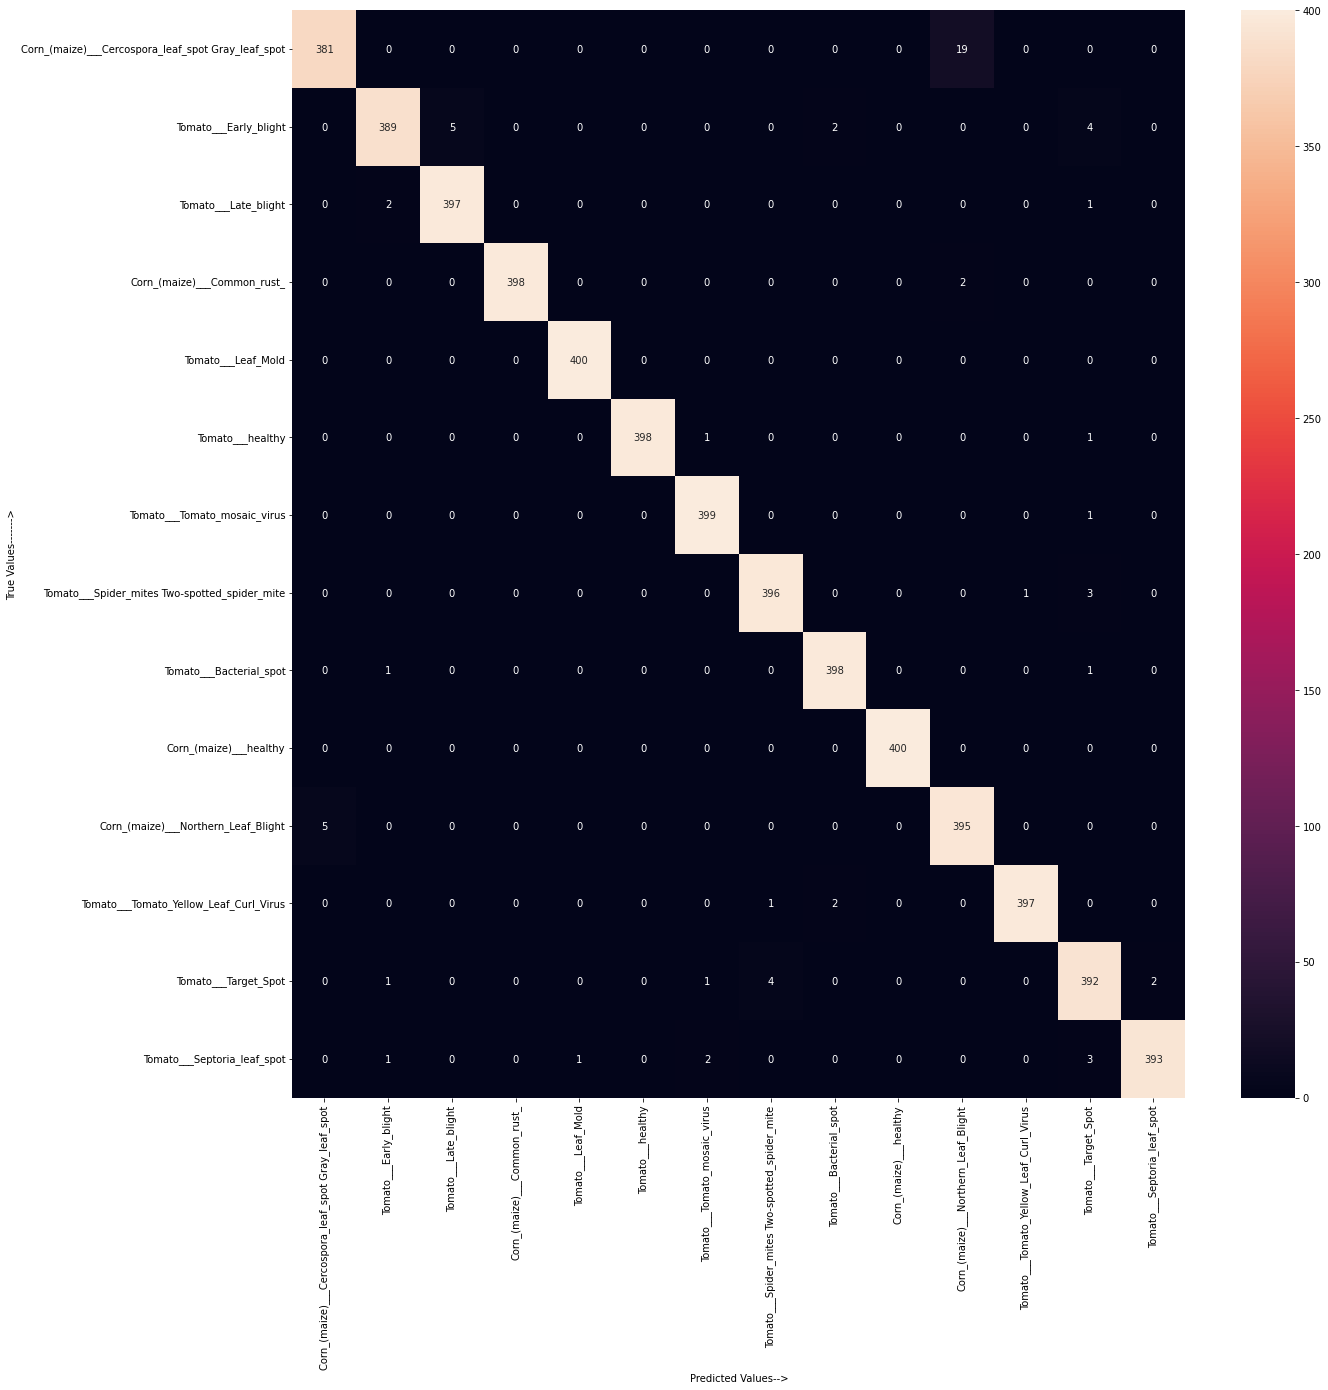

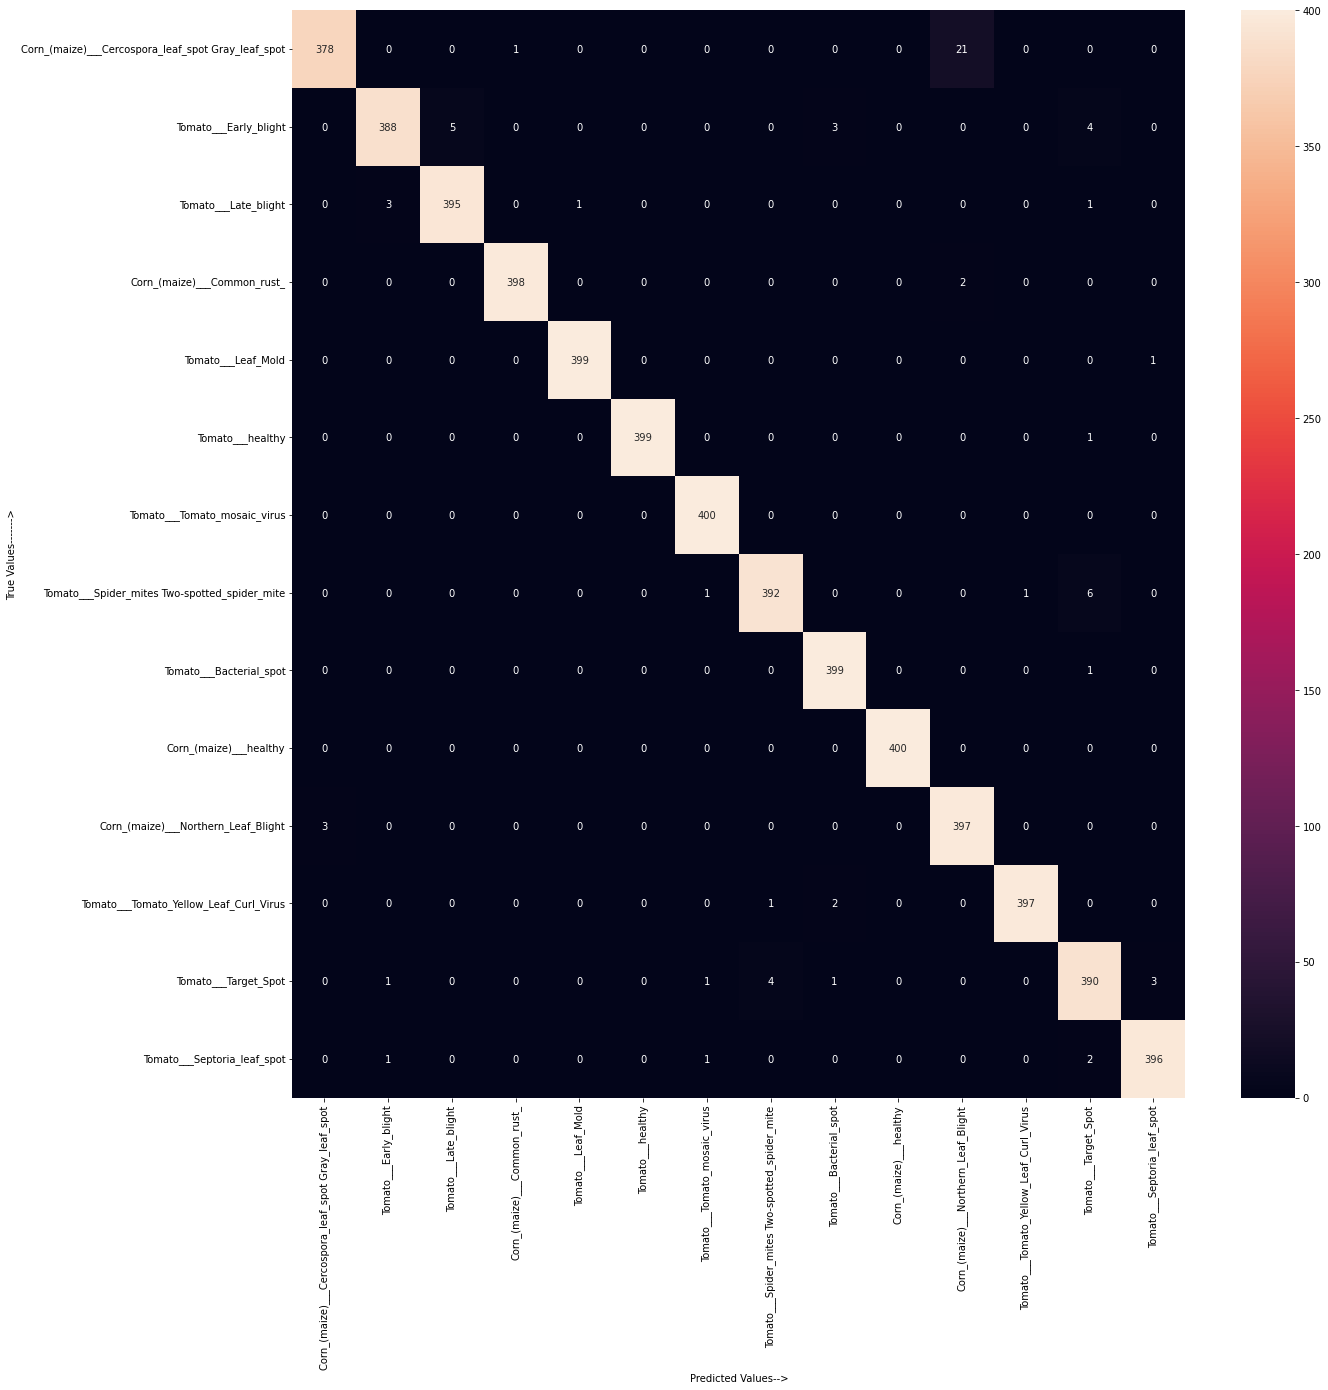

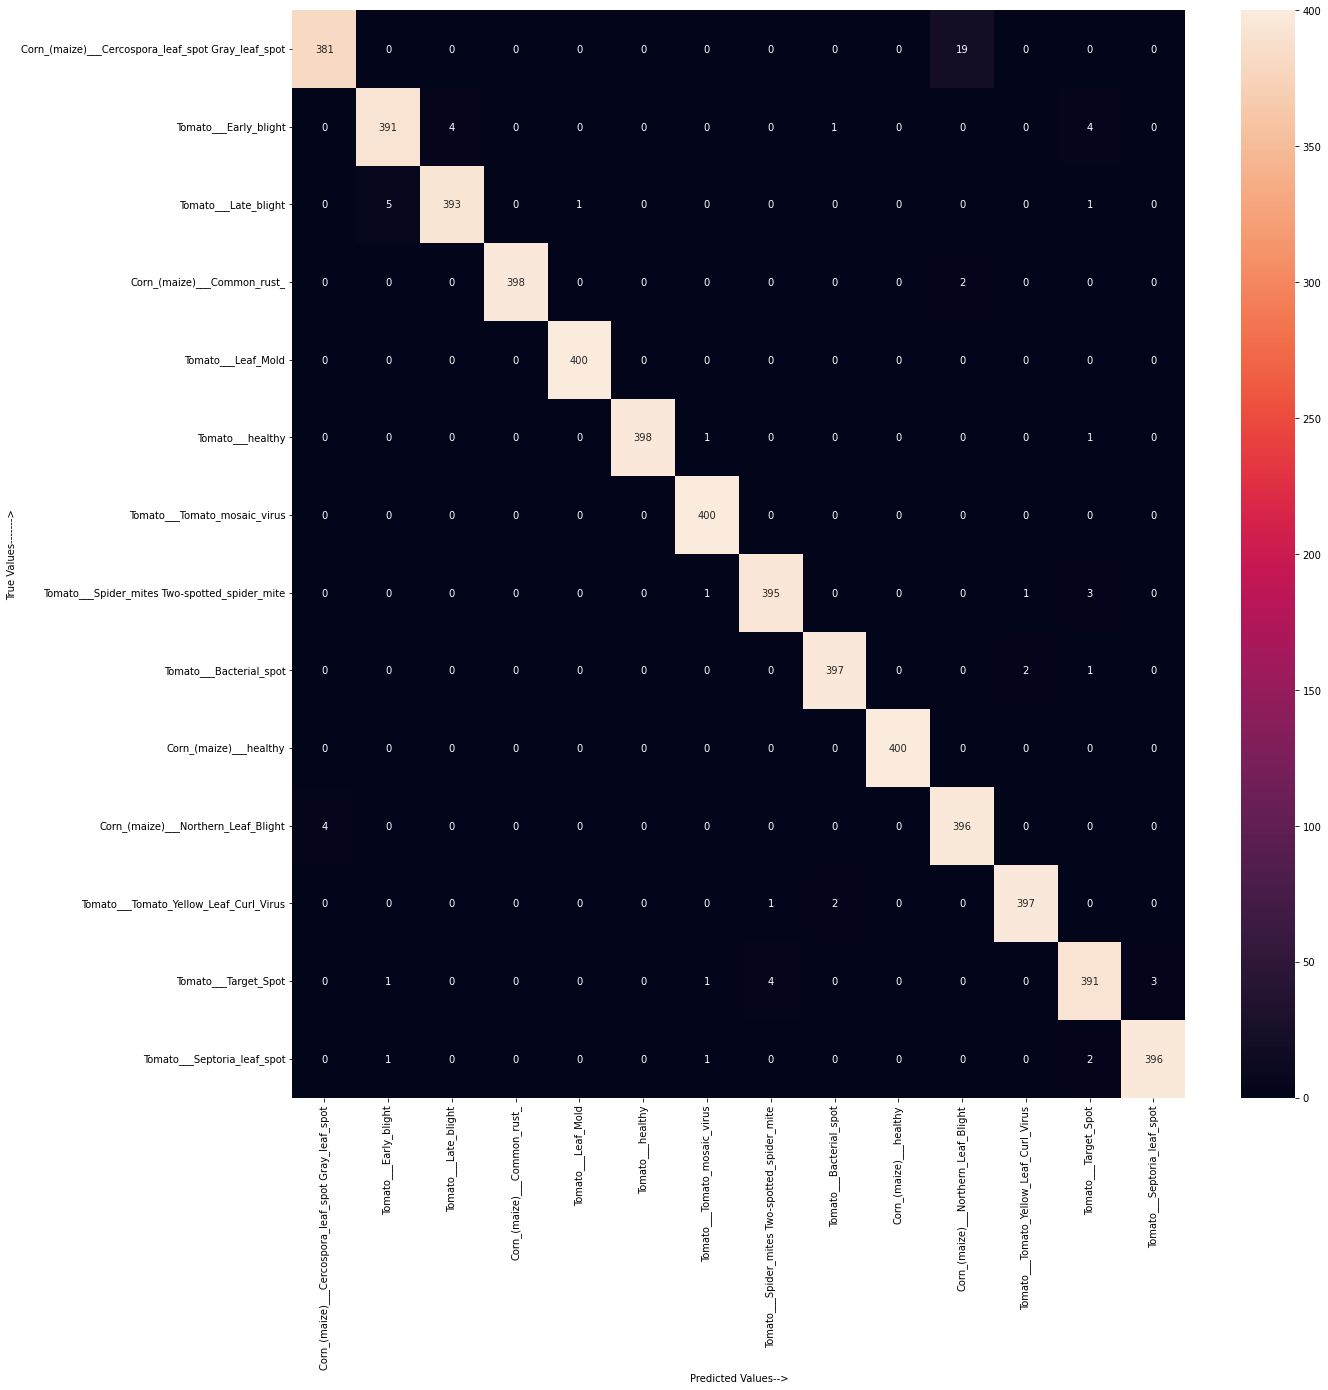

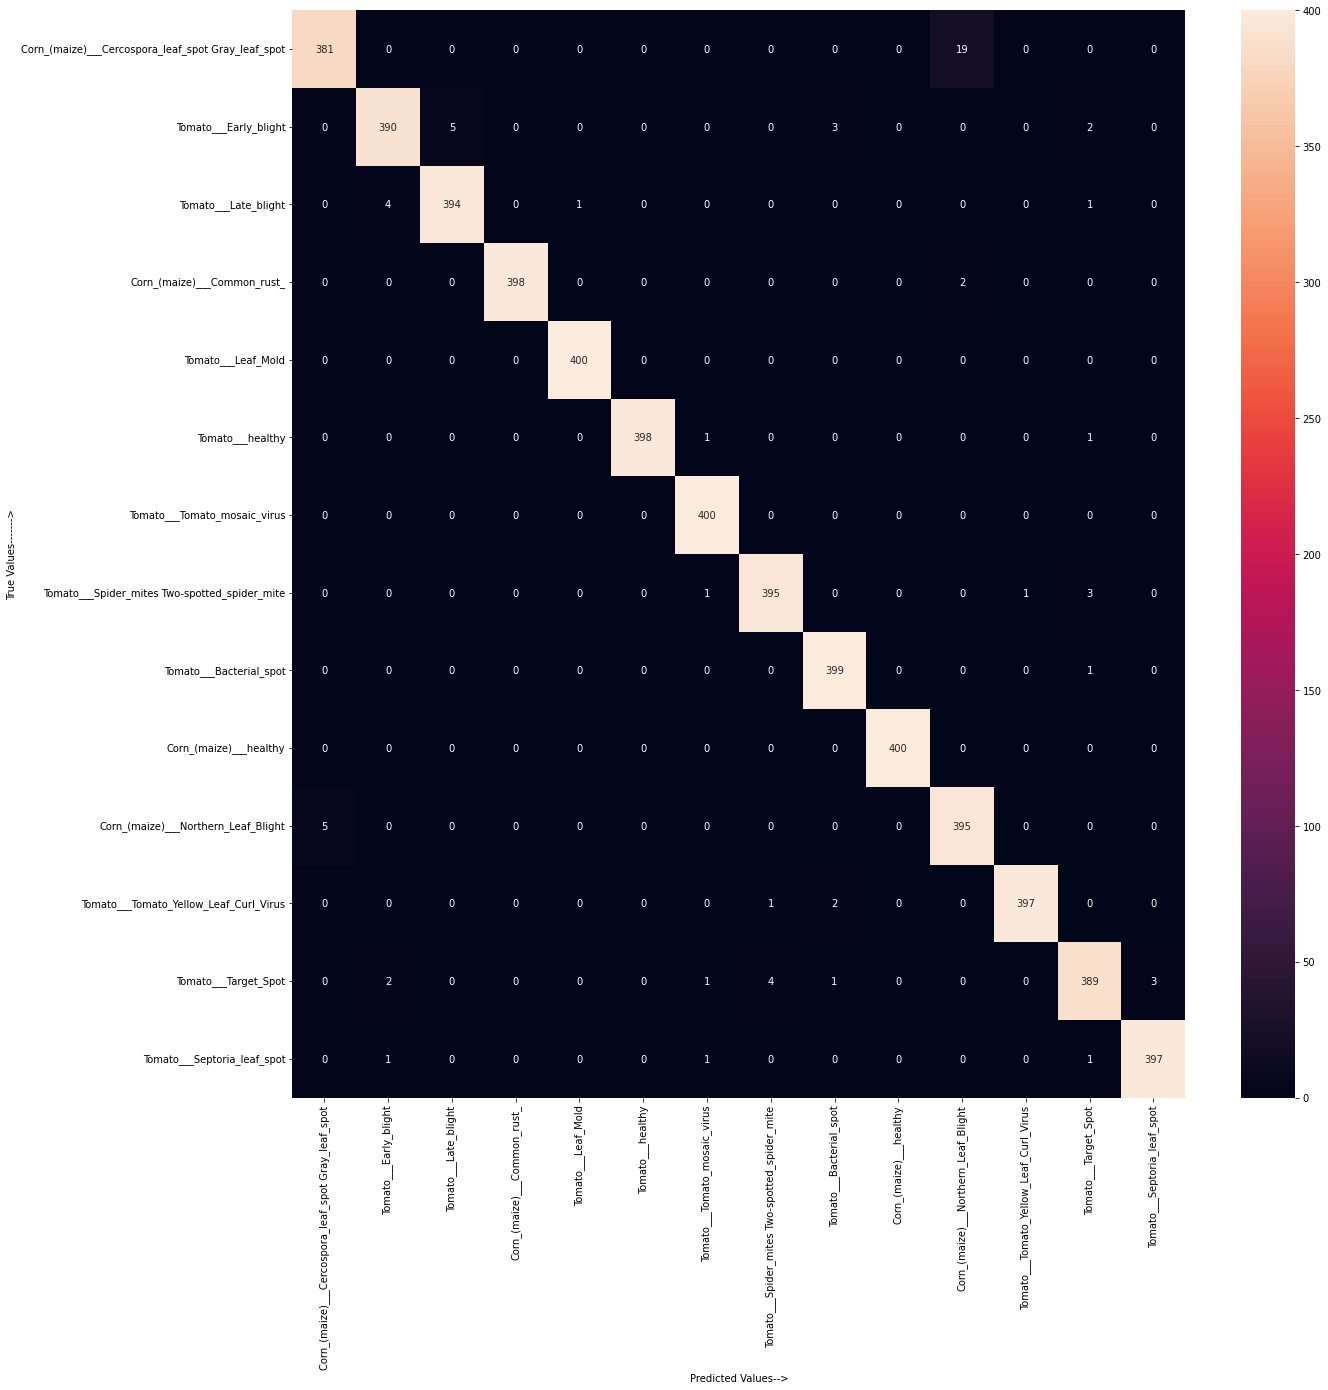

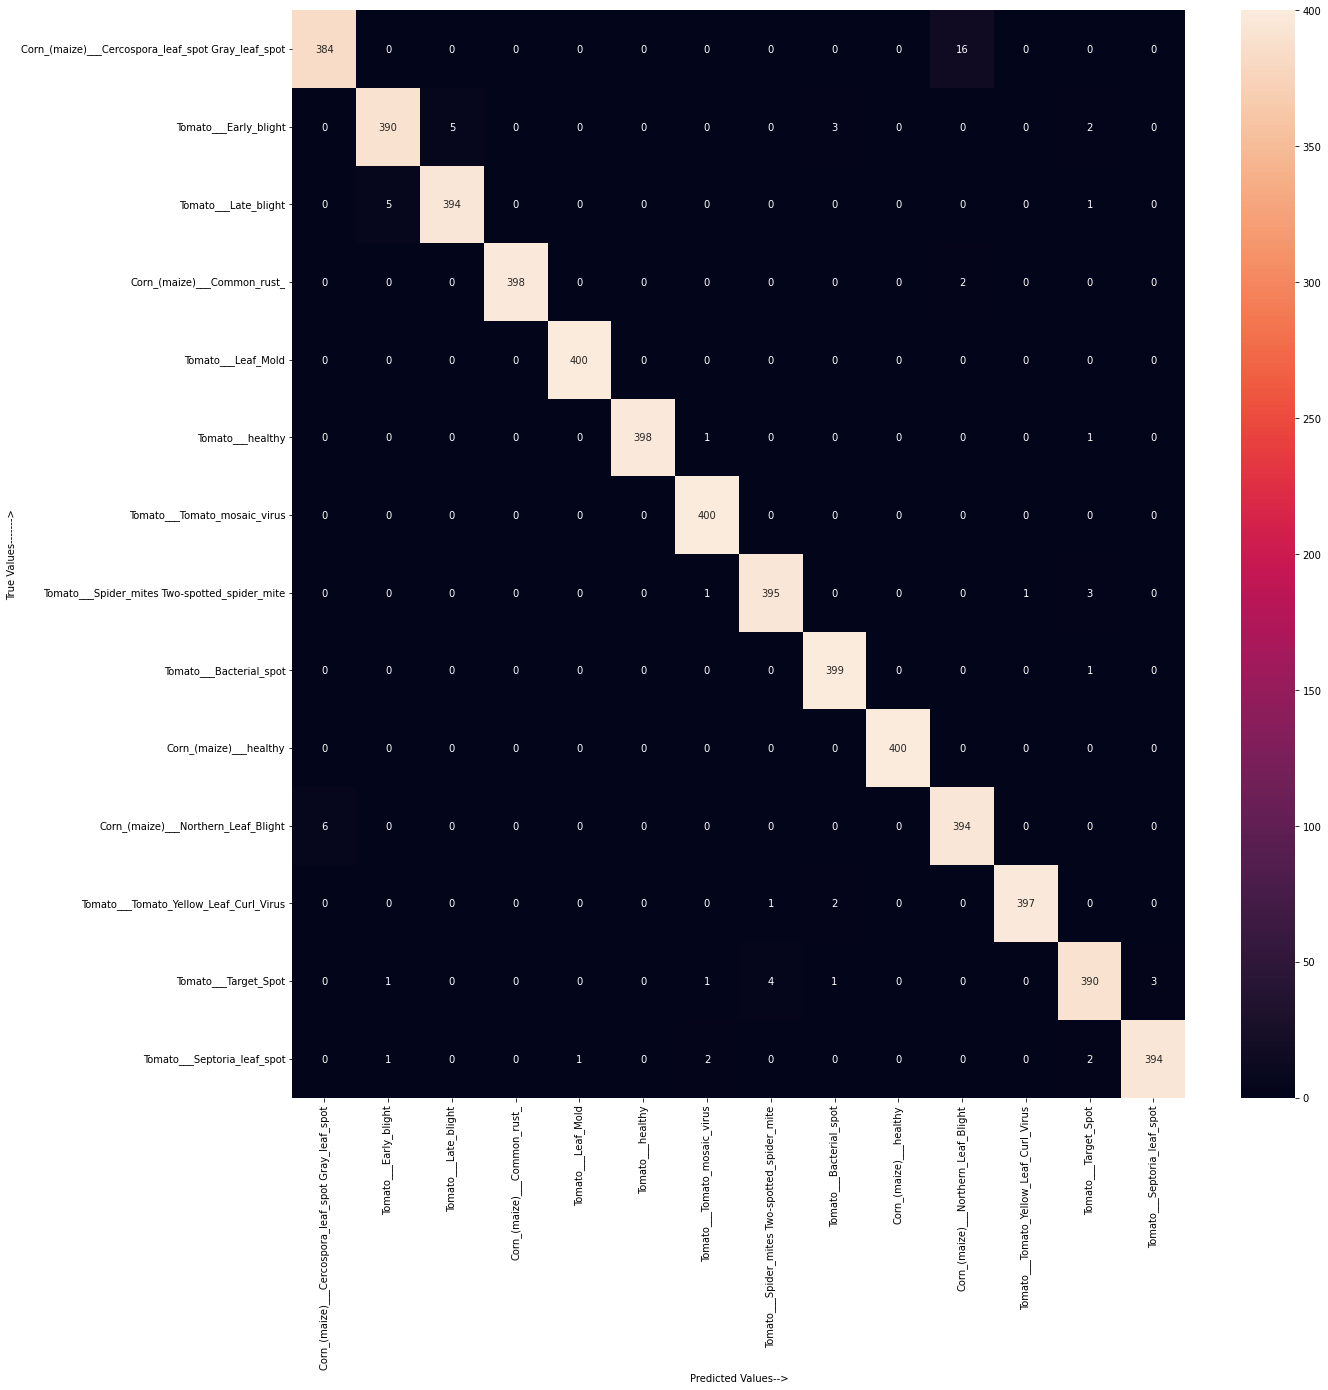

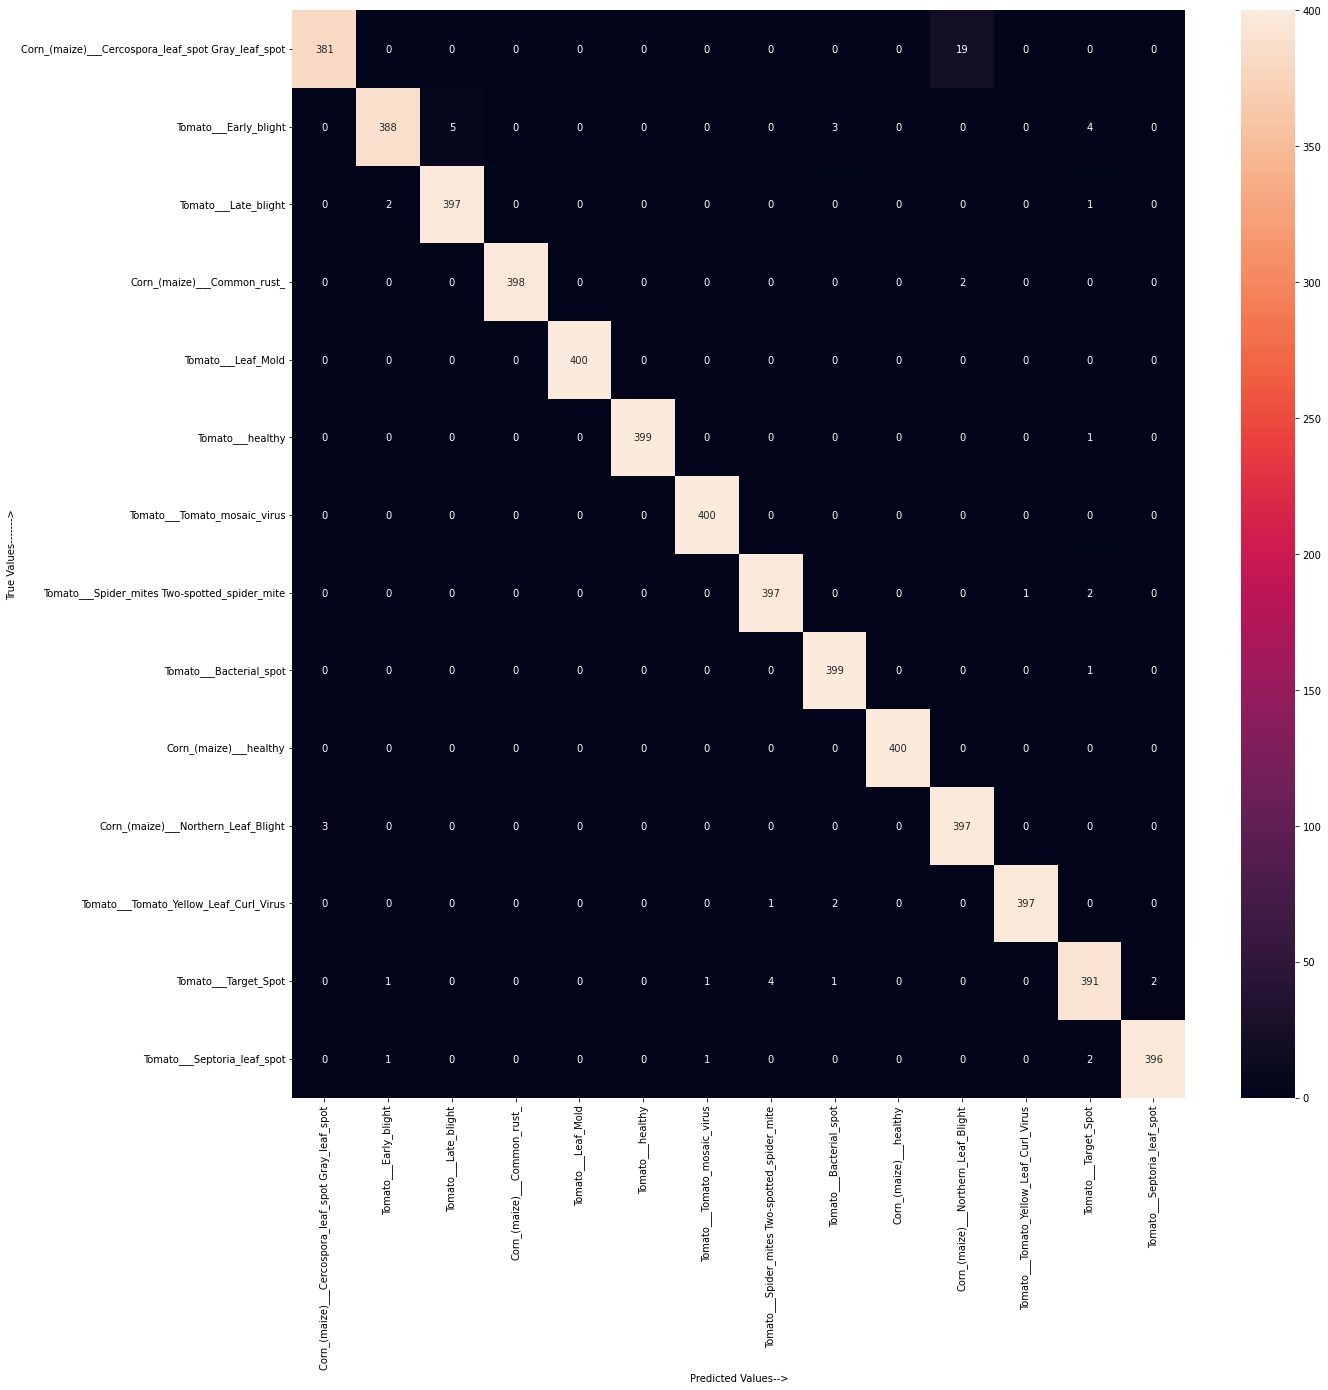

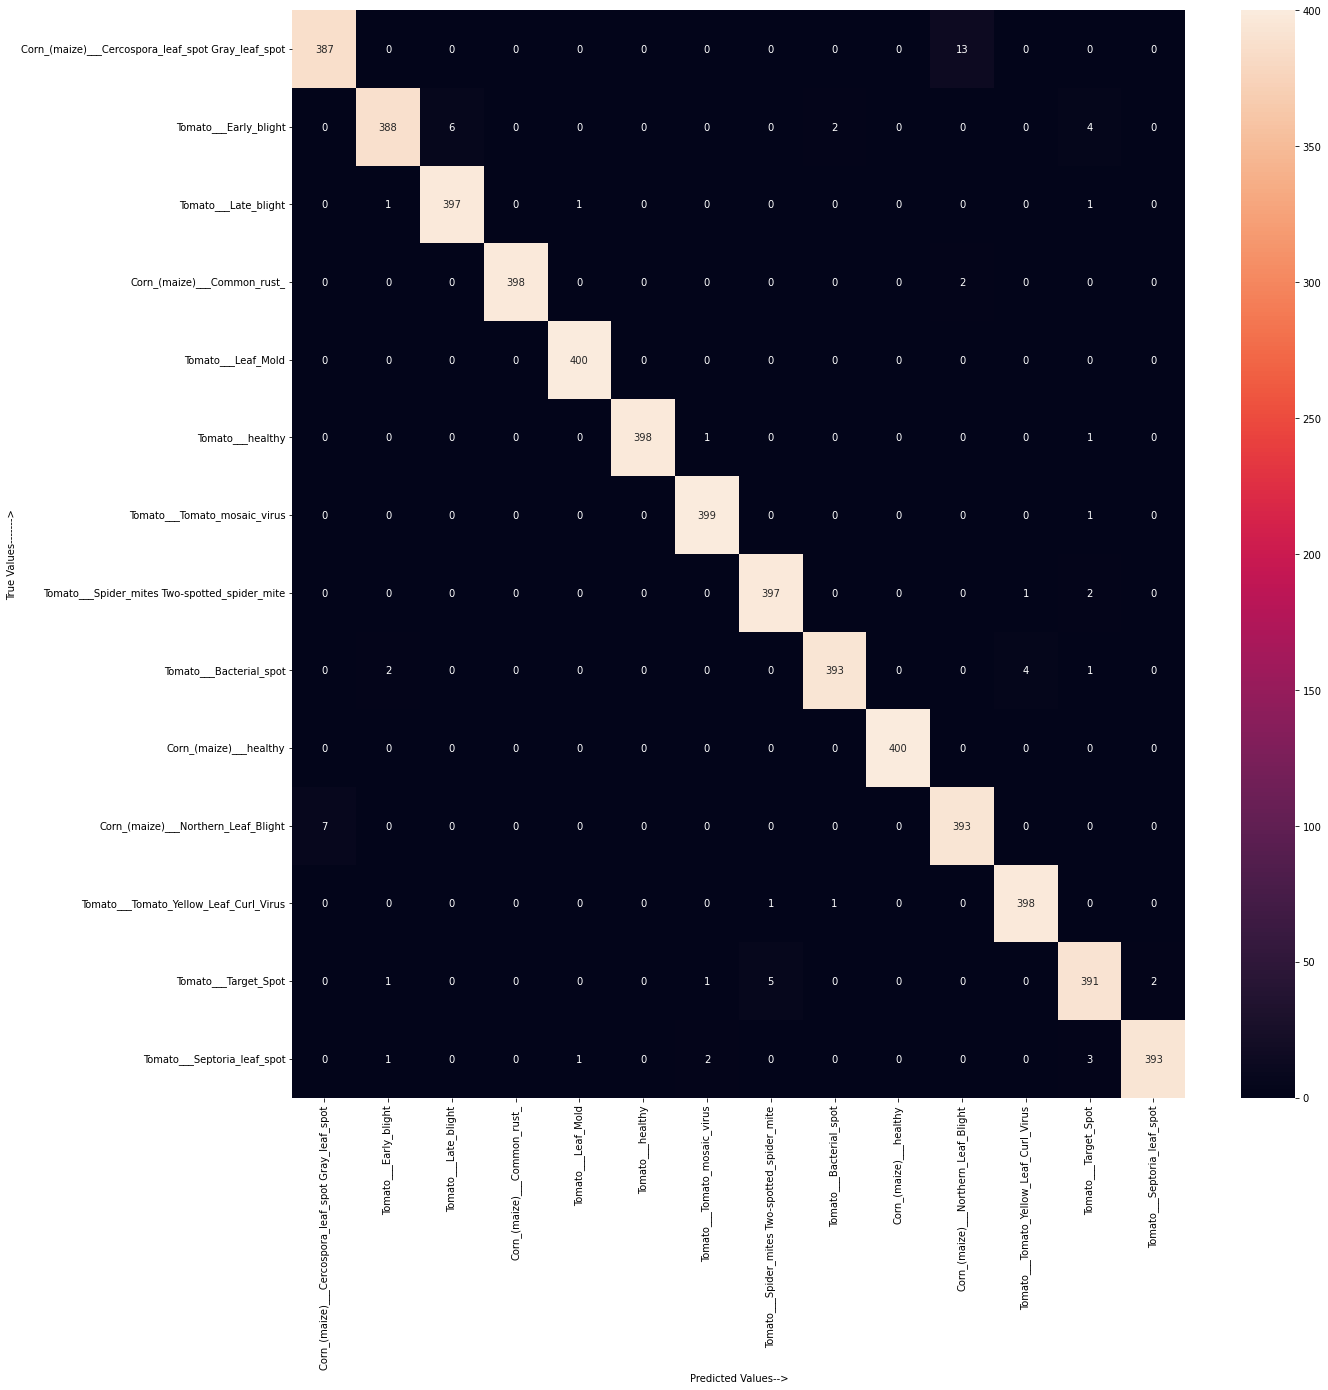

<Figure size 432x288 with 0 Axes>

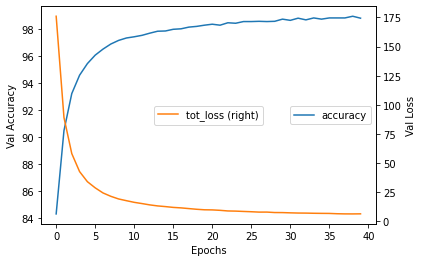

In [21]:
train(model, optimizer_choice = "sgdm", num_of_epochs = 40)

Storing Reference Variables

In [22]:
with open("labels_to_num.json", "w") as outfile:
    json.dump(labels_to_num, outfile)
with open("num_to_labels.json", "w") as outfile:
    json.dump(num_to_labels, outfile)

Plotting training results

<Figure size 432x288 with 0 Axes>

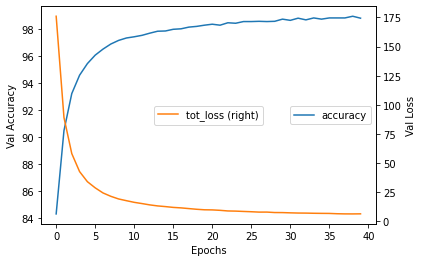

In [23]:
analyse_df = pd.read_csv("valid_matrices.csv")
analyse_df = analyse_df.assign(accuracy = lambda x: (x['accuracy']* 100))


plt.figure()
ax = analyse_df[['accuracy','tot_loss']].plot(secondary_y=['tot_loss'])
ax.set_ylabel('Val Accuracy')
ax.set_xlabel("Epochs")
ax.right_ax.set_ylabel('Val Loss')
ax.legend(loc='right')
ax.right_ax.legend(loc='center')

Uploading models and results to GDrive

In [24]:
!cp "/content/models/model_ep_30.pth" "/content/drive/MyDrive/Image Classification/Final/"
!cp "/content/valid_matrices.csv" "/content/drive/MyDrive/Image Classification/Final/"
!cp "/content/num_to_labels.json" "/content/drive/MyDrive/Image Classification/Final/"


## Testing/Inference

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Loading model

In [ ]:
model = torchvision.models.get_model('mobilenet_v2', weights=None)
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=14)
model.load_state_dict(torch.load('/content/models/model_ep_33.pth'))
model = model.to(device)

# model.eval() sets the model to evaluation mode
model.eval()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

Predict function

In [ ]:
# prediction function to test sample images
@torch.no_grad()
def predict(img_path):
    image = Image.open(img_path)
    resize = transforms.Compose(
             [ transforms.Resize(224),
              transforms.ToTensor(),
              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])           
    image = resize(image)
    image = image.to(device)
    with torch.no_grad():
        y_result = torch.softmax(model(image.unsqueeze(0)),dim=1)
        print(y_result,"\n")
        result_idx = y_result.argmax(dim=1)
        print(num_to_labels[int(result_idx)])

Sample Predictions

In [ ]:
predict("/content/TomatoYellowCurlVirus2.JPG")

In [ ]:
predict("/content/CornCommonRust3.JPG")

tensor([[9.9971e-01, 1.4508e-13, 4.4483e-09, 5.4792e-07, 6.8397e-13, 8.1887e-16,
         5.5973e-18, 3.2289e-12, 5.2308e-16, 6.0385e-13, 8.5720e-05, 5.3726e-20,
         4.8649e-17, 2.0449e-04]], device='cuda:0') 

Corn_(maize)___Common_rust_


In [ ]:
predict("/content/TomatoHealthy2.JPG")

tensor([[7.8519e-09, 3.4621e-03, 7.1222e-09, 1.1908e-06, 2.3791e-06, 3.6365e-05,
         1.0715e-07, 1.5094e-08, 1.6583e-10, 9.8581e-01, 1.0368e-02, 1.9290e-05,
         2.8468e-04, 2.0585e-05]], device='cuda:0') 

Tomato___healthy


Zipping models and results


In [ ]:
!zip -r models.zip /content/models
!zip -r confusion_matrices.zip /content/confusion_matrices
!zip -r valid_metrics.zip /content/valid_metrics

## Intermediate Levels

In [ ]:
model = torchvision.models.get_model('mobilenet_v2', weights=None)
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=14)
model.load_state_dict(torch.load('/content/model.pth'))
# model = model.to(device)

# model.eval() sets the model to evaluation mode
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=


Layer : 0 



<Figure size 432x288 with 0 Axes>

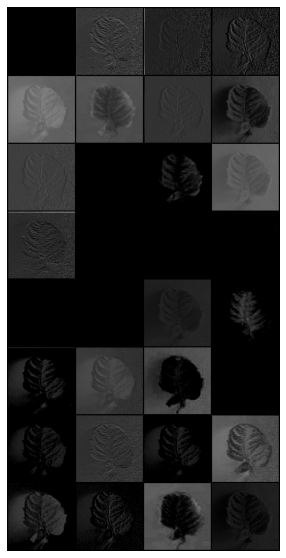


Layer : 1 



<Figure size 432x288 with 0 Axes>

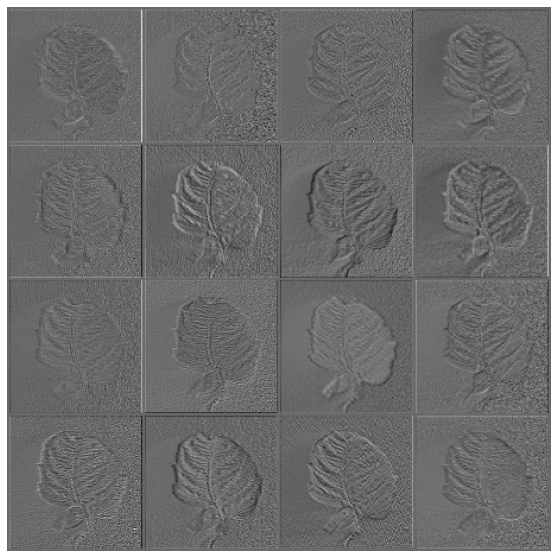


Layer : 2 



<Figure size 432x288 with 0 Axes>

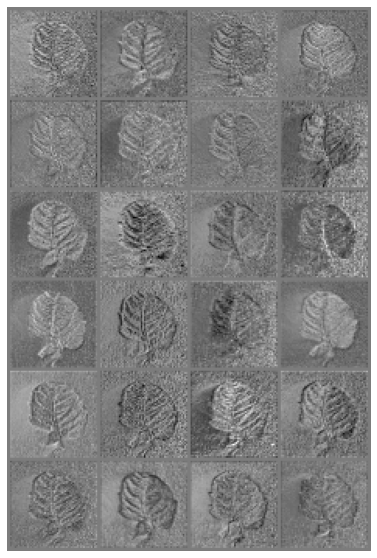


Layer : 3 



<Figure size 432x288 with 0 Axes>

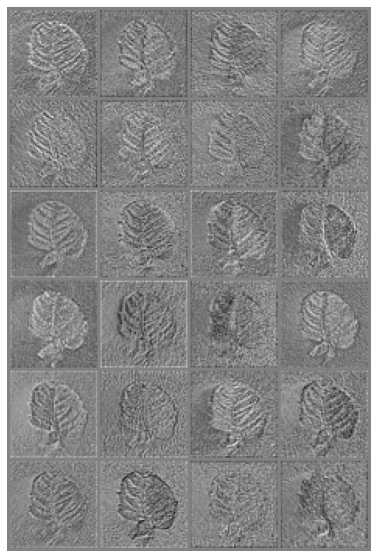


Layer : 4 



<Figure size 432x288 with 0 Axes>

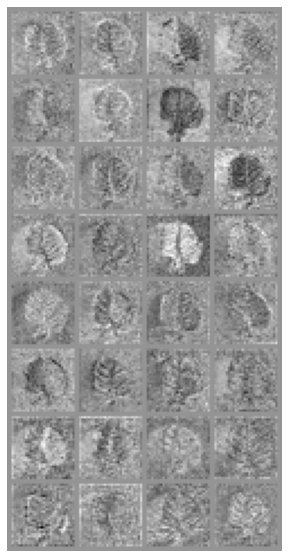


Layer : 5 



<Figure size 432x288 with 0 Axes>

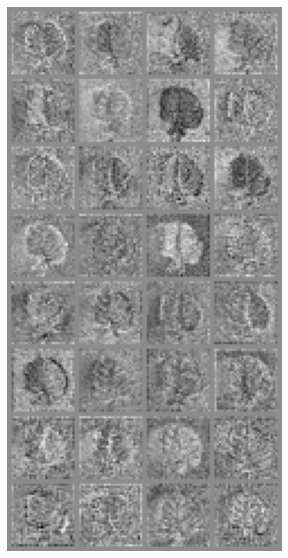


Layer : 6 



<Figure size 432x288 with 0 Axes>

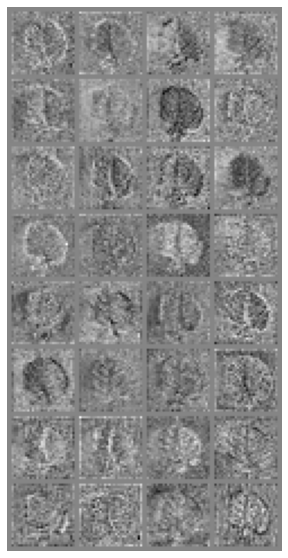


Layer : 7 



<Figure size 432x288 with 0 Axes>

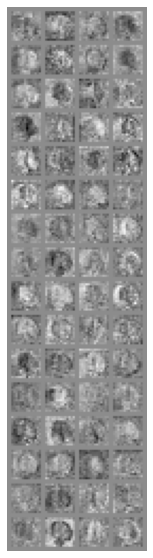


Layer : 8 



<Figure size 432x288 with 0 Axes>

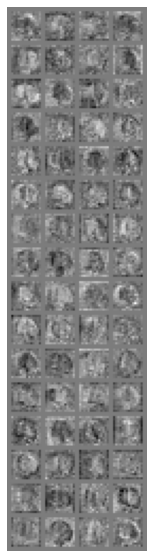


Layer : 9 



<Figure size 432x288 with 0 Axes>

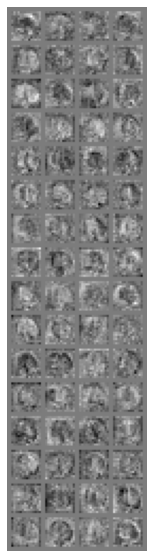


Layer : 10 



<Figure size 432x288 with 0 Axes>

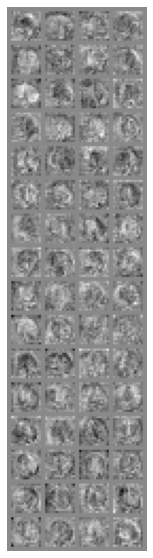


Layer : 11 



<Figure size 432x288 with 0 Axes>

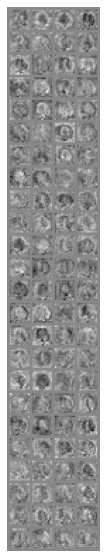


Layer : 12 



<Figure size 432x288 with 0 Axes>

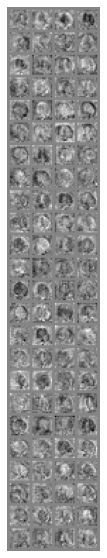


Layer : 13 



<Figure size 432x288 with 0 Axes>

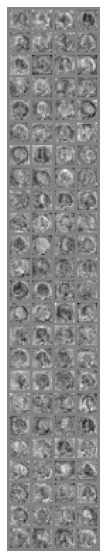


Layer : 14 



<Figure size 432x288 with 0 Axes>

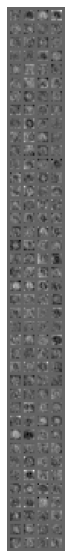


Layer : 15 



<Figure size 432x288 with 0 Axes>

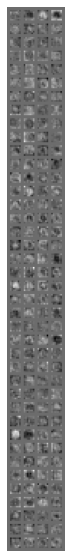


Layer : 16 



<Figure size 432x288 with 0 Axes>

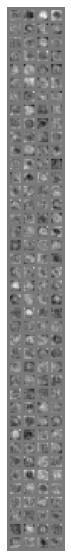


Layer : 17 



<Figure size 432x288 with 0 Axes>

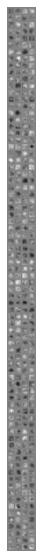


Layer : 18 



<Figure size 432x288 with 0 Axes>

In [ ]:
image = Image.open("/content/vegetable_disease_dataset_001/test/TomatoYellowCurlVirus2.JPG")
resize = transforms.Compose(
          [ transforms.Resize(224),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])           
image = resize(image)
# image = image.to(device)
image = image.unsqueeze(0)
# Loop through the layers of the model and extract the intermediate outputs
for name, module in model.features._modules.items():
    image= module(image)
    if len(image[0].shape)==3 and image[0].shape[1] == image[0].shape[2]:
        # This is the layer we want to visualize
        output = image.squeeze(0)
        print("\nLayer :",name,"\n")
        # Create a grid of images
        grid = torchvision.utils.make_grid(output.unsqueeze(1)
        , nrow=4)

        grid_np = grid.permute(1, 2, 0).detach().cpu().numpy()
        grid_np = (grid_np - np.min(grid_np)) / (np.max(grid_np) - np.min(grid_np))
        grid_np = (grid_np * 255.0).astype(np.uint8)
        # Display the grid
        # Create a figure and axis object
        plt.figure()
        fig, ax = plt.subplots(figsize=(10, 10))

        # Plot the image
        ax.imshow(grid_np)
        # plt.imshow(grid_np)
        plt.axis('off')
        plt.show()



## Adam Test

100%|██████████| 350/350 [02:36<00:00,  2.24it/s]


Epoch 1, Val Accuracy : 0.9860714285714286, Val loss: 8.27639189735055, Val Macro Avg f1 0.9860752899304395, Val Weighted Avg f1 0.9860752899304392


100%|██████████| 350/350 [02:37<00:00,  2.22it/s]


Epoch 2, Val Accuracy : 0.9873214285714286, Val loss: 6.398627766175196, Val Macro Avg f1 0.9873207136847798, Val Weighted Avg f1 0.9873207136847798


100%|██████████| 350/350 [02:36<00:00,  2.24it/s]


Epoch 3, Val Accuracy : 0.99125, Val loss: 4.937299020995852, Val Macro Avg f1 0.991216858217161, Val Weighted Avg f1 0.9912168582171611


100%|██████████| 350/350 [02:36<00:00,  2.23it/s]


Epoch 4, Val Accuracy : 0.9875, Val loss: 6.288850513898069, Val Macro Avg f1 0.9874574139606612, Val Weighted Avg f1 0.9874574139606613


100%|██████████| 350/350 [02:37<00:00,  2.23it/s]


Epoch 5, Val Accuracy : 0.9923214285714286, Val loss: 3.770786745182704, Val Macro Avg f1 0.9923222087949356, Val Weighted Avg f1 0.9923222087949357


100%|██████████| 350/350 [02:37<00:00,  2.22it/s]


Epoch 6, Val Accuracy : 0.9935714285714285, Val loss: 3.489436855314125, Val Macro Avg f1 0.9935697662242493, Val Weighted Avg f1 0.9935697662242494


100%|██████████| 350/350 [02:37<00:00,  2.22it/s]


Epoch 7, Val Accuracy : 0.9853571428571428, Val loss: 7.920175437568105, Val Macro Avg f1 0.9853356595127759, Val Weighted Avg f1 0.9853356595127759


100%|██████████| 350/350 [02:36<00:00,  2.23it/s]


Epoch 8, Val Accuracy : 0.9910714285714286, Val loss: 5.315501965553267, Val Macro Avg f1 0.9910819079681444, Val Weighted Avg f1 0.9910819079681445


100%|██████████| 350/350 [02:36<00:00,  2.24it/s]


Epoch 9, Val Accuracy : 0.9905357142857143, Val loss: 4.745366548626407, Val Macro Avg f1 0.9905461856050758, Val Weighted Avg f1 0.9905461856050758


100%|██████████| 350/350 [02:35<00:00,  2.25it/s]


Epoch 10, Val Accuracy : 0.9923214285714286, Val loss: 3.6953026908995525, Val Macro Avg f1 0.9923211765905169, Val Weighted Avg f1 0.9923211765905169


100%|██████████| 350/350 [02:36<00:00,  2.24it/s]


Epoch 11, Val Accuracy : 0.9939285714285714, Val loss: 3.6650061637265026, Val Macro Avg f1 0.9939265097429942, Val Weighted Avg f1 0.9939265097429942


100%|██████████| 350/350 [02:38<00:00,  2.21it/s]


Epoch 12, Val Accuracy : 0.9916071428571429, Val loss: 6.190859957287103, Val Macro Avg f1 0.9915960786914368, Val Weighted Avg f1 0.9915960786914367


100%|██████████| 350/350 [02:35<00:00,  2.25it/s]


Epoch 13, Val Accuracy : 0.9917857142857143, Val loss: 4.668243551010164, Val Macro Avg f1 0.9917887686285499, Val Weighted Avg f1 0.9917887686285498


100%|██████████| 350/350 [02:35<00:00,  2.25it/s]


Epoch 14, Val Accuracy : 0.9871428571428571, Val loss: 7.833078531759384, Val Macro Avg f1 0.9871450780783543, Val Weighted Avg f1 0.9871450780783542


100%|██████████| 350/350 [02:34<00:00,  2.26it/s]


Epoch 15, Val Accuracy : 0.9944642857142857, Val loss: 3.737371748377882, Val Macro Avg f1 0.9944632304309479, Val Weighted Avg f1 0.9944632304309479


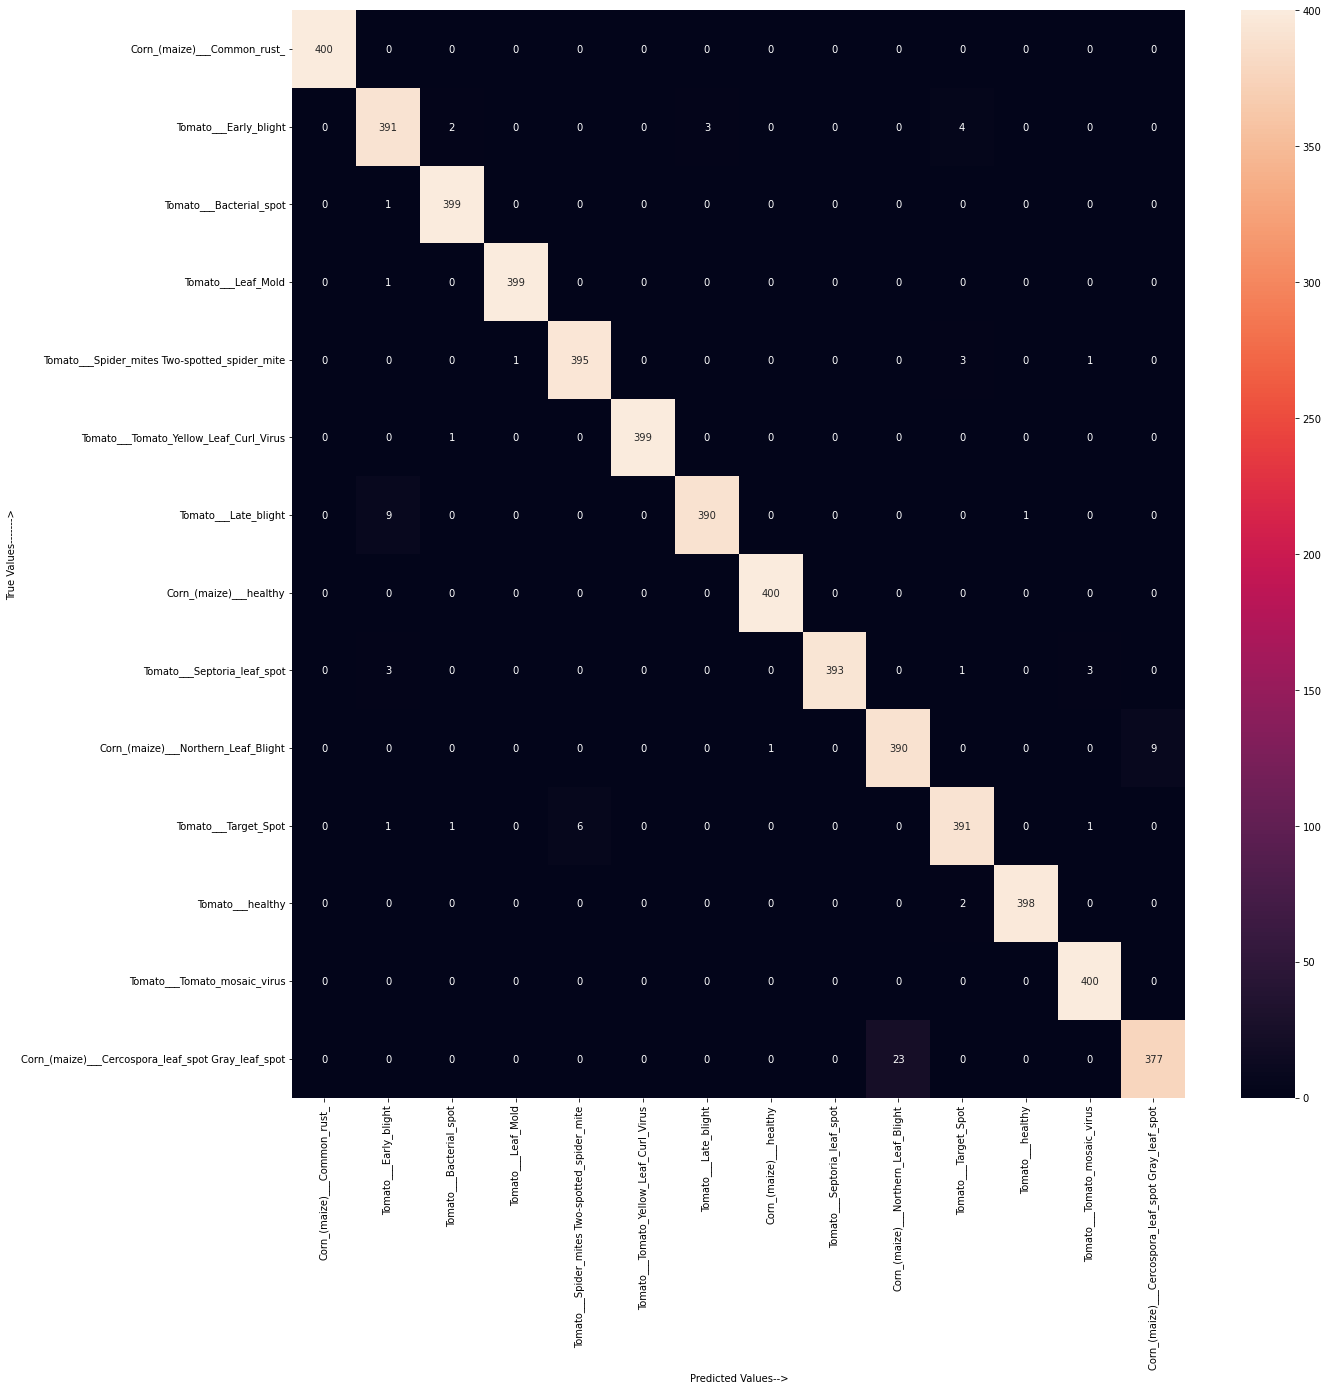

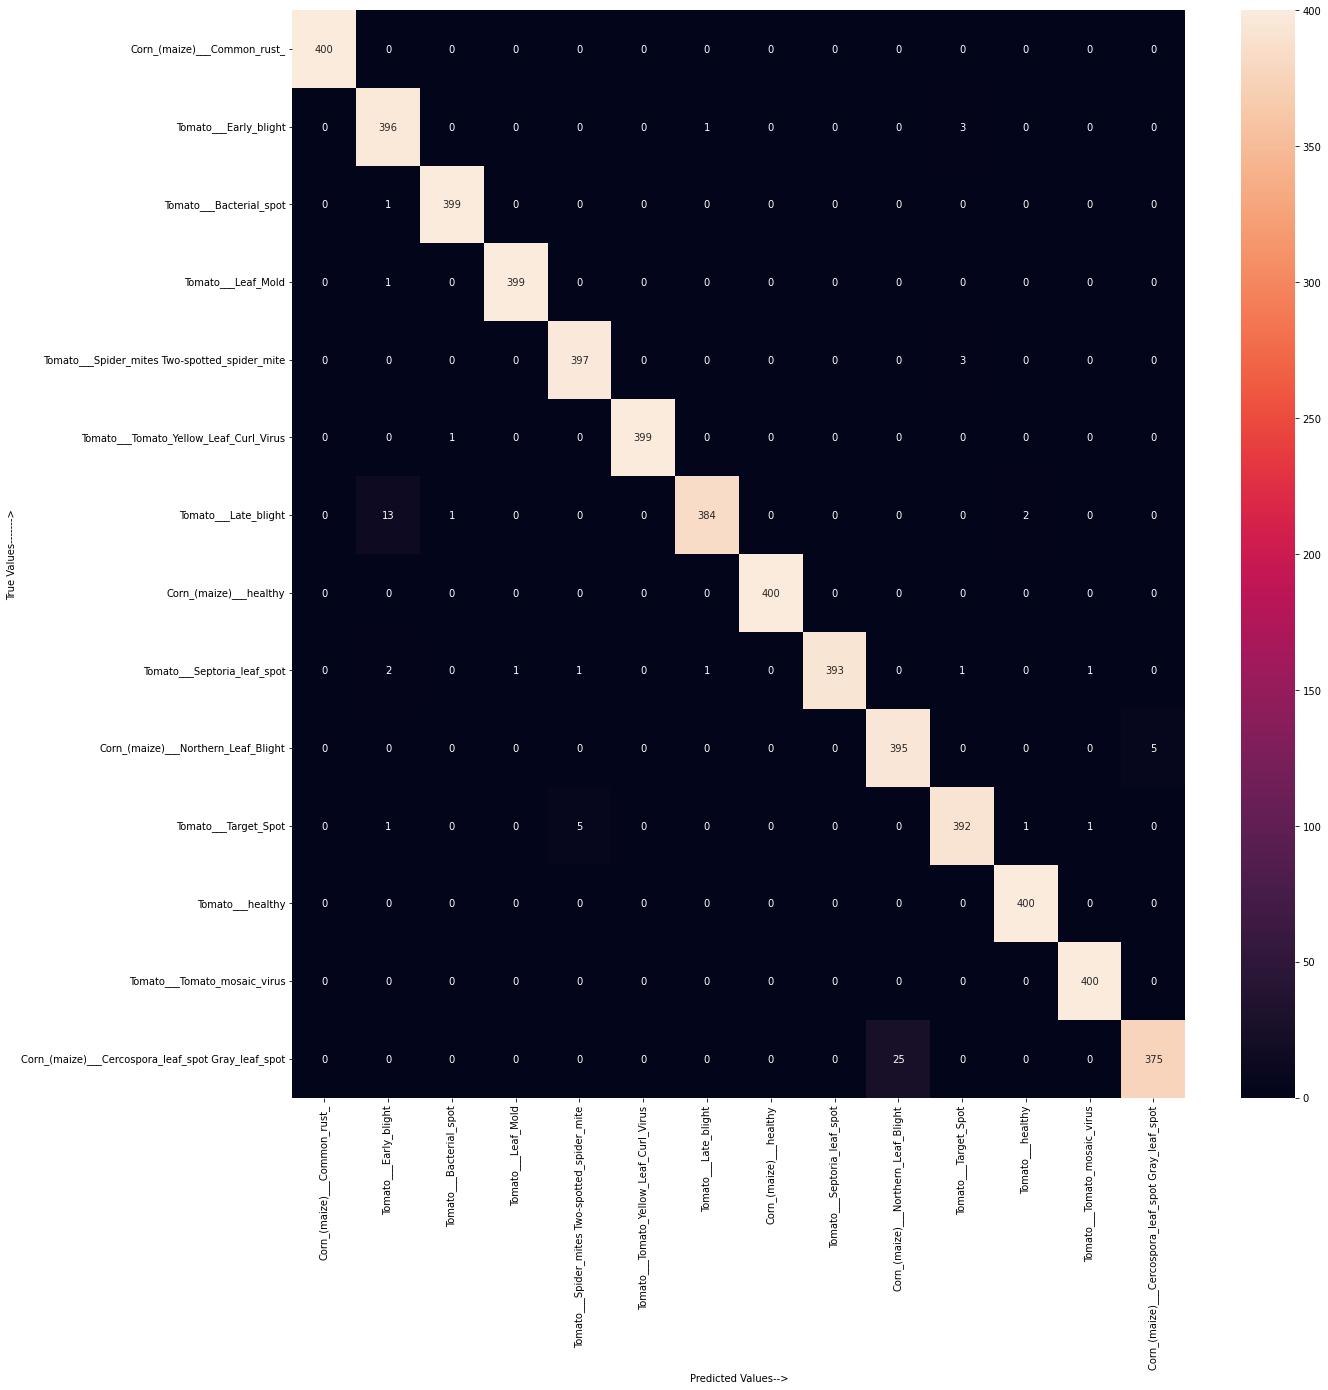

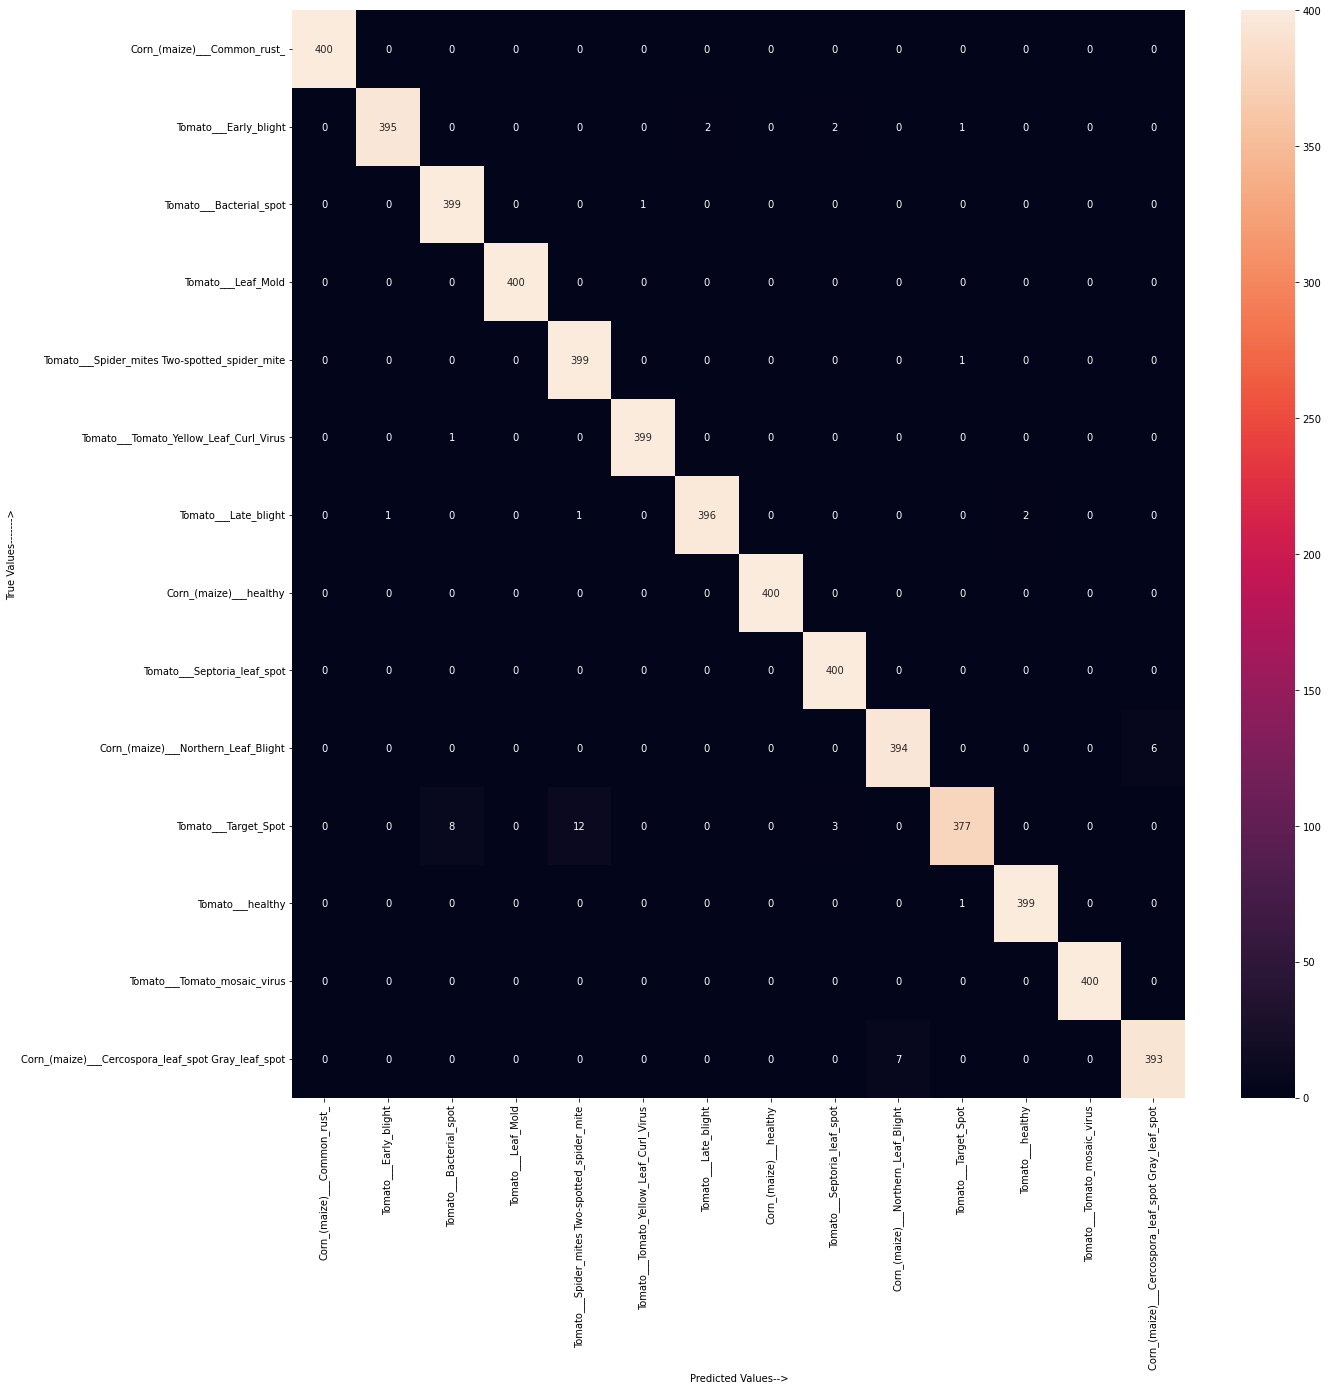

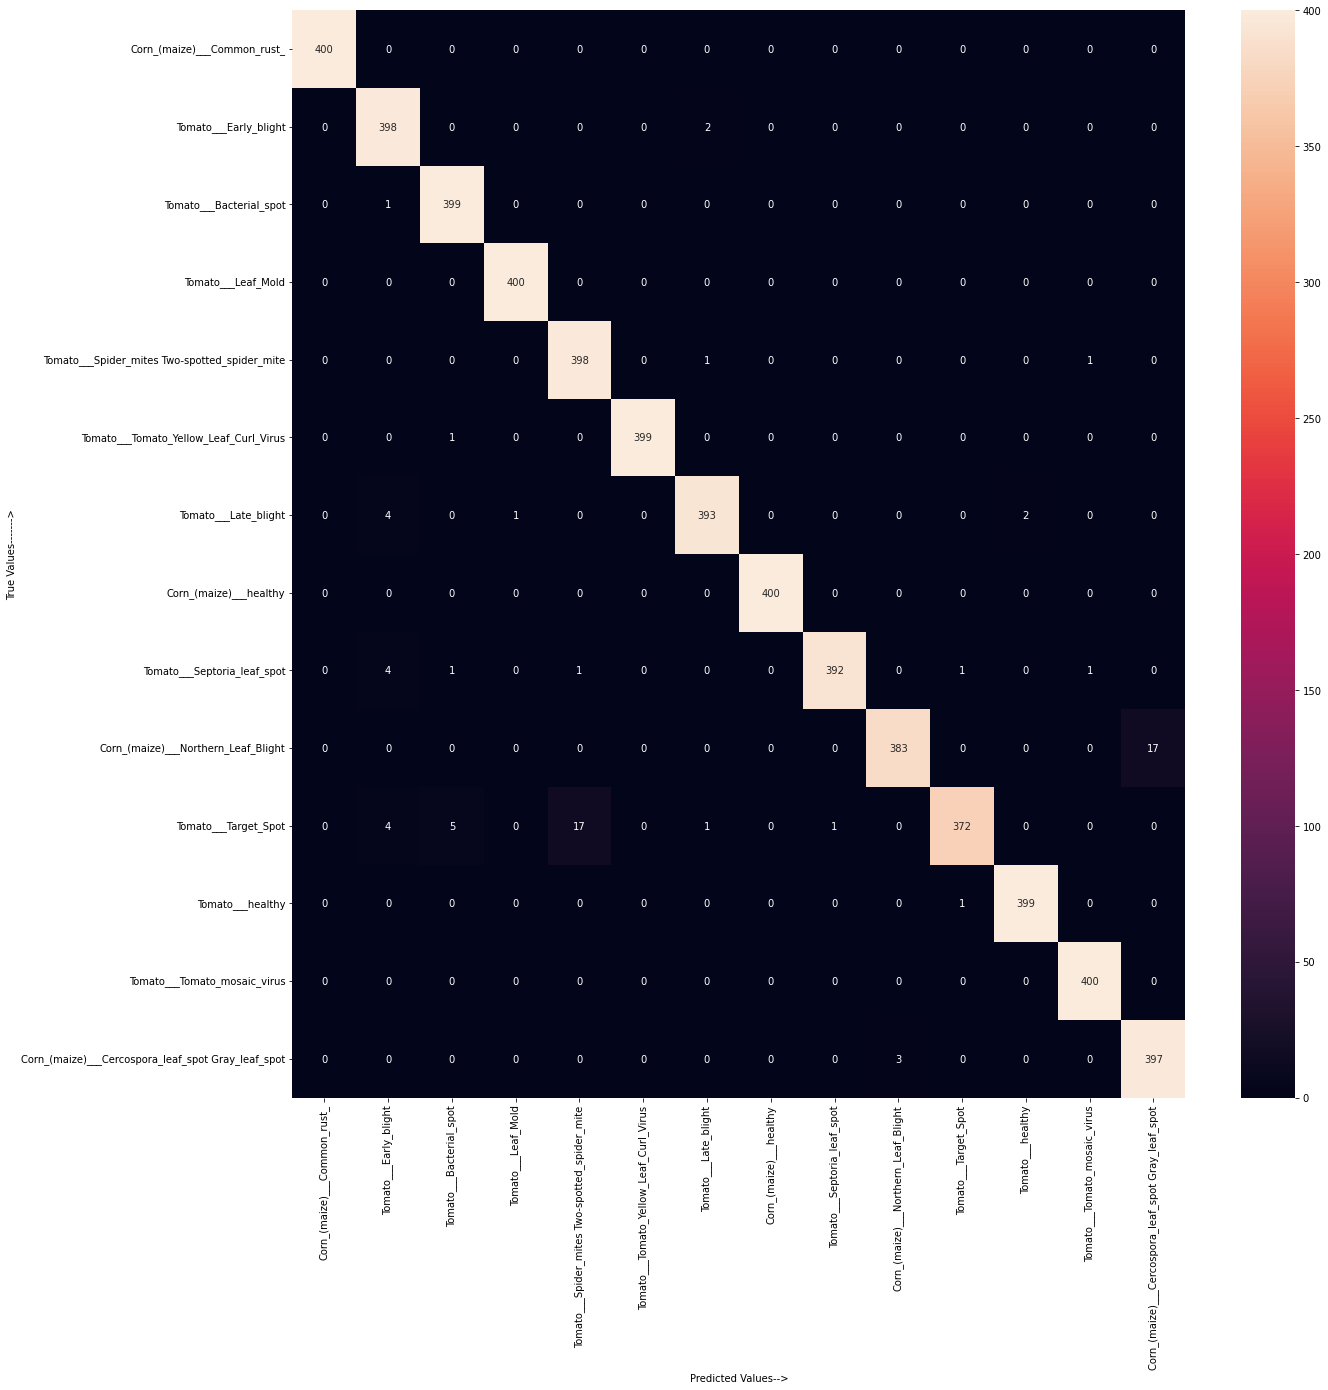

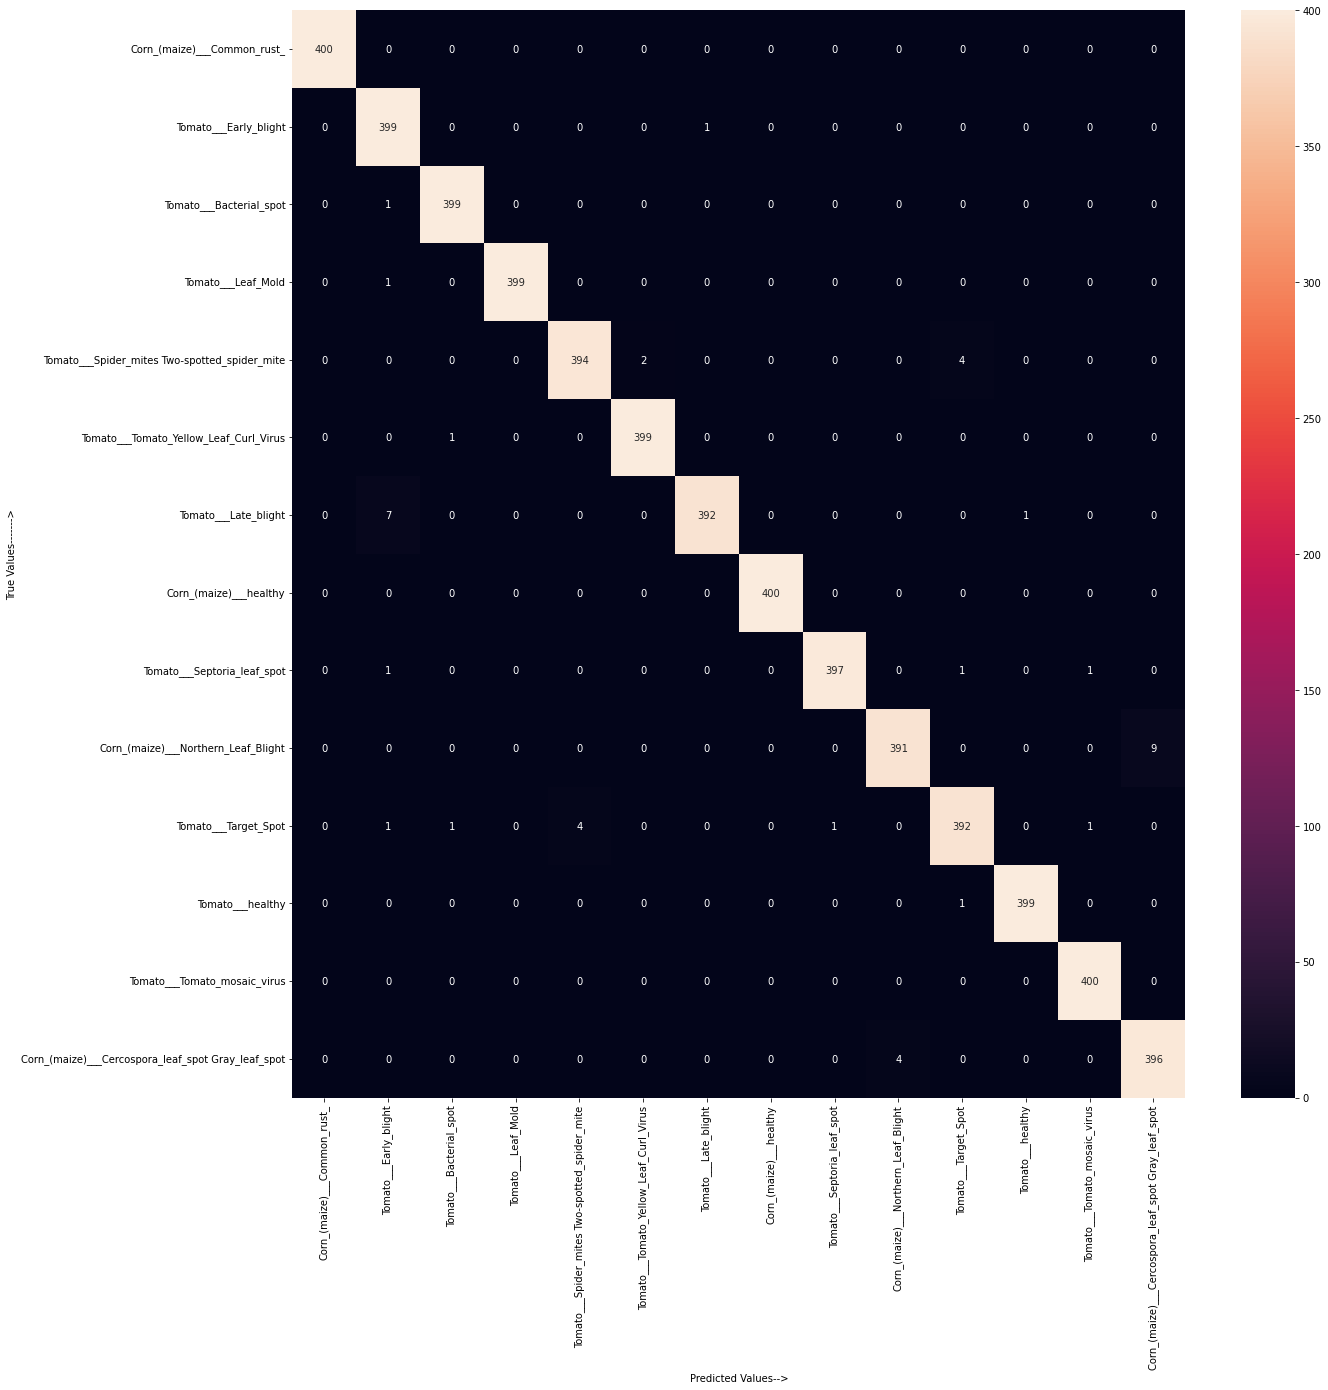

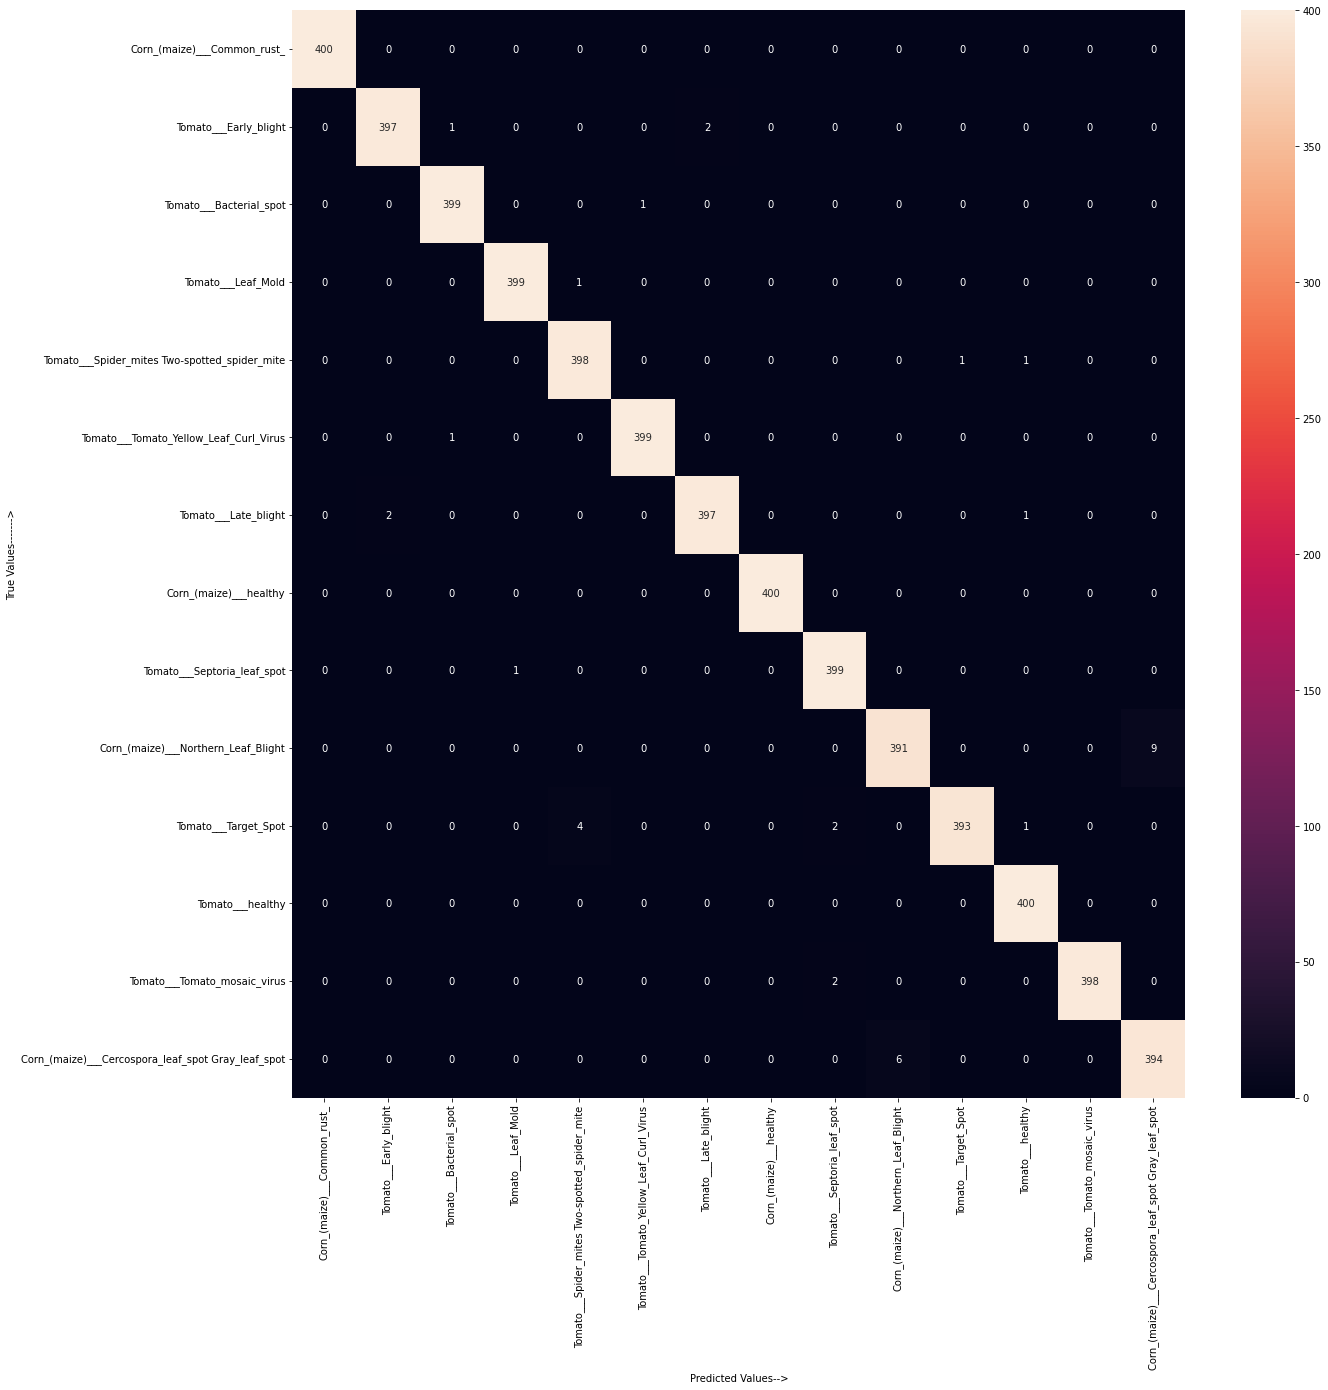

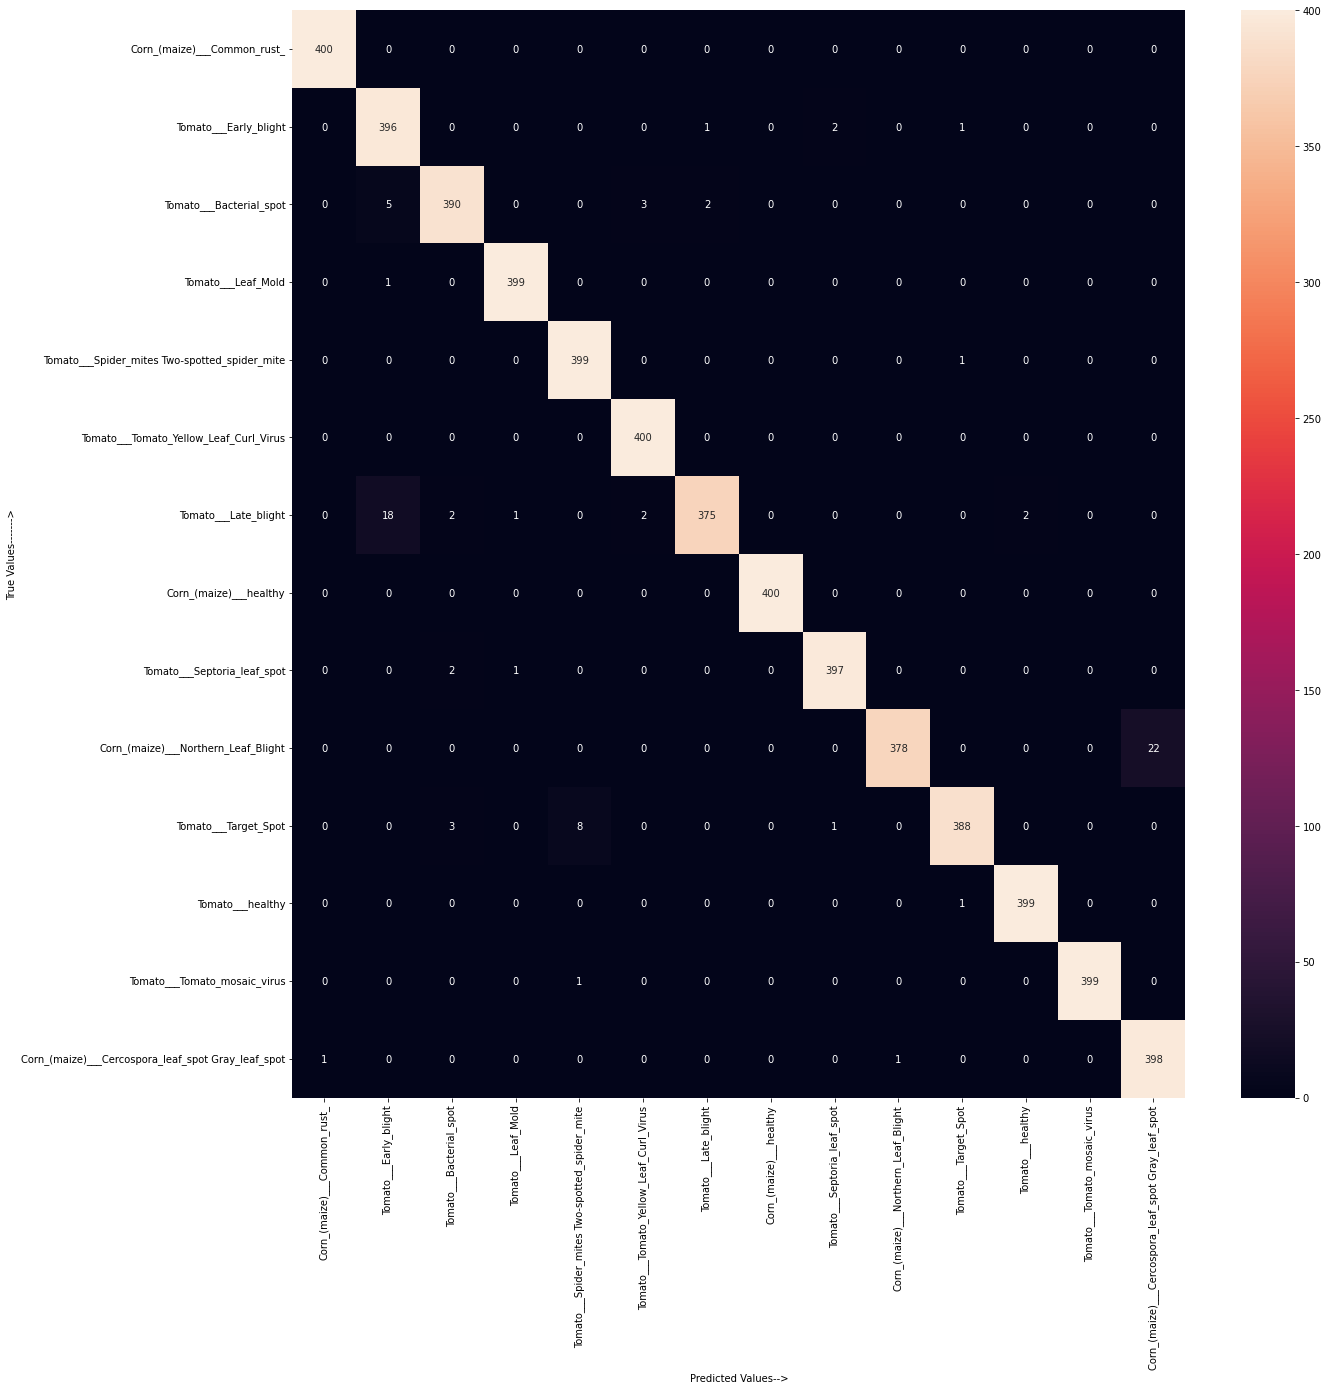

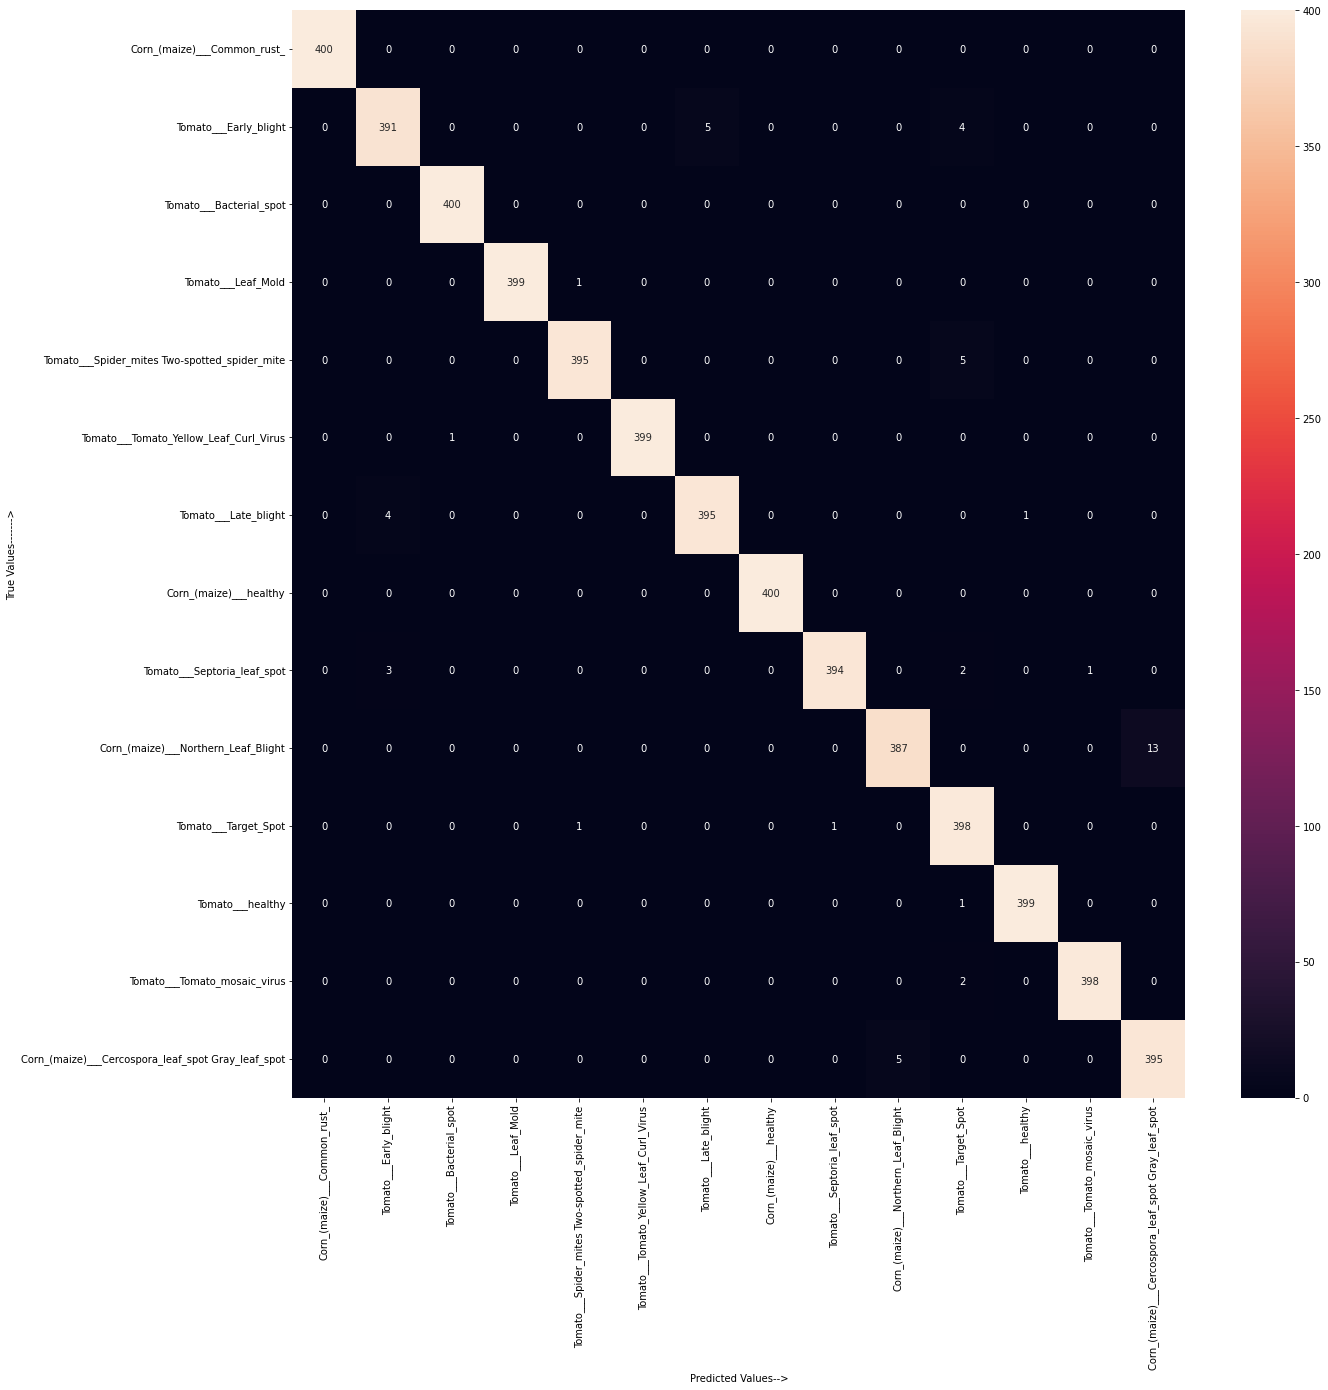

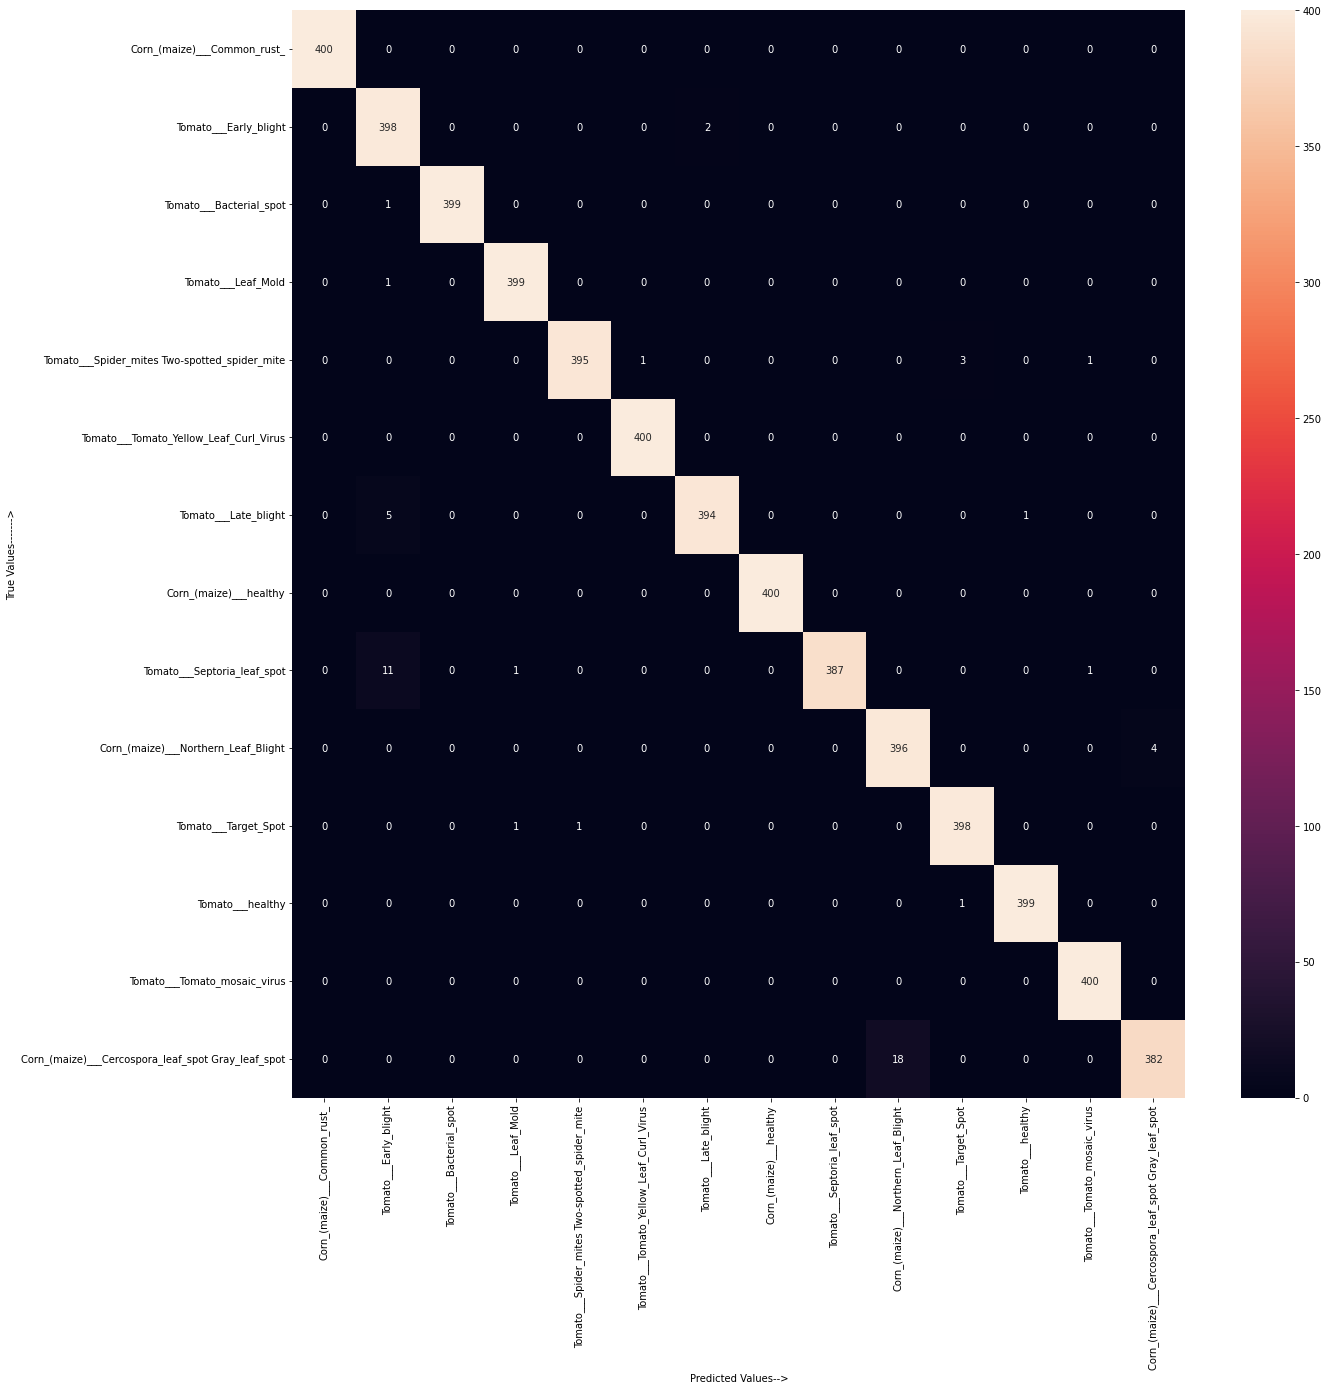

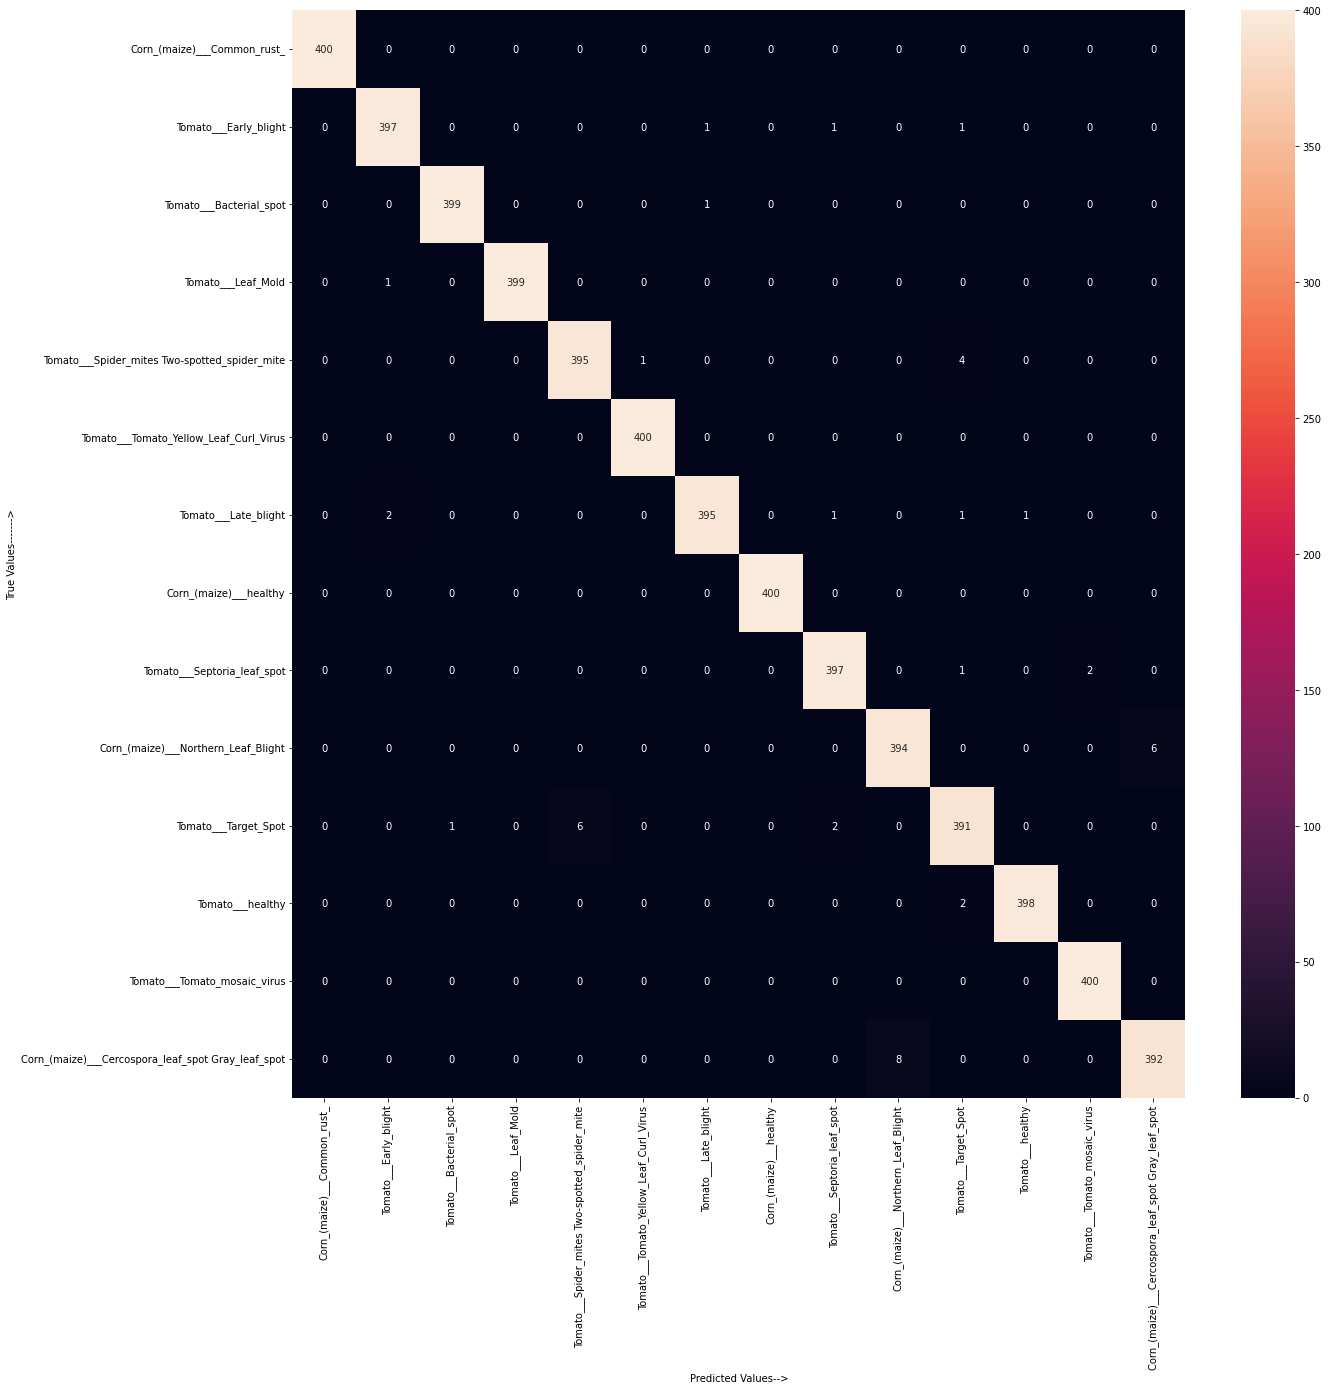

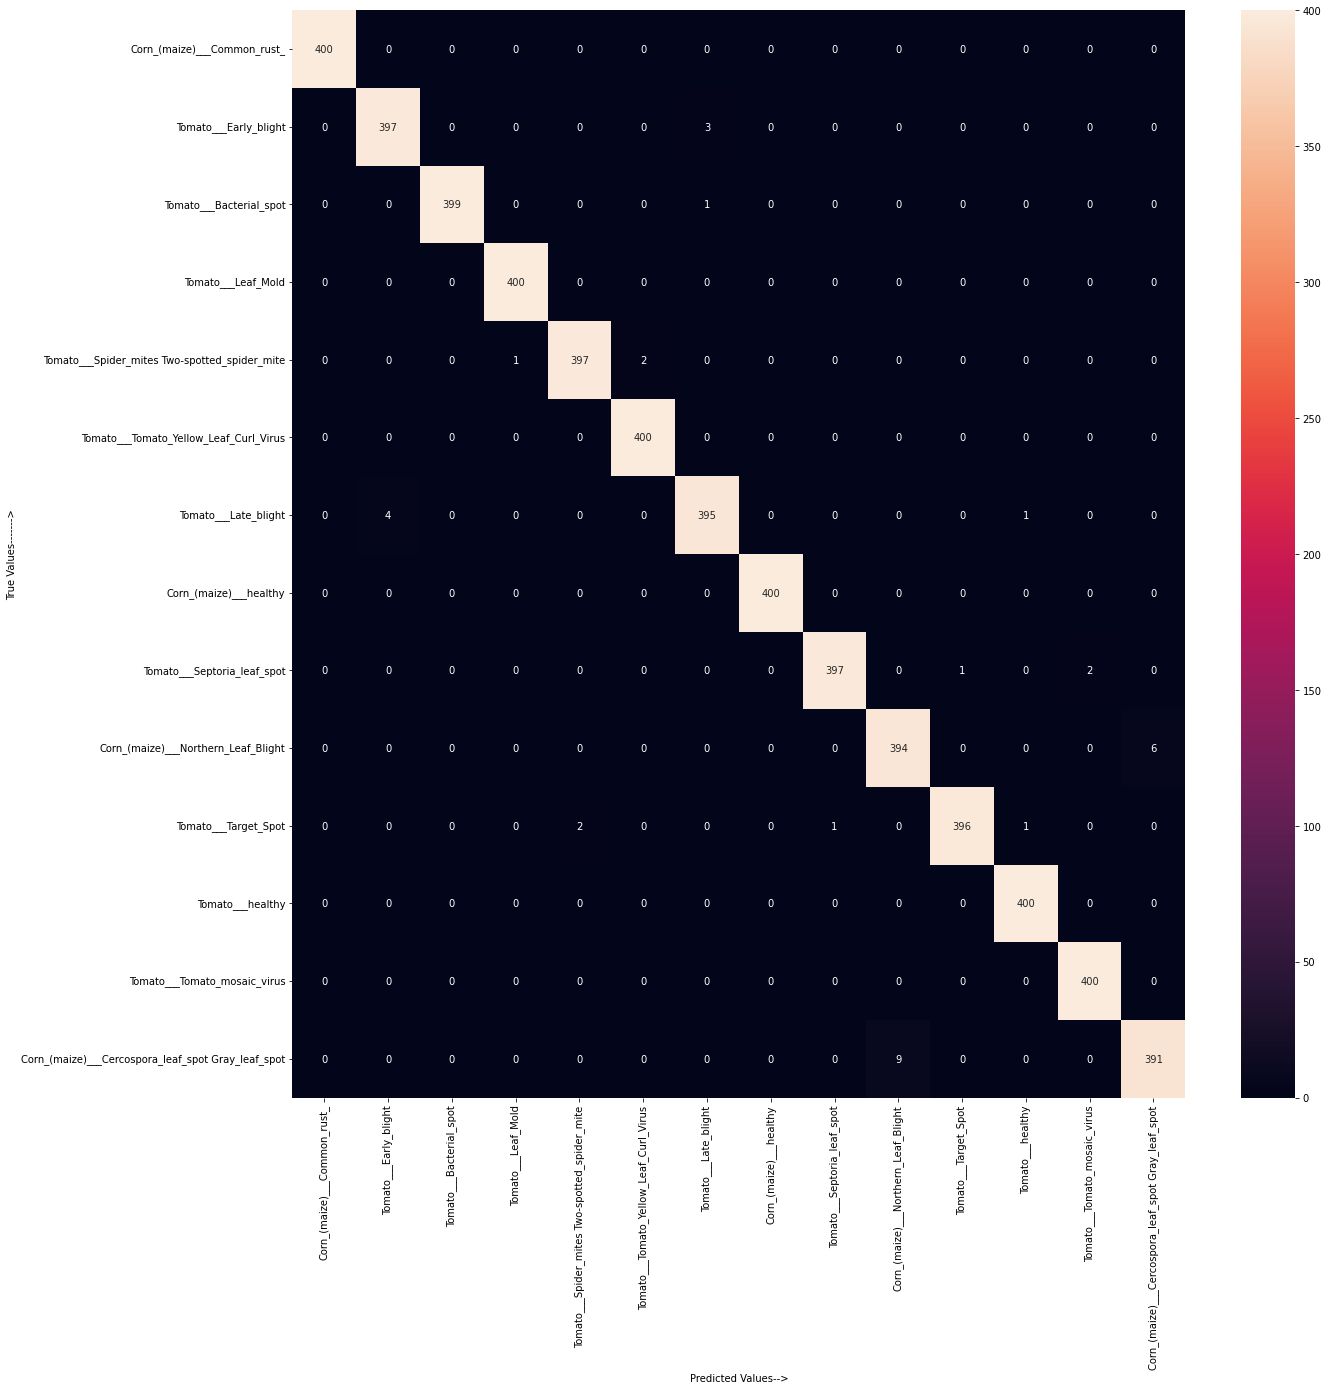

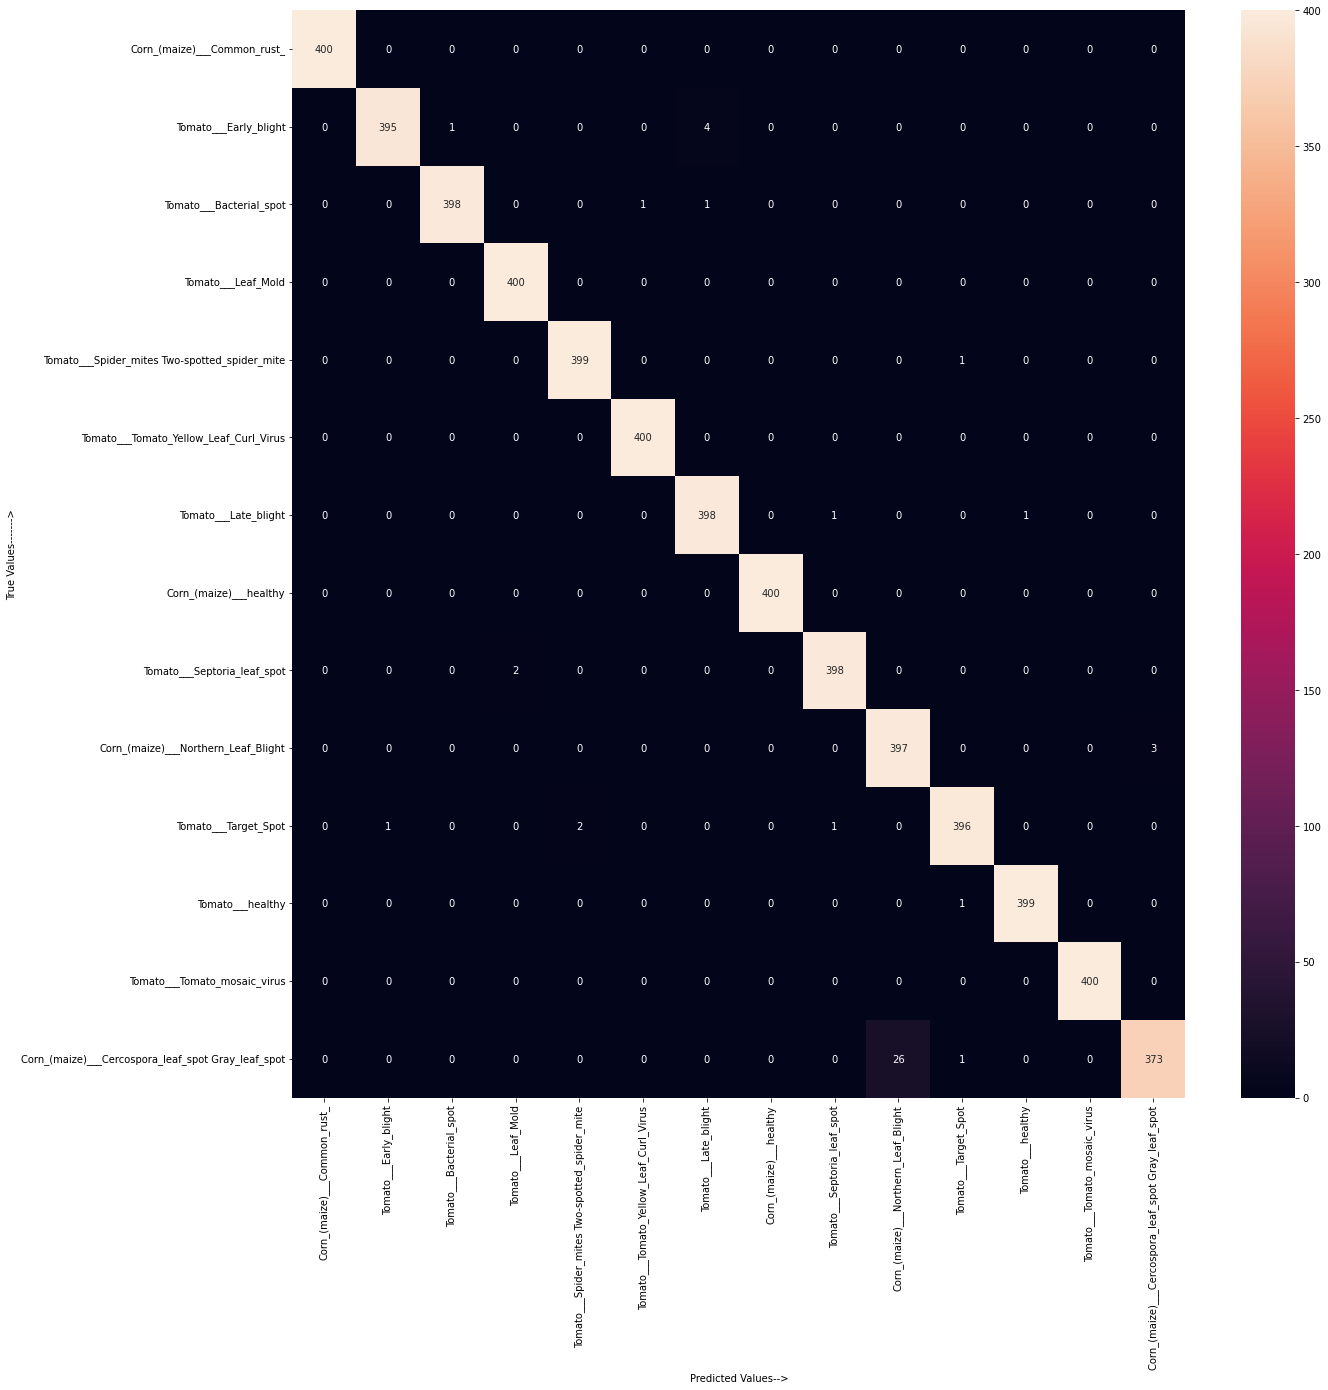

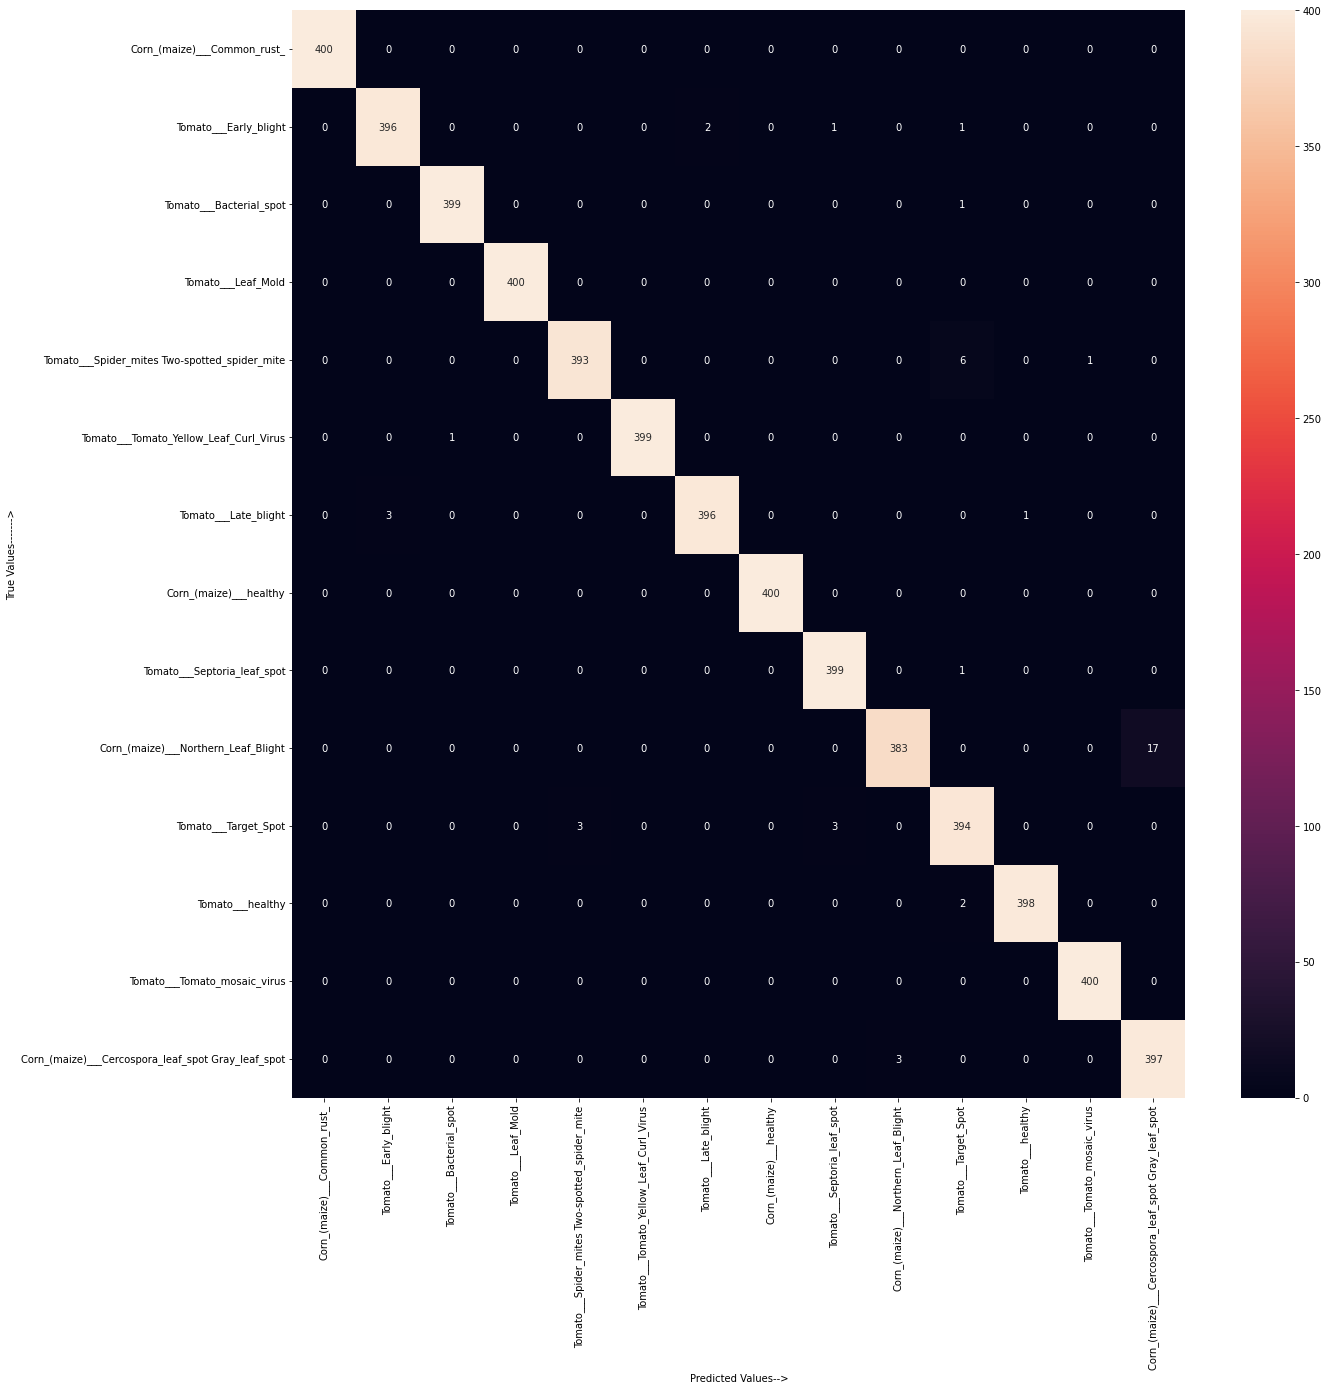

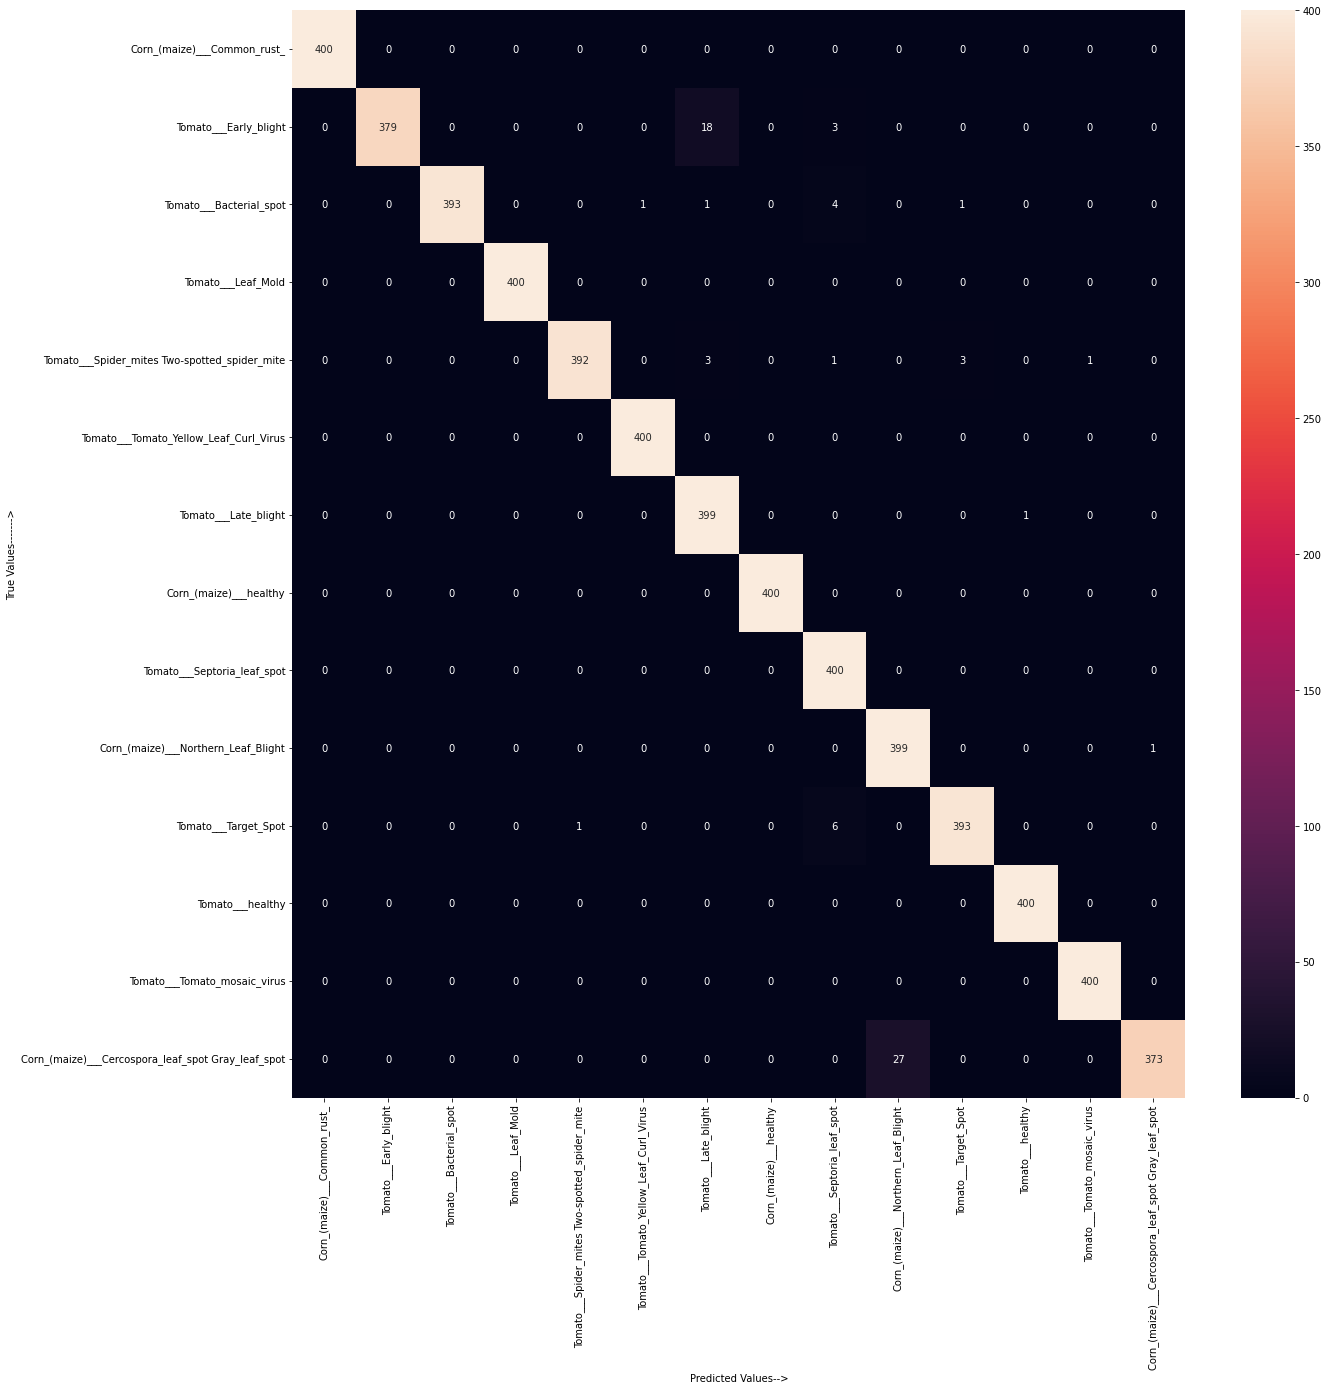

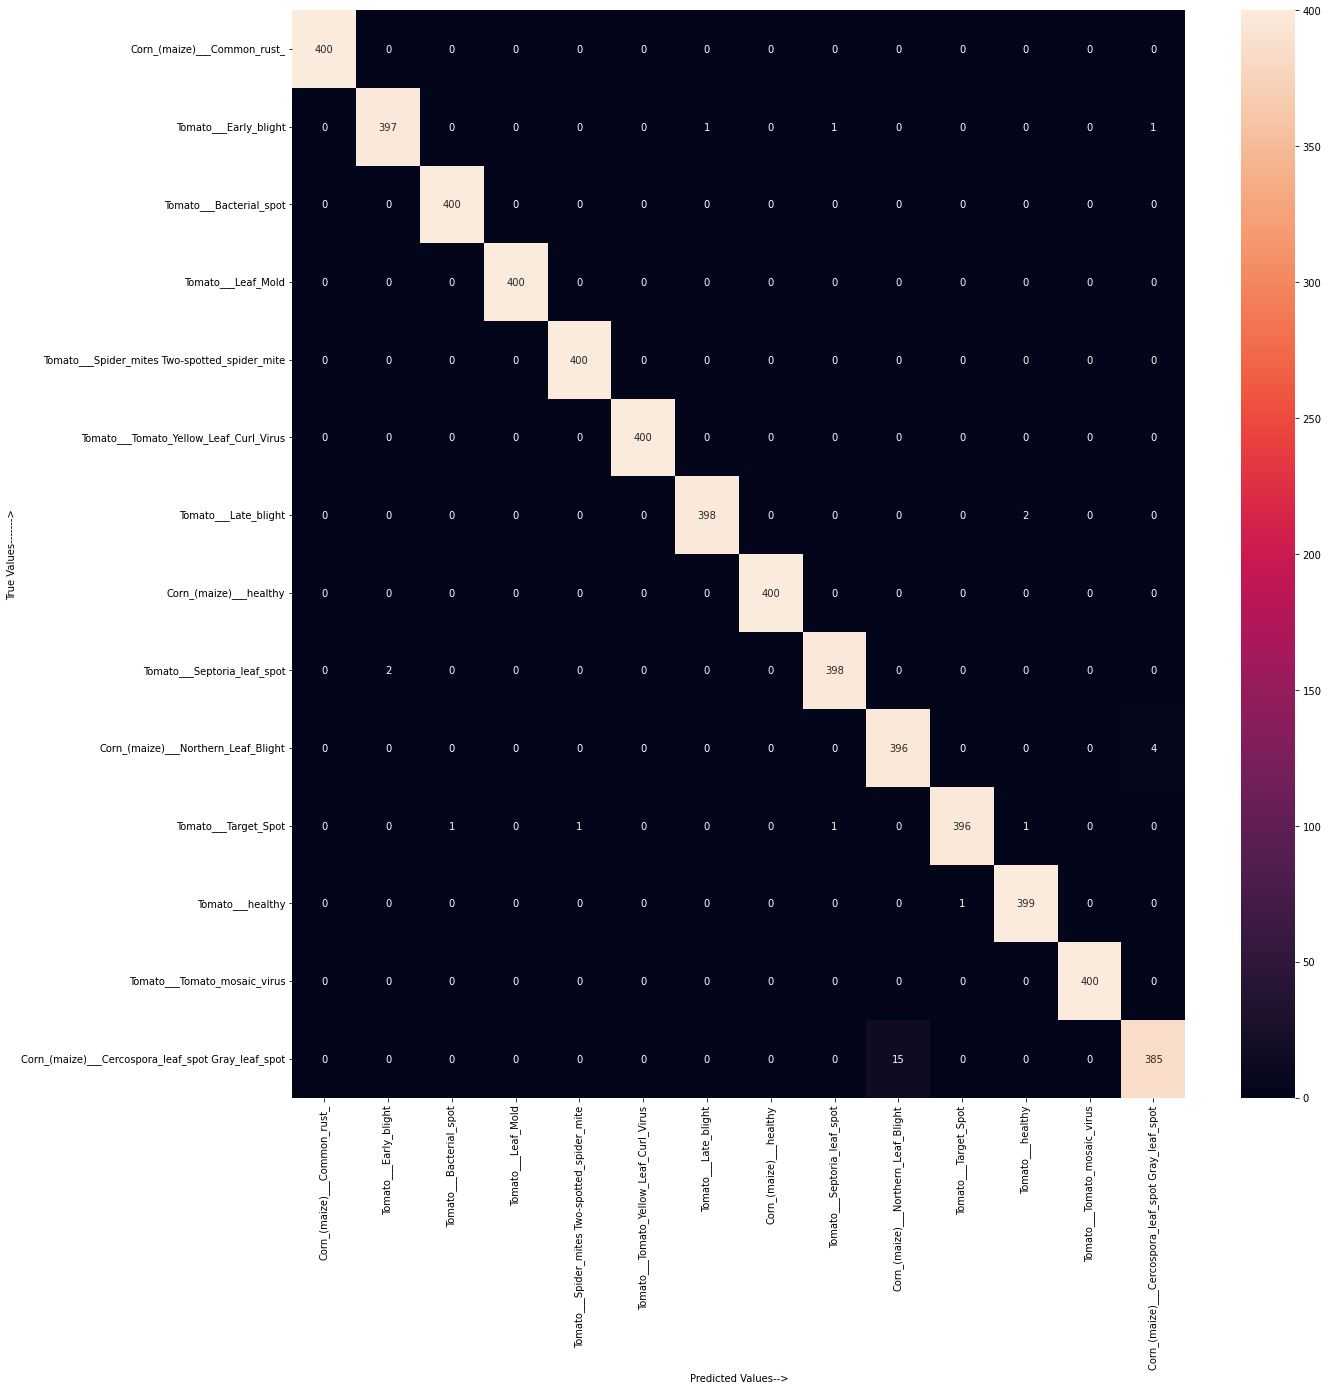

<Figure size 432x288 with 0 Axes>

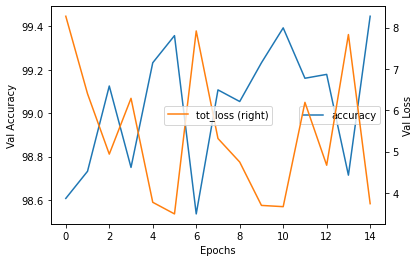

In [ ]:
model = torchvision.models.get_model('mobilenet_v2', weights='MobileNet_V2_Weights.IMAGENET1K_V1')
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=14)
model = model.to(device)
train(model, optimizer_choice = "adam", num_of_epochs = 15)